# CIFAR100 classification with ConvNextLarge from scratch ( not using ImageNet weights)
* **ConvNextLarge has about 190 milion parameters!**
* **TPU Distributed Training with Keras-3 and jax as its backend**

In [1]:
# Installing tensorflow-cpu to avoid tensorflow using TPUs
!pip install -q -U tensorflow-cpu

!pip install --upgrade -q keras


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
os.environ['KERAS_BACKEND'] = 'jax'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

# if you face OOM, uncomment this line bellow
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'

## Setting Keras DataParallel strategy for distributed training

In [3]:
import keras

devices = keras.distribution.list_devices()
print(f'Available devices:{devices}')

data_parallel = keras.distribution.DataParallel(devices=devices)

# Or you can choose to create DataParallel with a 1D `DeviceMesh`.
mesh_1d = keras.distribution.DeviceMesh(
    shape=(8, ), axis_names=["data"], devices=devices
)
data_parallel = keras.distribution.DataParallel(device_mesh=mesh_1d)

# Set the global distribution.
keras.distribution.set_distribution(data_parallel)

E0000 00:00:1738962373.907838      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


Available devices:['tpu:0', 'tpu:1', 'tpu:2', 'tpu:3', 'tpu:4', 'tpu:5', 'tpu:6', 'tpu:7']


In [4]:
import numpy as np

import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import ConvNeXtLarge

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 32 * len(devices)

## Mixed Precision Computation for lower memory usage and higher training speed

In [5]:
# using these two bad boys can increase the training step by over 200% in Keras3 + JAX + training loop from scratch
keras.config.set_dtype_policy("mixed_float16")
keras.mixed_precision.set_global_policy("mixed_float16")

## Reproduction

In [6]:
keras.utils.set_random_seed(0)

## Downloading dataset

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
NUM_CLASSES = 100
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

        0/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

     8192/169001437 ━━━━━━━━━━━━━━━━━━━━ 31:15 11us/step

    40960/169001437 ━━━━━━━━━━━━━━━━━━━━ 12:45 5us/step 

    98304/169001437 ━━━━━━━━━━━━━━━━━━━━ 7:57 3us/step 

   212992/169001437 ━━━━━━━━━━━━━━━━━━━━ 4:54 2us/step

   442368/169001437 ━━━━━━━━━━━━━━━━━━━━ 2:57 1us/step

   909312/169001437 ━━━━━━━━━━━━━━━━━━━━ 1:43 1us/step

  1826816/169001437 ━━━━━━━━━━━━━━━━━━━━ 59s 0us/step 

  3678208/169001437 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step

  6815744/169001437 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

  9936896/169001437 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 13058048/169001437 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 16105472/169001437 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 16752640/169001437 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 19218432/169001437 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step 

 21848064/169001437 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 22913024/169001437 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 25337856/169001437 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 27992064/169001437 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 29106176/169001437 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 31064064/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 32530432/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 34545664/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 36888576/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 38109184/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 40296448/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 41771008/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 43941888/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 45359104/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 47472640/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 48979968/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 51027968/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 52494336/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 54165504/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 56680448/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 57237504/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 60276736/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 63348736/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 66420736/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 66617344/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 69533696/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 72212480/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 72794112/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 75661312/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 77979648/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 79011840/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 81338368/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 82370560/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 84901888/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 87113728/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 88285184/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 90595328/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 91815936/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 94208000/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 95707136/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 97574912/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 99180544/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

100777984/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

102178816/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

104243200/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

105775104/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

107429888/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

109060096/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

110501888/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

113377280/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

113803264/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

116441088/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

119439360/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

119889920/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

122404864/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

125272064/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

125648896/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

128483328/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

128950272/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

131465216/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

134332416/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

134782976/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

137510912/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

140402688/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

143458304/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

146456576/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

149356544/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

149864448/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

152641536/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

155639808/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

155992064/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

158744576/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

161800192/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

164708352/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

167731200/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [8]:
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 100)


In [9]:
import tensorflow as tf

ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [10]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

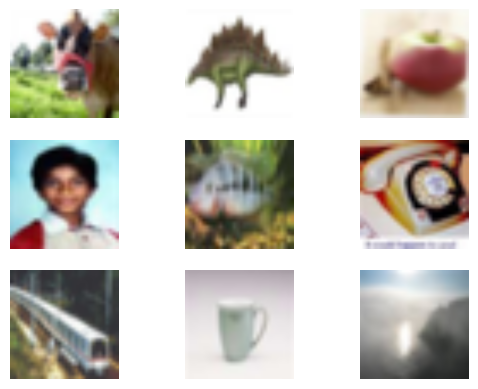

In [11]:
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))

    plt.axis("off")

In [12]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

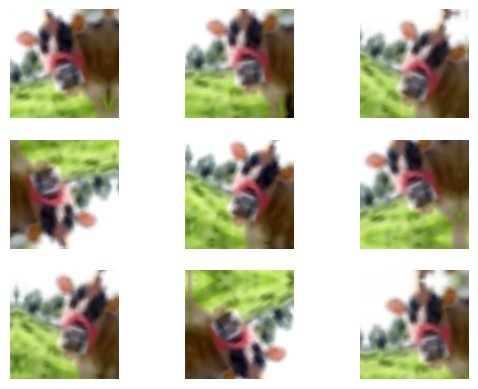

In [13]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.axis("off")

## Data Augmentation

In [14]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    return image, label


def input_preprocess_test(image, label):
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

## Model Creataion

In [15]:
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential

def get_model():
    model = ConvNeXtLarge(
    include_top=False,
    weights=None, # Training from scratch
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    model.trainable = True


    classifier = Sequential([
                             model,
                             GlobalAveragePooling2D(),
                             Dropout(0.1),
                             Dense(NUM_CLASSES, activation = 'softmax')])
    
    
    return classifier

In [16]:
model = get_model()

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'],
              jit_compile = True #Default is True, but here i wanted to show you that we use JIT compilation
             )

In [17]:
model.summary(show_trainable = True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ convnext_large (Functional) │ (None, 7, 7, 1536)    │ 196,230,3… │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1536)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1536)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 100)           │    153,700 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 196,384,036 (749.15 MB)

 Trainable params: 196,384,036 (749.15 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [18]:
history = model.fit(ds_train, validation_data = ds_test, epochs = 100)

Epoch 1/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 4:30:49 84s/step - accuracy: 0.0117 - loss: 4.8399

  2/195 ━━━━━━━━━━━━━━━━━━━━ 21:35 7s/step - accuracy: 0.0107 - loss: 5.9939   

  3/195 ━━━━━━━━━━━━━━━━━━━━ 11:27 4s/step - accuracy: 0.0093 - loss: 6.0286

  4/195 ━━━━━━━━━━━━━━━━━━━━ 8:05 3s/step - accuracy: 0.0097 - loss: 5.8888 

  5/195 ━━━━━━━━━━━━━━━━━━━━ 6:24 2s/step - accuracy: 0.0102 - loss: 5.7550

  6/195 ━━━━━━━━━━━━━━━━━━━━ 5:22 2s/step - accuracy: 0.0109 - loss: 5.6427

  7/195 ━━━━━━━━━━━━━━━━━━━━ 4:41 1s/step - accuracy: 0.0116 - loss: 5.5476

 14/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 938ms/step - accuracy: 0.0167 - loss: 5.4313

  9/195 ━━━━━━━━━━━━━━━━━━━━ 3:50 1s/step - accuracy: 0.0129 - loss: 5.4489   

 15/195 ━━━━━━━━━━━━━━━━━━━━ 2:42 904ms/step - accuracy: 0.0172 - loss: 5.3979

 17/195 ━━━━━━━━━━━━━━━━━━━━ 2:30 848ms/step - accuracy: 0.0180 - loss: 5.3979

 21/195 ━━━━━━━━━━━━━━━━━━━━ 2:13 770ms/step - accuracy: 0.0190 - loss: 5.3979

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:52 680ms/step - accuracy: 0.0208 - loss: 5.3821

 24/195 ━━━━━━━━━━━━━━━━━━━━ 2:04 729ms/step - accuracy: 0.0197 - loss: 5.3821

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:55 689ms/step - accuracy: 0.0205 - loss: 5.3668

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:49 666ms/step - accuracy: 0.0212 - loss: 5.3668

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:51 673ms/step - accuracy: 0.0210 - loss: 5.3821

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:44 647ms/step - accuracy: 0.0218 - loss: 5.3521

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:42 641ms/step - accuracy: 0.0220 - loss: 5.3378

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:41 636ms/step - accuracy: 0.0221 - loss: 5.2730

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:39 631ms/step - accuracy: 0.0223 - loss: 5.2280

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:38 626ms/step - accuracy: 0.0224 - loss: 5.1974

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:36 622ms/step - accuracy: 0.0226 - loss: 5.1607

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:35 618ms/step - accuracy: 0.0228 - loss: 5.1278

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:30 603ms/step - accuracy: 0.0234 - loss: 5.0980

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 582ms/step - accuracy: 0.0243 - loss: 5.0644

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 571ms/step - accuracy: 0.0249 - loss: 5.0709

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 561ms/step - accuracy: 0.0255 - loss: 5.0644

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 569ms/step - accuracy: 0.0251 - loss: 5.0581

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 567ms/step - accuracy: 0.0252 - loss: 5.0581

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 560ms/step - accuracy: 0.0256 - loss: 5.0581

 64/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 556ms/step - accuracy: 0.0258 - loss: 5.0519

 66/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 553ms/step - accuracy: 0.0260 - loss: 5.0519

 67/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 552ms/step - accuracy: 0.0261 - loss: 5.0459

 68/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 551ms/step - accuracy: 0.0262 - loss: 5.0284

 69/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 549ms/step - accuracy: 0.0263 - loss: 5.0016

 70/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 548ms/step - accuracy: 0.0263 - loss: 4.9867

 71/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 546ms/step - accuracy: 0.0264 - loss: 4.9678

 72/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 545ms/step - accuracy: 0.0265 - loss: 4.9502

 73/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 544ms/step - accuracy: 0.0266 - loss: 4.9337

 74/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 543ms/step - accuracy: 0.0267 - loss: 4.9259

 77/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 539ms/step - accuracy: 0.0269 - loss: 4.9183

 79/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 537ms/step - accuracy: 0.0271 - loss: 4.9146

 78/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 538ms/step - accuracy: 0.0270 - loss: 4.9146

 82/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 534ms/step - accuracy: 0.0274 - loss: 4.9109

 83/195 ━━━━━━━━━━━━━━━━━━━━ 59s 533ms/step - accuracy: 0.0275 - loss: 4.9109 

 81/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 535ms/step - accuracy: 0.0273 - loss: 4.9109

 86/195 ━━━━━━━━━━━━━━━━━━━━ 57s 531ms/step - accuracy: 0.0277 - loss: 4.9073 

 87/195 ━━━━━━━━━━━━━━━━━━━━ 57s 530ms/step - accuracy: 0.0278 - loss: 4.9073

 95/195 ━━━━━━━━━━━━━━━━━━━━ 52s 524ms/step - accuracy: 0.0284 - loss: 4.9073

 96/195 ━━━━━━━━━━━━━━━━━━━━ 51s 523ms/step - accuracy: 0.0284 - loss: 4.9038

 98/195 ━━━━━━━━━━━━━━━━━━━━ 50s 522ms/step - accuracy: 0.0286 - loss: 4.9003

 99/195 ━━━━━━━━━━━━━━━━━━━━ 50s 521ms/step - accuracy: 0.0286 - loss: 4.8968

100/195 ━━━━━━━━━━━━━━━━━━━━ 49s 521ms/step - accuracy: 0.0287 - loss: 4.8968

101/195 ━━━━━━━━━━━━━━━━━━━━ 48s 520ms/step - accuracy: 0.0288 - loss: 4.8867

102/195 ━━━━━━━━━━━━━━━━━━━━ 48s 519ms/step - accuracy: 0.0288 - loss: 4.8705

103/195 ━━━━━━━━━━━━━━━━━━━━ 47s 518ms/step - accuracy: 0.0289 - loss: 4.8583

105/195 ━━━━━━━━━━━━━━━━━━━━ 46s 517ms/step - accuracy: 0.0290 - loss: 4.8352

108/195 ━━━━━━━━━━━━━━━━━━━━ 44s 516ms/step - accuracy: 0.0293 - loss: 4.8191

109/195 ━━━━━━━━━━━━━━━━━━━━ 44s 515ms/step - accuracy: 0.0293 - loss: 4.8165

106/195 ━━━━━━━━━━━━━━━━━━━━ 45s 517ms/step - accuracy: 0.0291 - loss: 4.8191

127/195 ━━━━━━━━━━━━━━━━━━━━ 34s 507ms/step - accuracy: 0.0306 - loss: 4.8089

119/195 ━━━━━━━━━━━━━━━━━━━━ 38s 510ms/step - accuracy: 0.0300 - loss: 4.8114

114/195 ━━━━━━━━━━━━━━━━━━━━ 41s 513ms/step - accuracy: 0.0297 - loss: 4.8140

116/195 ━━━━━━━━━━━━━━━━━━━━ 40s 512ms/step - accuracy: 0.0298 - loss: 4.8140

118/195 ━━━━━━━━━━━━━━━━━━━━ 39s 511ms/step - accuracy: 0.0299 - loss: 4.8114

128/195 ━━━━━━━━━━━━━━━━━━━━ 33s 506ms/step - accuracy: 0.0306 - loss: 4.8089

131/195 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - accuracy: 0.0309 - loss: 4.8039

130/195 ━━━━━━━━━━━━━━━━━━━━ 32s 506ms/step - accuracy: 0.0308 - loss: 4.8063

132/195 ━━━━━━━━━━━━━━━━━━━━ 31s 505ms/step - accuracy: 0.0309 - loss: 4.8014

133/195 ━━━━━━━━━━━━━━━━━━━━ 31s 505ms/step - accuracy: 0.0310 - loss: 4.8014

134/195 ━━━━━━━━━━━━━━━━━━━━ 30s 504ms/step - accuracy: 0.0311 - loss: 4.7894

135/195 ━━━━━━━━━━━━━━━━━━━━ 30s 504ms/step - accuracy: 0.0311 - loss: 4.7801

136/195 ━━━━━━━━━━━━━━━━━━━━ 29s 503ms/step - accuracy: 0.0312 - loss: 4.7733

137/195 ━━━━━━━━━━━━━━━━━━━━ 29s 503ms/step - accuracy: 0.0313 - loss: 4.7645

144/195 ━━━━━━━━━━━━━━━━━━━━ 25s 501ms/step - accuracy: 0.0318 - loss: 4.7436

143/195 ━━━━━━━━━━━━━━━━━━━━ 26s 501ms/step - accuracy: 0.0317 - loss: 4.7436

140/195 ━━━━━━━━━━━━━━━━━━━━ 27s 502ms/step - accuracy: 0.0315 - loss: 4.7456

142/195 ━━━━━━━━━━━━━━━━━━━━ 26s 502ms/step - accuracy: 0.0316 - loss: 4.7456

145/195 ━━━━━━━━━━━━━━━━━━━━ 25s 501ms/step - accuracy: 0.0319 - loss: 4.7416

151/195 ━━━━━━━━━━━━━━━━━━━━ 21s 499ms/step - accuracy: 0.0323 - loss: 4.7396

161/195 ━━━━━━━━━━━━━━━━━━━━ 16s 496ms/step - accuracy: 0.0330 - loss: 4.7357

153/195 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.0324 - loss: 4.7376

157/195 ━━━━━━━━━━━━━━━━━━━━ 18s 497ms/step - accuracy: 0.0327 - loss: 4.7376

150/195 ━━━━━━━━━━━━━━━━━━━━ 22s 499ms/step - accuracy: 0.0322 - loss: 4.7376

163/195 ━━━━━━━━━━━━━━━━━━━━ 15s 496ms/step - accuracy: 0.0332 - loss: 4.7357

164/195 ━━━━━━━━━━━━━━━━━━━━ 15s 496ms/step - accuracy: 0.0333 - loss: 4.7317

165/195 ━━━━━━━━━━━━━━━━━━━━ 14s 495ms/step - accuracy: 0.0333 - loss: 4.7317

166/195 ━━━━━━━━━━━━━━━━━━━━ 14s 495ms/step - accuracy: 0.0334 - loss: 4.7240

167/195 ━━━━━━━━━━━━━━━━━━━━ 13s 495ms/step - accuracy: 0.0335 - loss: 4.7165

168/195 ━━━━━━━━━━━━━━━━━━━━ 13s 495ms/step - accuracy: 0.0336 - loss: 4.7092

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 492ms/step - accuracy: 0.0344 - loss: 4.6815 

172/195 ━━━━━━━━━━━━━━━━━━━━ 11s 494ms/step - accuracy: 0.0339 - loss: 4.6882

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 491ms/step - accuracy: 0.0348 - loss: 4.6815

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step - accuracy: 0.0345 - loss: 4.6815

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.0354 - loss: 4.6815

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 491ms/step - accuracy: 0.0349 - loss: 4.6815

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - accuracy: 0.0352 - loss: 4.6815

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.0350 - loss: 4.6815

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 0.0351 - loss: 4.6798

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step - accuracy: 0.0353 - loss: 4.6815

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.0356 - loss: 4.6798

195/195 ━━━━━━━━━━━━━━━━━━━━ 210s 652ms/step - accuracy: 0.0356 - loss: 4.6782 - val_accuracy: 0.0825 - val_loss: 3.9765


Epoch 2/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 959ms/step - accuracy: 0.0781 - loss: 4.0764

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.0771 - loss: 4.0471

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.0749 - loss: 4.0345

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.0740 - loss: 4.0298

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.0748 - loss: 4.0318

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.0758 - loss: 4.0320

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.0761 - loss: 4.0317

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.0773 - loss: 4.0304

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.0778 - loss: 4.0295

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.0780 - loss: 4.0295

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.0780 - loss: 4.0298

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.0776 - loss: 4.0295

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.0773 - loss: 4.0292

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.0774 - loss: 4.0292

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.0773 - loss: 4.0292

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.0774 - loss: 4.0289

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.0774 - loss: 4.0287

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.0774 - loss: 4.0283

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.0774 - loss: 4.0271

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.0774 - loss: 4.0258

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.0774 - loss: 4.0246

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.0774 - loss: 4.0221

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.0775 - loss: 4.0210

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.0775 - loss: 4.0207

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.0776 - loss: 4.0207

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.0777 - loss: 4.0199

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.0778 - loss: 4.0197

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.0778 - loss: 4.0197

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.0780 - loss: 4.0197

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.0777 - loss: 4.0197

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.0780 - loss: 4.0194

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.0779 - loss: 4.0194

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.0780 - loss: 4.0194 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.0781 - loss: 4.0194 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.0781 - loss: 4.0189

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.0781 - loss: 4.0186

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.0781 - loss: 4.0178

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.0782 - loss: 4.0165

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.0782 - loss: 4.0157

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.0782 - loss: 4.0145

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.0783 - loss: 4.0119

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.0783 - loss: 4.0125

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - accuracy: 0.0783 - loss: 4.0119

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.0784 - loss: 4.0117

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.0789 - loss: 4.0109

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.0786 - loss: 4.0111

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.0791 - loss: 4.0109

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.0790 - loss: 4.0109

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.0788 - loss: 4.0111

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.0792 - loss: 4.0103

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.0793 - loss: 4.0100

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.0792 - loss: 4.0100

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.0793 - loss: 4.0100

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.0794 - loss: 4.0086

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.0794 - loss: 4.0072

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.0795 - loss: 4.0056

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.0796 - loss: 4.0020

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.0797 - loss: 4.0008

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.0799 - loss: 3.9999

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.0800 - loss: 3.9995

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.0805 - loss: 3.9991

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.0800 - loss: 3.9995

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.0808 - loss: 3.9987

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.0802 - loss: 3.9987

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.0810 - loss: 3.9983

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.0810 - loss: 3.9983

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.0811 - loss: 3.9975

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.0812 - loss: 3.9975

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.0812 - loss: 3.9958

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.0813 - loss: 3.9942

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.0814 - loss: 3.9925

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.0815 - loss: 3.9892

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.0815 - loss: 3.9908

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.0816 - loss: 3.9884

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.0819 - loss: 3.9867

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.0823 - loss: 3.9860

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.0826 - loss: 3.9860

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.0820 - loss: 3.9860

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.0829 - loss: 3.9852

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.0831 - loss: 3.9856

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.0829 - loss: 3.9852

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.0831 - loss: 3.9852

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.0832 - loss: 3.9844

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.0833 - loss: 3.9844

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.0834 - loss: 3.9824

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.0834 - loss: 3.9812

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.0835 - loss: 3.9797

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.0836 - loss: 3.9781

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.0836 - loss: 3.9762

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.0839 - loss: 3.9744

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.0838 - loss: 3.9747

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.0837 - loss: 3.9747

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.0840 - loss: 3.9744 

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.0842 - loss: 3.9740

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.0848 - loss: 3.9732

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.0846 - loss: 3.9732

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.0843 - loss: 3.9732

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.0852 - loss: 3.9725

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.0852 - loss: 3.9721 - val_accuracy: 0.1336 - val_loss: 3.6671


Epoch 3/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:00 930ms/step - accuracy: 0.1172 - loss: 3.7915

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.1260 - loss: 3.7783

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.1226 - loss: 3.7688

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.1193 - loss: 3.7590

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.1179 - loss: 3.7544

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.1171 - loss: 3.7489

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.1169 - loss: 3.7481

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.1169 - loss: 3.7476

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.1168 - loss: 3.7467

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.1168 - loss: 3.7476

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.1168 - loss: 3.7467

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.1168 - loss: 3.7471

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.1174 - loss: 3.7463

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.1174 - loss: 3.7463

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.1174 - loss: 3.7454

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.1174 - loss: 3.7459

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.1174 - loss: 3.7454

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.1175 - loss: 3.7451

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.1175 - loss: 3.7447

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.1176 - loss: 3.7444

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.1177 - loss: 3.7431

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.1177 - loss: 3.7412

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.1177 - loss: 3.7386

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.1177 - loss: 3.7404

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.1177 - loss: 3.7378

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.1178 - loss: 3.7368

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.1177 - loss: 3.7368

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.1180 - loss: 3.7361

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.1178 - loss: 3.7368

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.1182 - loss: 3.7358

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.1181 - loss: 3.7358

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.1182 - loss: 3.7355

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.1181 - loss: 3.7358

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.1184 - loss: 3.7350

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.1185 - loss: 3.7347

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.1184 - loss: 3.7347

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - accuracy: 0.1185 - loss: 3.7347

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.1186 - loss: 3.7345 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.1186 - loss: 3.7337

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.1187 - loss: 3.7329

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.1187 - loss: 3.7319

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.1188 - loss: 3.7309

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.1191 - loss: 3.7283

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.1190 - loss: 3.7285

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.1194 - loss: 3.7278

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.1191 - loss: 3.7283

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.1193 - loss: 3.7280

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.1195 - loss: 3.7275

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.1193 - loss: 3.7278

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.1199 - loss: 3.7273

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.1197 - loss: 3.7275

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.1198 - loss: 3.7270

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.1201 - loss: 3.7268

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.1202 - loss: 3.7265

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.1202 - loss: 3.7265

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.1203 - loss: 3.7261

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.1203 - loss: 3.7261

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.1203 - loss: 3.7261

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.1204 - loss: 3.7253

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.1204 - loss: 3.7237

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.1205 - loss: 3.7228

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.1205 - loss: 3.7214

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.1208 - loss: 3.7196

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.1207 - loss: 3.7196

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.1209 - loss: 3.7186

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.1209 - loss: 3.7186

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.1210 - loss: 3.7183

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.1214 - loss: 3.7179

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.1213 - loss: 3.7179

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.1212 - loss: 3.7183

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.1212 - loss: 3.7179

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.1215 - loss: 3.7172

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.1216 - loss: 3.7168

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.1216 - loss: 3.7168

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.1217 - loss: 3.7161

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.1218 - loss: 3.7161

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.1218 - loss: 3.7147

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.1219 - loss: 3.7132

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.1219 - loss: 3.7121

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.1220 - loss: 3.7107

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.1221 - loss: 3.7096

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.1221 - loss: 3.7092

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.1222 - loss: 3.7089

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.1222 - loss: 3.7081

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.1225 - loss: 3.7074

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.1226 - loss: 3.7074

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.1224 - loss: 3.7078

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.1225 - loss: 3.7074

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.1228 - loss: 3.7070

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.1230 - loss: 3.7067

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.1228 - loss: 3.7067

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.1232 - loss: 3.7063

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.1232 - loss: 3.7056

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.1233 - loss: 3.7056

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.1233 - loss: 3.7049

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.1234 - loss: 3.7049

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.1235 - loss: 3.7039

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.1235 - loss: 3.7028

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.1236 - loss: 3.7015

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.1236 - loss: 3.7001

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.1237 - loss: 3.6991

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.1237 - loss: 3.6981

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.1238 - loss: 3.6975

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.1240 - loss: 3.6975

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.1239 - loss: 3.6975

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.1241 - loss: 3.6968

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.1243 - loss: 3.6965 

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.1243 - loss: 3.6965 

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.1245 - loss: 3.6962 

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.1244 - loss: 3.6962

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.1246 - loss: 3.6959

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.1246 - loss: 3.6959

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.1247 - loss: 3.6956

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.1247 - loss: 3.6952

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.1248 - loss: 3.6952

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.1248 - loss: 3.6949

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.1249 - loss: 3.6930

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.1251 - loss: 3.6930

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.1250 - loss: 3.6930

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.1249 - loss: 3.6930

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.1251 - loss: 3.6930

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.1252 - loss: 3.6930

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.1252 - loss: 3.6927 - val_accuracy: 0.1735 - val_loss: 3.4046


Epoch 4/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 966ms/step - accuracy: 0.1445 - loss: 3.6513

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:29 466ms/step - accuracy: 0.1426 - loss: 3.5706

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.1432 - loss: 3.5517

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.1433 - loss: 3.5375

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.1465 - loss: 3.5280

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.1483 - loss: 3.5227

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.1499 - loss: 3.5176

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.1525 - loss: 3.5137

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.1542 - loss: 3.5119

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.1543 - loss: 3.5102

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.1543 - loss: 3.5102

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.1546 - loss: 3.5094

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.1556 - loss: 3.5085

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.1558 - loss: 3.5077

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.1559 - loss: 3.5069

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.1560 - loss: 3.5033

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.1561 - loss: 3.5007

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.1562 - loss: 3.4972

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.1563 - loss: 3.4943

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.1570 - loss: 3.4886

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.1567 - loss: 3.4895

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.1580 - loss: 3.4878

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.1579 - loss: 3.4878

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.1577 - loss: 3.4878

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.1585 - loss: 3.4874

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.1583 - loss: 3.4874

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.1586 - loss: 3.4866 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.1587 - loss: 3.4862 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.1588 - loss: 3.4858

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.1589 - loss: 3.4843

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.1589 - loss: 3.4832

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.1590 - loss: 3.4819

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.1591 - loss: 3.4803

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.1591 - loss: 3.4786

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.1597 - loss: 3.4765

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.1594 - loss: 3.4770

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.1596 - loss: 3.4768

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.1598 - loss: 3.4765

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.1598 - loss: 3.4762

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.1601 - loss: 3.4762

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.1607 - loss: 3.4760

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.1605 - loss: 3.4762

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.1608 - loss: 3.4757

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.1608 - loss: 3.4754

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.1609 - loss: 3.4754

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.1610 - loss: 3.4742

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.1610 - loss: 3.4729

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.1611 - loss: 3.4715

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.1612 - loss: 3.4687

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.1611 - loss: 3.4701

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.1615 - loss: 3.4666

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.1614 - loss: 3.4670

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.1622 - loss: 3.4659

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.1618 - loss: 3.4659

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.1626 - loss: 3.4652

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.1622 - loss: 3.4652

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.1627 - loss: 3.4652

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.1628 - loss: 3.4645

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.1628 - loss: 3.4645

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.1629 - loss: 3.4641

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.1630 - loss: 3.4631

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.1630 - loss: 3.4617

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.1631 - loss: 3.4603

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.1632 - loss: 3.4570

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.1633 - loss: 3.4567

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.1635 - loss: 3.4560

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.1634 - loss: 3.4556

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.1636 - loss: 3.4553

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.1640 - loss: 3.4542

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.1643 - loss: 3.4546

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.1645 - loss: 3.4542

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.1646 - loss: 3.4539

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.1639 - loss: 3.4542

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.1648 - loss: 3.4539

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.1648 - loss: 3.4536

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.1649 - loss: 3.4536

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.1650 - loss: 3.4529

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.1650 - loss: 3.4515

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.1651 - loss: 3.4502

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.1651 - loss: 3.4492

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.1653 - loss: 3.4467

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.1655 - loss: 3.4452

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.1655 - loss: 3.4452

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.1658 - loss: 3.4446

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.1657 - loss: 3.4446

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.1664 - loss: 3.4440

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.1661 - loss: 3.4440

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.1667 - loss: 3.4437

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.1662 - loss: 3.4440

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.1668 - loss: 3.4434

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.1669 - loss: 3.4431 - val_accuracy: 0.2229 - val_loss: 3.1501


Epoch 5/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:06 960ms/step - accuracy: 0.2188 - loss: 3.3752

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.2227 - loss: 3.3279

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 460ms/step - accuracy: 0.2153 - loss: 3.3113

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.2103 - loss: 3.2997

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - accuracy: 0.2093 - loss: 3.2918

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.2088 - loss: 3.2899

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.2083 - loss: 3.2879

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.2075 - loss: 3.2857

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.2049 - loss: 3.2845

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.2060 - loss: 3.2848

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.2073 - loss: 3.2852

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.2053 - loss: 3.2845

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.2058 - loss: 3.2848

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.2025 - loss: 3.2839

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.2028 - loss: 3.2834

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.2016 - loss: 3.2839

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.2011 - loss: 3.2828

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.2022 - loss: 3.2834

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.2010 - loss: 3.2828

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.2009 - loss: 3.2822

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.2009 - loss: 3.2794

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.2009 - loss: 3.2761

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.2008 - loss: 3.2743

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.2007 - loss: 3.2706

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.2006 - loss: 3.2679

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.2006 - loss: 3.2686

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.2007 - loss: 3.2698

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.2007 - loss: 3.2677

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.2006 - loss: 3.2677

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.2007 - loss: 3.2677

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.2008 - loss: 3.2670

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.2006 - loss: 3.2677

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.2009 - loss: 3.2674

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.2010 - loss: 3.2670 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2010 - loss: 3.2667

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2010 - loss: 3.2664

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2010 - loss: 3.2651

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.2011 - loss: 3.2640

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.2011 - loss: 3.2630

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.2012 - loss: 3.2620

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.2012 - loss: 3.2611

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.2013 - loss: 3.2603

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.2013 - loss: 3.2603

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.2013 - loss: 3.2601

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.2016 - loss: 3.2599

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.2014 - loss: 3.2600

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.2015 - loss: 3.2599

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.2019 - loss: 3.2597

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.2016 - loss: 3.2597

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.2019 - loss: 3.2596

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.2019 - loss: 3.2594

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.2019 - loss: 3.2594

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.2019 - loss: 3.2586

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2020 - loss: 3.2581

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2020 - loss: 3.2572

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2020 - loss: 3.2564

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.2020 - loss: 3.2555

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.2023 - loss: 3.2536

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.2020 - loss: 3.2550

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.2026 - loss: 3.2533

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.2024 - loss: 3.2533

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.2026 - loss: 3.2536

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.2027 - loss: 3.2533

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.2025 - loss: 3.2533

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.2028 - loss: 3.2533

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.2029 - loss: 3.2530

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.2030 - loss: 3.2525

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.2030 - loss: 3.2522

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.2031 - loss: 3.2514

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.2031 - loss: 3.2500

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.2032 - loss: 3.2492

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.2032 - loss: 3.2481

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.2033 - loss: 3.2470

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.2034 - loss: 3.2459

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.2036 - loss: 3.2454

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.2033 - loss: 3.2464

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.2035 - loss: 3.2459

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.2039 - loss: 3.2449

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.2040 - loss: 3.2449

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.2043 - loss: 3.2449

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.2046 - loss: 3.2446

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.2046 - loss: 3.2444

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.2047 - loss: 3.2441

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.2048 - loss: 3.2441

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.2048 - loss: 3.2439

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.2049 - loss: 3.2429

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.2049 - loss: 3.2420

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.2050 - loss: 3.2411

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.2050 - loss: 3.2402

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.2052 - loss: 3.2381

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.2053 - loss: 3.2379 

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.2054 - loss: 3.2379

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.2054 - loss: 3.2379

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.2059 - loss: 3.2375

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.2057 - loss: 3.2375

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.2060 - loss: 3.2375

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.2060 - loss: 3.2371

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.2061 - loss: 3.2371

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.2062 - loss: 3.2371

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.2062 - loss: 3.2368 - val_accuracy: 0.2459 - val_loss: 3.0398


Epoch 6/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 948ms/step - accuracy: 0.2227 - loss: 3.2330

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.2344 - loss: 3.1825

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.2318 - loss: 3.1612

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.2273 - loss: 3.1472

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.2252 - loss: 3.1391

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.2215 - loss: 3.1312

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 461ms/step - accuracy: 0.2238 - loss: 3.1353

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.2247 - loss: 3.1367

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.2224 - loss: 3.1326

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.2212 - loss: 3.1319

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.2203 - loss: 3.1312

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - accuracy: 0.2205 - loss: 3.1312

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.2203 - loss: 3.1303

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.2201 - loss: 3.1303

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.2201 - loss: 3.1303

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.2208 - loss: 3.1287

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.2209 - loss: 3.1287

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.2210 - loss: 3.1287

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.2213 - loss: 3.1278

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.2215 - loss: 3.1243

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.2216 - loss: 3.1211

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.2218 - loss: 3.1181

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.2219 - loss: 3.1156

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.2223 - loss: 3.1109

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.2222 - loss: 3.1126

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.2226 - loss: 3.1104

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.2229 - loss: 3.1100

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.2232 - loss: 3.1095

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.2234 - loss: 3.1091

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.2231 - loss: 3.1095

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.2236 - loss: 3.1091

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.2233 - loss: 3.1091

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.2248 - loss: 3.1079 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.2249 - loss: 3.1075

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2251 - loss: 3.1075

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2250 - loss: 3.1070

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2252 - loss: 3.1054

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.2252 - loss: 3.1043

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.2253 - loss: 3.1030

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.2257 - loss: 3.0996

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.2259 - loss: 3.0991

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.2256 - loss: 3.0998

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.2260 - loss: 3.0986

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.2262 - loss: 3.0988

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.2269 - loss: 3.0984

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.2268 - loss: 3.0982

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.2271 - loss: 3.0982

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.2266 - loss: 3.0984

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.2273 - loss: 3.0980

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.2273 - loss: 3.0978

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.2274 - loss: 3.0978

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.2275 - loss: 3.0974

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.2276 - loss: 3.0974

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.2276 - loss: 3.0970

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2277 - loss: 3.0964

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2277 - loss: 3.0952

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2278 - loss: 3.0942

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.2280 - loss: 3.0920

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.2279 - loss: 3.0925

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.2281 - loss: 3.0917

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.2286 - loss: 3.0912

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.2289 - loss: 3.0909

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.2284 - loss: 3.0909

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.2292 - loss: 3.0904

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.2290 - loss: 3.0904

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.2287 - loss: 3.0909

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.2291 - loss: 3.0907

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.2294 - loss: 3.0899

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.2295 - loss: 3.0899

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.2295 - loss: 3.0896

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.2296 - loss: 3.0883

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.2297 - loss: 3.0873

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.2297 - loss: 3.0866

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.2299 - loss: 3.0851

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.2300 - loss: 3.0846

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.2306 - loss: 3.0839

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.2304 - loss: 3.0839

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.2303 - loss: 3.0841

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.2308 - loss: 3.0837

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.2309 - loss: 3.0837

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.2311 - loss: 3.0835

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.2310 - loss: 3.0832

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.2312 - loss: 3.0832

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.2311 - loss: 3.0830

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.2313 - loss: 3.0826

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.2313 - loss: 3.0826

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.2314 - loss: 3.0822

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.2314 - loss: 3.0811

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.2315 - loss: 3.0803

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.2315 - loss: 3.0797

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.2316 - loss: 3.0785

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.2318 - loss: 3.0777

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.2319 - loss: 3.0779

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.2320 - loss: 3.0775 

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.2321 - loss: 3.0775

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.2321 - loss: 3.0775

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.2324 - loss: 3.0771

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.2323 - loss: 3.0773

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.2323 - loss: 3.0771

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.2326 - loss: 3.0771

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.2325 - loss: 3.0769

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.2324 - loss: 3.0771

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.2326 - loss: 3.0769

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.2327 - loss: 3.0768

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.2327 - loss: 3.0766

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.2328 - loss: 3.0762

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.2329 - loss: 3.0760

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.2329 - loss: 3.0760

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.2330 - loss: 3.0760

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.2330 - loss: 3.0758 - val_accuracy: 0.2676 - val_loss: 2.9314


Epoch 7/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 944ms/step - accuracy: 0.2539 - loss: 3.0924

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:30 468ms/step - accuracy: 0.2520 - loss: 3.0394

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.2483 - loss: 3.0371

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.2458 - loss: 3.0225

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.2441 - loss: 3.0139

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - accuracy: 0.2447 - loss: 3.0171

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.2456 - loss: 3.0086

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.2453 - loss: 3.0091

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.2448 - loss: 3.0081

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.2450 - loss: 3.0081

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - accuracy: 0.2439 - loss: 3.0068

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.2438 - loss: 3.0068

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.2442 - loss: 3.0068

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.2438 - loss: 3.0068

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.2439 - loss: 3.0061

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.2439 - loss: 3.0061

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.2439 - loss: 3.0054

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.2440 - loss: 3.0047

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.2440 - loss: 3.0008

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.2441 - loss: 2.9975

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.2442 - loss: 2.9949

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.2443 - loss: 2.9916

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.2449 - loss: 2.9852

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.2446 - loss: 2.9867

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.2451 - loss: 2.9845

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.2455 - loss: 2.9838

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.2460 - loss: 2.9832

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.2474 - loss: 2.9826

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.2467 - loss: 2.9820

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.2486 - loss: 2.9808 

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.2476 - loss: 2.9814

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2489 - loss: 2.9802 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2491 - loss: 2.9796

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2492 - loss: 2.9780

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.2493 - loss: 2.9758

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.2495 - loss: 2.9746

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.2496 - loss: 2.9729

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.2497 - loss: 2.9712

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.2501 - loss: 2.9699

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.2500 - loss: 2.9699

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.2509 - loss: 2.9691

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.2511 - loss: 2.9691

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.2516 - loss: 2.9691

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.2513 - loss: 2.9691

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.2520 - loss: 2.9687

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.2519 - loss: 2.9687

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.2521 - loss: 2.9685

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.2522 - loss: 2.9682

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.2523 - loss: 2.9680

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - accuracy: 0.2524 - loss: 2.9677

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2524 - loss: 2.9672

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2525 - loss: 2.9659

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2526 - loss: 2.9651

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.2526 - loss: 2.9640

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.2529 - loss: 2.9608

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.2528 - loss: 2.9613

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.2530 - loss: 2.9608

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.2532 - loss: 2.9605

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.2539 - loss: 2.9600

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.2534 - loss: 2.9600

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.2537 - loss: 2.9600

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.2537 - loss: 2.9602

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.2546 - loss: 2.9597

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.2547 - loss: 2.9594

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.2548 - loss: 2.9592

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.2549 - loss: 2.9584

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.2549 - loss: 2.9574

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.2550 - loss: 2.9564

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.2551 - loss: 2.9552

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.2552 - loss: 2.9532

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.2553 - loss: 2.9530

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.2555 - loss: 2.9528

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.2557 - loss: 2.9524

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.2556 - loss: 2.9524

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.2565 - loss: 2.9524

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.2558 - loss: 2.9524

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.2567 - loss: 2.9520

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.2566 - loss: 2.9522

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.2568 - loss: 2.9518

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.2567 - loss: 2.9520

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.2569 - loss: 2.9515

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.2570 - loss: 2.9515

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.2571 - loss: 2.9508

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.2572 - loss: 2.9500

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.2581 - loss: 2.9461 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.2579 - loss: 2.9461

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.2578 - loss: 2.9461 

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.2578 - loss: 2.9463

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.2577 - loss: 2.9461

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.2586 - loss: 2.9459 - val_accuracy: 0.3001 - val_loss: 2.7562


Epoch 8/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:02 941ms/step - accuracy: 0.2539 - loss: 2.9157

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - accuracy: 0.2705 - loss: 2.8796

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.2711 - loss: 2.8628

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 460ms/step - accuracy: 0.2714 - loss: 2.8543

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.2720 - loss: 2.8470

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.2728 - loss: 2.8456

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.2740 - loss: 2.8423

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.2740 - loss: 2.8423

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.2739 - loss: 2.8430

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.2757 - loss: 2.8418

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.2744 - loss: 2.8418

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.2740 - loss: 2.8423

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.2741 - loss: 2.8423

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.2768 - loss: 2.8406

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.2754 - loss: 2.8412

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.2772 - loss: 2.8406

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.2773 - loss: 2.8393

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.2775 - loss: 2.8385

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.2776 - loss: 2.8358

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.2778 - loss: 2.8340

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.2780 - loss: 2.8315

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.2781 - loss: 2.8294

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.2783 - loss: 2.8274

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.2786 - loss: 2.8256

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.2791 - loss: 2.8243

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.2789 - loss: 2.8247

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.2799 - loss: 2.8236

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.2795 - loss: 2.8243

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.2790 - loss: 2.8243

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.2798 - loss: 2.8236

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.2796 - loss: 2.8236

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.2804 - loss: 2.8236

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.2814 - loss: 2.8228 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2815 - loss: 2.8228

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2816 - loss: 2.8220

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.2817 - loss: 2.8206

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.2818 - loss: 2.8197

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.2819 - loss: 2.8186

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.2821 - loss: 2.8168

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.2821 - loss: 2.8164

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.2826 - loss: 2.8158

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.2830 - loss: 2.8156

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.2830 - loss: 2.8156

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.2829 - loss: 2.8157

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.2831 - loss: 2.8156

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.2827 - loss: 2.8157

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.2833 - loss: 2.8155

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.2834 - loss: 2.8154

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.2834 - loss: 2.8154

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.2834 - loss: 2.8149

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2834 - loss: 2.8143

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2835 - loss: 2.8129

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.2835 - loss: 2.8136

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.2836 - loss: 2.8120

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.2837 - loss: 2.8115

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.2843 - loss: 2.8111

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.2841 - loss: 2.8111

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.2845 - loss: 2.8107

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.2842 - loss: 2.8109

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.2844 - loss: 2.8107

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.2845 - loss: 2.8107

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.2847 - loss: 2.8104

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.2847 - loss: 2.8102

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.2848 - loss: 2.8095

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.2848 - loss: 2.8088

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.2848 - loss: 2.8082

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.2849 - loss: 2.8067

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.2852 - loss: 2.8055

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.2852 - loss: 2.8058

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.2855 - loss: 2.8053

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.2853 - loss: 2.8053

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.2857 - loss: 2.8051

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.2860 - loss: 2.8050

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.2861 - loss: 2.8048

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.2861 - loss: 2.8046

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.2862 - loss: 2.8046

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.2862 - loss: 2.8039

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.2863 - loss: 2.8032

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.2863 - loss: 2.8026

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.2864 - loss: 2.8012

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.2864 - loss: 2.8019

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.2864 - loss: 2.8008

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.2865 - loss: 2.8005

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.2866 - loss: 2.8003

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.2866 - loss: 2.8003

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.2869 - loss: 2.7998 

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.2869 - loss: 2.7998

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.2870 - loss: 2.7998 

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.2872 - loss: 2.7994 

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.2874 - loss: 2.7994

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.2874 - loss: 2.7991

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.2875 - loss: 2.7991

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.2875 - loss: 2.7991

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.2876 - loss: 2.7989 - val_accuracy: 0.3108 - val_loss: 2.6976


Epoch 9/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:02 940ms/step - accuracy: 0.3281 - loss: 2.8329

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.3311 - loss: 2.7509

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.3270 - loss: 2.7366

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 462ms/step - accuracy: 0.3236 - loss: 2.7228

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 461ms/step - accuracy: 0.3228 - loss: 2.7150

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.3215 - loss: 2.7117

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.3169 - loss: 2.7106

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.3207 - loss: 2.7117

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.3133 - loss: 2.7106

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.3126 - loss: 2.7106

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.3115 - loss: 2.7101

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.3121 - loss: 2.7101

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.3111 - loss: 2.7101

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.3092 - loss: 2.7096

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.3085 - loss: 2.7082

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.3084 - loss: 2.7074

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.3084 - loss: 2.7066

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.3085 - loss: 2.7044

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.3085 - loss: 2.7008

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.3086 - loss: 2.6984

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.3086 - loss: 2.6959

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.3092 - loss: 2.6895

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.3088 - loss: 2.6911

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.3093 - loss: 2.6895

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.3098 - loss: 2.6884

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.3103 - loss: 2.6884

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.3099 - loss: 2.6884

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.3105 - loss: 2.6879 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.3106 - loss: 2.6870

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.3107 - loss: 2.6870

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.3107 - loss: 2.6848

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.3108 - loss: 2.6836

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.3108 - loss: 2.6823

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.3109 - loss: 2.6808

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.3111 - loss: 2.6783

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.3113 - loss: 2.6778

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.3117 - loss: 2.6776

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.3119 - loss: 2.6774

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.3118 - loss: 2.6774

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.3119 - loss: 2.6774

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.3121 - loss: 2.6774

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.3121 - loss: 2.6773

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.3122 - loss: 2.6773

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.3122 - loss: 2.6769

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.3122 - loss: 2.6769

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.3123 - loss: 2.6761

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3123 - loss: 2.6752

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3124 - loss: 2.6739

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3124 - loss: 2.6730

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.3126 - loss: 2.6715

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.3125 - loss: 2.6717

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.3129 - loss: 2.6706

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.3130 - loss: 2.6704

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.3132 - loss: 2.6704

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.3137 - loss: 2.6702

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.3136 - loss: 2.6702

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.3137 - loss: 2.6699

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.3135 - loss: 2.6702

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.3138 - loss: 2.6699

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.3138 - loss: 2.6697

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.3139 - loss: 2.6689

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.3139 - loss: 2.6678

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.3140 - loss: 2.6670

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.3141 - loss: 2.6656

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.3140 - loss: 2.6664

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.3143 - loss: 2.6648

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.3143 - loss: 2.6646

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.3142 - loss: 2.6648

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.3144 - loss: 2.6646

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.3147 - loss: 2.6643

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.3148 - loss: 2.6643

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.3150 - loss: 2.6640

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.3152 - loss: 2.6640

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.3153 - loss: 2.6639

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.3153 - loss: 2.6637

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.3154 - loss: 2.6636

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.3154 - loss: 2.6630

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.3155 - loss: 2.6626

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.3155 - loss: 2.6621

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.3157 - loss: 2.6605

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.3157 - loss: 2.6603

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.3156 - loss: 2.6610

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.3160 - loss: 2.6600 

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.3157 - loss: 2.6600

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.3158 - loss: 2.6599

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3164 - loss: 2.6596

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3164 - loss: 2.6595

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.3165 - loss: 2.6593 - val_accuracy: 0.3408 - val_loss: 2.5491


Epoch 10/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:01 936ms/step - accuracy: 0.3438 - loss: 2.6412

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.3428 - loss: 2.6394

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.3388 - loss: 2.6379

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.3356 - loss: 2.6272

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.3336 - loss: 2.6190

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.3312 - loss: 2.6140

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.3290 - loss: 2.6107

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.3278 - loss: 2.6086

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.3288 - loss: 2.6101

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.3277 - loss: 2.6078

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.3275 - loss: 2.6071

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.3272 - loss: 2.6064

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.3271 - loss: 2.6064

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.3275 - loss: 2.6064

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.3271 - loss: 2.6056

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.3279 - loss: 2.6056

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.3272 - loss: 2.6064

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.3278 - loss: 2.6046

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.3280 - loss: 2.6019

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.3281 - loss: 2.6009

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.3283 - loss: 2.6009

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.3284 - loss: 2.5970

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.3285 - loss: 2.5933

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.3286 - loss: 2.5896

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.3289 - loss: 2.5840

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.3294 - loss: 2.5832

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.3290 - loss: 2.5832

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.3301 - loss: 2.5803

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.3307 - loss: 2.5796

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.3300 - loss: 2.5810

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.3310 - loss: 2.5796

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.3308 - loss: 2.5796

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.3312 - loss: 2.5796

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.3315 - loss: 2.5790

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.3317 - loss: 2.5784

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - accuracy: 0.3318 - loss: 2.5772

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.3319 - loss: 2.5766 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.3320 - loss: 2.5754

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.3321 - loss: 2.5737

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.3322 - loss: 2.5718

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.3323 - loss: 2.5701

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.3324 - loss: 2.5685

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.3324 - loss: 2.5670

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.3330 - loss: 2.5660

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.3325 - loss: 2.5667

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.3330 - loss: 2.5660

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.3328 - loss: 2.5660

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.3334 - loss: 2.5654

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.3332 - loss: 2.5657

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.3339 - loss: 2.5651

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.3340 - loss: 2.5651

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.3340 - loss: 2.5646

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.3341 - loss: 2.5646

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.3342 - loss: 2.5643

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.3343 - loss: 2.5641

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.3343 - loss: 2.5633

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.3344 - loss: 2.5624

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.3344 - loss: 2.5613

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3346 - loss: 2.5589

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3345 - loss: 2.5595

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3346 - loss: 2.5589

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.3347 - loss: 2.5587

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.3349 - loss: 2.5580

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.3352 - loss: 2.5578

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.3353 - loss: 2.5575

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.3353 - loss: 2.5575

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.3354 - loss: 2.5575

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.3357 - loss: 2.5575

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.3357 - loss: 2.5573

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.3358 - loss: 2.5568

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.3359 - loss: 2.5565

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.3359 - loss: 2.5565

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.3360 - loss: 2.5553

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.3360 - loss: 2.5544

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.3361 - loss: 2.5536

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.3361 - loss: 2.5529

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.3363 - loss: 2.5524

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.3362 - loss: 2.5524

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.3363 - loss: 2.5522

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.3366 - loss: 2.5516

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.3366 - loss: 2.5516

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.3368 - loss: 2.5512

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.3369 - loss: 2.5512

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.3371 - loss: 2.5510

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.3369 - loss: 2.5510

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.3373 - loss: 2.5506

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.3374 - loss: 2.5502

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.3375 - loss: 2.5500

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.3375 - loss: 2.5500

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.3376 - loss: 2.5491

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.3376 - loss: 2.5485

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.3377 - loss: 2.5478

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.3377 - loss: 2.5468

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.3378 - loss: 2.5466

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.3380 - loss: 2.5462

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.3379 - loss: 2.5462

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.3381 - loss: 2.5459

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.3380 - loss: 2.5462

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.3384 - loss: 2.5457 

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.3382 - loss: 2.5459

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.3382 - loss: 2.5456

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.3383 - loss: 2.5456 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.3386 - loss: 2.5454

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.3386 - loss: 2.5452

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.3387 - loss: 2.5449

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.3388 - loss: 2.5442

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.3389 - loss: 2.5435

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.3388 - loss: 2.5437

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.3390 - loss: 2.5435

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3392 - loss: 2.5435

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3391 - loss: 2.5435

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.3392 - loss: 2.5434 - val_accuracy: 0.3625 - val_loss: 2.4428


Epoch 11/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 947ms/step - accuracy: 0.3516 - loss: 2.4699

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:30 468ms/step - accuracy: 0.3643 - loss: 2.4952

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.3652 - loss: 2.4930

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.3623 - loss: 2.4758

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.3616 - loss: 2.4627

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.3618 - loss: 2.4597

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - accuracy: 0.3620 - loss: 2.4589

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.3629 - loss: 2.4573

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.3627 - loss: 2.4568

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.3612 - loss: 2.4555

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.3624 - loss: 2.4562

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.3611 - loss: 2.4555

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.3613 - loss: 2.4555

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.3610 - loss: 2.4555

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.3608 - loss: 2.4549

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.3607 - loss: 2.4542

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.3607 - loss: 2.4528

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.3607 - loss: 2.4510

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.3607 - loss: 2.4485

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.3607 - loss: 2.4458

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.3606 - loss: 2.4432

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.3607 - loss: 2.4378

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.3608 - loss: 2.4372

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.3608 - loss: 2.4362

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.3614 - loss: 2.4357

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.3609 - loss: 2.4362

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.3610 - loss: 2.4362

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.3618 - loss: 2.4357

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.3615 - loss: 2.4357

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.3610 - loss: 2.4357

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.3615 - loss: 2.4357

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.3619 - loss: 2.4357 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.3621 - loss: 2.4352 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.3621 - loss: 2.4338

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.3623 - loss: 2.4325

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.3623 - loss: 2.4310

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.3625 - loss: 2.4283

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.3625 - loss: 2.4270

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.3626 - loss: 2.4262

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.3627 - loss: 2.4259

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.3629 - loss: 2.4254

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.3628 - loss: 2.4256

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.3631 - loss: 2.4249

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.3628 - loss: 2.4254

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.3633 - loss: 2.4249

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.3634 - loss: 2.4249

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.3636 - loss: 2.4247

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.3636 - loss: 2.4245

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.3636 - loss: 2.4245

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.3637 - loss: 2.4242

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.3637 - loss: 2.4240

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.3637 - loss: 2.4238

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.3638 - loss: 2.4236

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3638 - loss: 2.4233

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3639 - loss: 2.4224

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3639 - loss: 2.4217

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.3640 - loss: 2.4205

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.3641 - loss: 2.4190

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.3641 - loss: 2.4190

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.3643 - loss: 2.4183

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.3641 - loss: 2.4188

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.3644 - loss: 2.4181

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.3645 - loss: 2.4181

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.3644 - loss: 2.4179

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.3647 - loss: 2.4179

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.3646 - loss: 2.4176

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.3647 - loss: 2.4179

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.3648 - loss: 2.4176

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.3649 - loss: 2.4176

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.3649 - loss: 2.4176

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.3651 - loss: 2.4172

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.3652 - loss: 2.4170

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.3652 - loss: 2.4170

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.3654 - loss: 2.4166

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.3654 - loss: 2.4166

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.3655 - loss: 2.4162

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.3655 - loss: 2.4154

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.3656 - loss: 2.4146

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.3656 - loss: 2.4139

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.3657 - loss: 2.4131

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.3658 - loss: 2.4125

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.3659 - loss: 2.4123

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.3661 - loss: 2.4120

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.3663 - loss: 2.4119

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.3660 - loss: 2.4120

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.3664 - loss: 2.4119

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.3668 - loss: 2.4117

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.3667 - loss: 2.4116

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.3666 - loss: 2.4116

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.3666 - loss: 2.4116

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.3668 - loss: 2.4114

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.3669 - loss: 2.4116

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.3670 - loss: 2.4111

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.3671 - loss: 2.4110

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.3671 - loss: 2.4110

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.3672 - loss: 2.4107

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.3672 - loss: 2.4102

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.3673 - loss: 2.4096

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.3673 - loss: 2.4091

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.3674 - loss: 2.4088

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.3675 - loss: 2.4081

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.3674 - loss: 2.4083

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.3680 - loss: 2.4075 

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.3681 - loss: 2.4074 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.3679 - loss: 2.4076

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.3678 - loss: 2.4076

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.3676 - loss: 2.4078

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.3676 - loss: 2.4079

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.3683 - loss: 2.4073

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3684 - loss: 2.4073

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.3685 - loss: 2.4071 - val_accuracy: 0.3899 - val_loss: 2.3520


Epoch 12/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 969ms/step - accuracy: 0.4258 - loss: 2.3699

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 439ms/step - accuracy: 0.4248 - loss: 2.3855

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 448ms/step - accuracy: 0.4156 - loss: 2.3747

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.4086 - loss: 2.3574

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - accuracy: 0.4052 - loss: 2.3460

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - accuracy: 0.3974 - loss: 2.3357

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - accuracy: 0.3968 - loss: 2.3357

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 455ms/step - accuracy: 0.3981 - loss: 2.3357

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.3948 - loss: 2.3346

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 456ms/step - accuracy: 0.3953 - loss: 2.3352

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 456ms/step - accuracy: 0.3922 - loss: 2.3339

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 456ms/step - accuracy: 0.3926 - loss: 2.3339

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - accuracy: 0.3935 - loss: 2.3346

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - accuracy: 0.3929 - loss: 2.3339

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.3903 - loss: 2.3339

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.3902 - loss: 2.3327

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.3902 - loss: 2.3327

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.3901 - loss: 2.3302

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.3901 - loss: 2.3278

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.3901 - loss: 2.3253

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.3900 - loss: 2.3230

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.3900 - loss: 2.3209

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.3899 - loss: 2.3173

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.3900 - loss: 2.3173

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.3900 - loss: 2.3198

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.3905 - loss: 2.3169

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.3901 - loss: 2.3173

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.3902 - loss: 2.3164

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.3907 - loss: 2.3164

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.3906 - loss: 2.3164

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.3908 - loss: 2.3152 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.3908 - loss: 2.3152

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.3909 - loss: 2.3136

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.3909 - loss: 2.3123

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.3909 - loss: 2.3112

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.3909 - loss: 2.3088

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.3910 - loss: 2.3072

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.3910 - loss: 2.3074

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.3910 - loss: 2.3076

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.3910 - loss: 2.3068

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.3909 - loss: 2.3072

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.3910 - loss: 2.3068

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.3911 - loss: 2.3068

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.3911 - loss: 2.3067

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.3910 - loss: 2.3070

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.3911 - loss: 2.3067

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.3911 - loss: 2.3065

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.3911 - loss: 2.3065

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.3911 - loss: 2.3065

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.3911 - loss: 2.3063

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.3911 - loss: 2.3056

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3911 - loss: 2.3049

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3912 - loss: 2.3040

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.3912 - loss: 2.3031

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.3912 - loss: 2.3012

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.3913 - loss: 2.3008

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.3913 - loss: 2.3010

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.3914 - loss: 2.3006

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.3915 - loss: 2.3004

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.3916 - loss: 2.3004

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.3917 - loss: 2.3002

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.3916 - loss: 2.3004

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.3919 - loss: 2.3002

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.3918 - loss: 2.3002

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.3919 - loss: 2.3000

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.3917 - loss: 2.3002

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.3920 - loss: 2.2997

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.3920 - loss: 2.2995

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.3920 - loss: 2.2990

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.3921 - loss: 2.2985

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.3921 - loss: 2.2976

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.3921 - loss: 2.2964

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.3924 - loss: 2.2951

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.3924 - loss: 2.2951

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.3923 - loss: 2.2951

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.3927 - loss: 2.2948

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.3924 - loss: 2.2951

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.3928 - loss: 2.2948

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.3929 - loss: 2.2948

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.3927 - loss: 2.2948

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.3928 - loss: 2.2948

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.3929 - loss: 2.2947

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.3930 - loss: 2.2946

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.3930 - loss: 2.2944

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.3931 - loss: 2.2938

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.3931 - loss: 2.2933

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.3931 - loss: 2.2926

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.3933 - loss: 2.2906 

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.3935 - loss: 2.2903 

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.3937 - loss: 2.2903

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.3935 - loss: 2.2903

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.3938 - loss: 2.2903

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.3938 - loss: 2.2903

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3938 - loss: 2.2901

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3939 - loss: 2.2903

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.3939 - loss: 2.2900 - val_accuracy: 0.4106 - val_loss: 2.2312


Epoch 13/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:08 973ms/step - accuracy: 0.4258 - loss: 2.2538

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.4209 - loss: 2.2091

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.4204 - loss: 2.2072

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.4193 - loss: 2.1996

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.4193 - loss: 2.1924

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.4199 - loss: 2.1947

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.4215 - loss: 2.1930

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.4214 - loss: 2.1930

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.4204 - loss: 2.1930

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.4213 - loss: 2.1930

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.4212 - loss: 2.1928

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.4191 - loss: 2.1923

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.4193 - loss: 2.1928

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.4190 - loss: 2.1923

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.4189 - loss: 2.1923

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.4189 - loss: 2.1923

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.4189 - loss: 2.1919

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.4189 - loss: 2.1913

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.4190 - loss: 2.1913

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.4191 - loss: 2.1903

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 461ms/step - accuracy: 0.4191 - loss: 2.1899

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.4192 - loss: 2.1893

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.4193 - loss: 2.1881

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.4195 - loss: 2.1852

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.4194 - loss: 2.1855

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.4196 - loss: 2.1846

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.4197 - loss: 2.1842

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.4198 - loss: 2.1842

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.4205 - loss: 2.1833

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.4199 - loss: 2.1839

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.4208 - loss: 2.1833

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.4209 - loss: 2.1828

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - accuracy: 0.4209 - loss: 2.1825

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.4209 - loss: 2.1825 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.4210 - loss: 2.1823

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.4210 - loss: 2.1818

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.4210 - loss: 2.1811

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.4211 - loss: 2.1805

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.4211 - loss: 2.1802

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.4211 - loss: 2.1793

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.4211 - loss: 2.1793

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.4211 - loss: 2.1792

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.4211 - loss: 2.1788

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.4210 - loss: 2.1787

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.4211 - loss: 2.1788

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.4210 - loss: 2.1786

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.4210 - loss: 2.1787

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.4211 - loss: 2.1784

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.4211 - loss: 2.1786

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.4211 - loss: 2.1784

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.4211 - loss: 2.1783

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.4211 - loss: 2.1782

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.4211 - loss: 2.1782

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.4211 - loss: 2.1781

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.4211 - loss: 2.1781

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.4211 - loss: 2.1776

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.4212 - loss: 2.1772

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.4212 - loss: 2.1766

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.4212 - loss: 2.1752

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.4212 - loss: 2.1752

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.4212 - loss: 2.1752

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.4213 - loss: 2.1748

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.4213 - loss: 2.1748

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.4214 - loss: 2.1748

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.4213 - loss: 2.1748

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.4215 - loss: 2.1747

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.4216 - loss: 2.1745

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.4217 - loss: 2.1745

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.4217 - loss: 2.1745

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.4214 - loss: 2.1747

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.4215 - loss: 2.1747

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.4217 - loss: 2.1744

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.4216 - loss: 2.1745

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.4218 - loss: 2.1742

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.4218 - loss: 2.1740

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.4219 - loss: 2.1737

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.4219 - loss: 2.1737

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.4220 - loss: 2.1734

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.4220 - loss: 2.1727

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.4220 - loss: 2.1723

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.4221 - loss: 2.1717

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.4222 - loss: 2.1709

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.4223 - loss: 2.1708

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.4223 - loss: 2.1704

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.4224 - loss: 2.1705

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.4226 - loss: 2.1701

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.4225 - loss: 2.1701

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.4224 - loss: 2.1704

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.4228 - loss: 2.1700

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.4228 - loss: 2.1700

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.4229 - loss: 2.1699

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.4229 - loss: 2.1699

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.4230 - loss: 2.1698

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.4230 - loss: 2.1696

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.4230 - loss: 2.1695

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.4230 - loss: 2.1692

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.4231 - loss: 2.1689

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.4231 - loss: 2.1684

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.4231 - loss: 2.1679

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.4232 - loss: 2.1669

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.4231 - loss: 2.1674

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.4233 - loss: 2.1666

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.4233 - loss: 2.1666

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.4233 - loss: 2.1667

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.4234 - loss: 2.1665 

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.4234 - loss: 2.1665

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.4237 - loss: 2.1662 

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.4235 - loss: 2.1665 

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.4234 - loss: 2.1665

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.4236 - loss: 2.1663 

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.4235 - loss: 2.1662 

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.4237 - loss: 2.1660

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.4238 - loss: 2.1657

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.4238 - loss: 2.1659

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.4238 - loss: 2.1657

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4239 - loss: 2.1655

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.4240 - loss: 2.1654 - val_accuracy: 0.4374 - val_loss: 2.1443


Epoch 14/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 957ms/step - accuracy: 0.4727 - loss: 2.0967

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.4570 - loss: 2.1430

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.4505 - loss: 2.1516

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.4463 - loss: 2.1399

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.4431 - loss: 2.1320

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.4351 - loss: 2.1226

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.4350 - loss: 2.1212

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.4340 - loss: 2.1212

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.4350 - loss: 2.1212

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.4351 - loss: 2.1212

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.4332 - loss: 2.1204

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.4338 - loss: 2.1204

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.4333 - loss: 2.1197

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.4335 - loss: 2.1190

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.4334 - loss: 2.1185

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.4336 - loss: 2.1185

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.4337 - loss: 2.1157

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.4338 - loss: 2.1129

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.4339 - loss: 2.1095

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.4341 - loss: 2.1041

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.4340 - loss: 2.1073

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.4350 - loss: 2.0983

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.4345 - loss: 2.0996

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.4349 - loss: 2.0990

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.4358 - loss: 2.0977

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.4353 - loss: 2.0977

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.4365 - loss: 2.0964

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.4356 - loss: 2.0977

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.4354 - loss: 2.0971

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.4371 - loss: 2.0958

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.4372 - loss: 2.0958

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.4374 - loss: 2.0958

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.4375 - loss: 2.0947

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.4376 - loss: 2.0931

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.4377 - loss: 2.0913

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.4378 - loss: 2.0896

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.4379 - loss: 2.0880

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.4379 - loss: 2.0864

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.4381 - loss: 2.0850

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.4382 - loss: 2.0850

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.4387 - loss: 2.0838

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.4390 - loss: 2.0838

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.4396 - loss: 2.0832

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.4397 - loss: 2.0832

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.4398 - loss: 2.0832

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.4399 - loss: 2.0826

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.4398 - loss: 2.0826

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.4400 - loss: 2.0826

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.4400 - loss: 2.0815

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.4401 - loss: 2.0802

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.4402 - loss: 2.0790

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.4403 - loss: 2.0778

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.4403 - loss: 2.0766

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.4410 - loss: 2.0748

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.4406 - loss: 2.0753

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.4410 - loss: 2.0748

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.4411 - loss: 2.0742

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.4421 - loss: 2.0742

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.4413 - loss: 2.0745

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.4418 - loss: 2.0742

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.4419 - loss: 2.0742

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.4422 - loss: 2.0737

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.4423 - loss: 2.0731

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.4424 - loss: 2.0726

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.4425 - loss: 2.0714

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.4425 - loss: 2.0703

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.4427 - loss: 2.0687

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.4427 - loss: 2.0679

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.4428 - loss: 2.0679

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.4432 - loss: 2.0675

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.4436 - loss: 2.0671

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.4435 - loss: 2.0671

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.4433 - loss: 2.0673

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.4439 - loss: 2.0669

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.4439 - loss: 2.0669

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.4436 - loss: 2.0671

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.4440 - loss: 2.0665

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.4441 - loss: 2.0663

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.4441 - loss: 2.0663

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.4442 - loss: 2.0656

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.4442 - loss: 2.0648

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.4443 - loss: 2.0641

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.4444 - loss: 2.0625

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.4443 - loss: 2.0634

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.4445 - loss: 2.0617

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.4446 - loss: 2.0617

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.4454 - loss: 2.0610 

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.4449 - loss: 2.0612 

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.4448 - loss: 2.0614

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.4450 - loss: 2.0612

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4456 - loss: 2.0606

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4456 - loss: 2.0606

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.4457 - loss: 2.0605 - val_accuracy: 0.4422 - val_loss: 2.1081


Epoch 15/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:00 930ms/step - accuracy: 0.4727 - loss: 1.9968

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.4717 - loss: 2.0092

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.4742 - loss: 2.0200

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.4736 - loss: 2.0023

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.4723 - loss: 1.9960

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.4706 - loss: 1.9919

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - accuracy: 0.4696 - loss: 1.9910

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.4718 - loss: 1.9905

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.4699 - loss: 1.9909

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.4728 - loss: 1.9895

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.4715 - loss: 1.9895

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.4718 - loss: 1.9895

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.4730 - loss: 1.9895

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.4709 - loss: 1.9892

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.4706 - loss: 1.9895

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.4700 - loss: 1.9892

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.4692 - loss: 1.9890

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.4691 - loss: 1.9885

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.4691 - loss: 1.9871

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.4690 - loss: 1.9858

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.4690 - loss: 1.9837

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.4690 - loss: 1.9815

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.4688 - loss: 1.9762

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.4688 - loss: 1.9772

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.4690 - loss: 1.9754

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.4689 - loss: 1.9758

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.4696 - loss: 1.9749

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.4690 - loss: 1.9749

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.4691 - loss: 1.9754

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.4697 - loss: 1.9745 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.4697 - loss: 1.9740 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.4698 - loss: 1.9736

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.4698 - loss: 1.9736

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.4699 - loss: 1.9721

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.4699 - loss: 1.9708

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.4700 - loss: 1.9692

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.4700 - loss: 1.9682

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.4700 - loss: 1.9661

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.4700 - loss: 1.9669

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.4700 - loss: 1.9664

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.4701 - loss: 1.9661

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.4701 - loss: 1.9654

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.4701 - loss: 1.9659

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.4702 - loss: 1.9654

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.4701 - loss: 1.9656

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.4701 - loss: 1.9656

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.4703 - loss: 1.9649

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.4703 - loss: 1.9652

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.4702 - loss: 1.9652

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.4703 - loss: 1.9649

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.4705 - loss: 1.9647

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.4704 - loss: 1.9649

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.4705 - loss: 1.9646

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.4705 - loss: 1.9643

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.4706 - loss: 1.9641

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.4705 - loss: 1.9643

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.4706 - loss: 1.9641

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.4706 - loss: 1.9637

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.4706 - loss: 1.9628

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.4706 - loss: 1.9619

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.4707 - loss: 1.9609

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.4707 - loss: 1.9600

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.4707 - loss: 1.9593

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.4709 - loss: 1.9589

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.4708 - loss: 1.9589

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.4711 - loss: 1.9583

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.4709 - loss: 1.9587

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.4712 - loss: 1.9581

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.4713 - loss: 1.9581

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.4713 - loss: 1.9581

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.4714 - loss: 1.9581

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.4714 - loss: 1.9577

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.4714 - loss: 1.9579

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.4715 - loss: 1.9575

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.4715 - loss: 1.9577

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.4715 - loss: 1.9575

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.4716 - loss: 1.9573

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.4716 - loss: 1.9569

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.4717 - loss: 1.9562

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.4717 - loss: 1.9555

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.4717 - loss: 1.9548

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.4718 - loss: 1.9541

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.4719 - loss: 1.9534

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.4719 - loss: 1.9531

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.4722 - loss: 1.9527

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.4721 - loss: 1.9527

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.4723 - loss: 1.9527

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.4721 - loss: 1.9528

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.4724 - loss: 1.9525

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.4726 - loss: 1.9524

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.4726 - loss: 1.9524

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.4726 - loss: 1.9521

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.4727 - loss: 1.9523

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.4727 - loss: 1.9521

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.4727 - loss: 1.9519

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.4728 - loss: 1.9514

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.4728 - loss: 1.9511

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.4728 - loss: 1.9506

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.4729 - loss: 1.9497

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.4729 - loss: 1.9495

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.4729 - loss: 1.9492

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.4732 - loss: 1.9488 

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.4731 - loss: 1.9488

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.4731 - loss: 1.9488

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.4732 - loss: 1.9486

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.4732 - loss: 1.9487

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.4732 - loss: 1.9486

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.4733 - loss: 1.9486

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.4733 - loss: 1.9486

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.4734 - loss: 1.9483

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.4734 - loss: 1.9481

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.4734 - loss: 1.9479

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4735 - loss: 1.9479

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4734 - loss: 1.9479

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.4735 - loss: 1.9478 - val_accuracy: 0.4684 - val_loss: 2.0414


Epoch 16/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 946ms/step - accuracy: 0.4648 - loss: 2.0065

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - accuracy: 0.4697 - loss: 1.9698

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.4690 - loss: 1.9625

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.4692 - loss: 1.9511

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.4702 - loss: 1.9460

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.4725 - loss: 1.9397

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.4737 - loss: 1.9382

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.4741 - loss: 1.9382

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.4762 - loss: 1.9373

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.4761 - loss: 1.9362

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.4759 - loss: 1.9373

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.4765 - loss: 1.9362

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.4767 - loss: 1.9362

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.4766 - loss: 1.9362

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.4770 - loss: 1.9351

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.4779 - loss: 1.9329

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.4782 - loss: 1.9329

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.4784 - loss: 1.9276

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.4786 - loss: 1.9245

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.4789 - loss: 1.9203

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.4803 - loss: 1.9065

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.4819 - loss: 1.9056

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.4805 - loss: 1.9065

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.4812 - loss: 1.9056

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.4816 - loss: 1.9056

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.4826 - loss: 1.9056

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.4841 - loss: 1.9048

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.4828 - loss: 1.9048

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.4845 - loss: 1.9039

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.4847 - loss: 1.9031 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.4851 - loss: 1.9023

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.4849 - loss: 1.9023

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.4852 - loss: 1.8991

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.4854 - loss: 1.8958

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.4856 - loss: 1.8939

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.4858 - loss: 1.8915

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.4859 - loss: 1.8892

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.4862 - loss: 1.8876

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.4860 - loss: 1.8887

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.4866 - loss: 1.8876

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - accuracy: 0.4863 - loss: 1.8876

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.4864 - loss: 1.8876

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.4868 - loss: 1.8866

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.4872 - loss: 1.8861

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.4867 - loss: 1.8866

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.4869 - loss: 1.8866

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.4878 - loss: 1.8856

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.4876 - loss: 1.8861

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.4882 - loss: 1.8847

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.4880 - loss: 1.8847

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.4883 - loss: 1.8843

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.4885 - loss: 1.8843

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.4886 - loss: 1.8834

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.4886 - loss: 1.8834

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.4887 - loss: 1.8822

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.4888 - loss: 1.8806

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.4888 - loss: 1.8789

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.4889 - loss: 1.8753

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.4893 - loss: 1.8739

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.4891 - loss: 1.8746

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.4900 - loss: 1.8732

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.4894 - loss: 1.8732

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.4903 - loss: 1.8724

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.4901 - loss: 1.8724

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.4902 - loss: 1.8724

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.4900 - loss: 1.8728

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.4897 - loss: 1.8728

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.4905 - loss: 1.8724

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.4905 - loss: 1.8721

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.4906 - loss: 1.8713

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.4907 - loss: 1.8703

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.4907 - loss: 1.8690

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.4908 - loss: 1.8678

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.4909 - loss: 1.8666

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.4909 - loss: 1.8654

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.4911 - loss: 1.8643

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.4913 - loss: 1.8638

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.4914 - loss: 1.8635

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.4917 - loss: 1.8633

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.4920 - loss: 1.8630

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.4915 - loss: 1.8630

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.4922 - loss: 1.8630

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.4922 - loss: 1.8625

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.4923 - loss: 1.8623

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.4924 - loss: 1.8623

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.4924 - loss: 1.8611

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.4925 - loss: 1.8603

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.4925 - loss: 1.8594

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.4926 - loss: 1.8585

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.4926 - loss: 1.8576

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.4927 - loss: 1.8572

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.4929 - loss: 1.8563

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.4929 - loss: 1.8561

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.4933 - loss: 1.8558 

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.4936 - loss: 1.8556

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.4935 - loss: 1.8554

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.4934 - loss: 1.8554

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.4937 - loss: 1.8552

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.4937 - loss: 1.8552

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4938 - loss: 1.8547

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4938 - loss: 1.8547

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4939 - loss: 1.8545

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.4939 - loss: 1.8543 - val_accuracy: 0.4721 - val_loss: 1.9889


Epoch 17/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 947ms/step - accuracy: 0.5391 - loss: 1.7566

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - accuracy: 0.5234 - loss: 1.7731

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.5143 - loss: 1.7691

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.5127 - loss: 1.7624

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.5119 - loss: 1.7579

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.5106 - loss: 1.7619

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.5100 - loss: 1.7619

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.5101 - loss: 1.7618

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.5107 - loss: 1.7619

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.5108 - loss: 1.7619

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.5107 - loss: 1.7617

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.5113 - loss: 1.7617

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.5109 - loss: 1.7615

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.5117 - loss: 1.7615

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.5119 - loss: 1.7609

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.5121 - loss: 1.7606

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.5123 - loss: 1.7601

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.5125 - loss: 1.7592

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.5127 - loss: 1.7583

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.5129 - loss: 1.7568

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.5133 - loss: 1.7533

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.5138 - loss: 1.7512

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.5136 - loss: 1.7512

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.5143 - loss: 1.7508

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.5148 - loss: 1.7505

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.5147 - loss: 1.7505

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.5156 - loss: 1.7501

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.5165 - loss: 1.7501

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.5172 - loss: 1.7497 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.5174 - loss: 1.7493 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.5177 - loss: 1.7486

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.5175 - loss: 1.7486

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.5178 - loss: 1.7486

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.5179 - loss: 1.7474

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.5180 - loss: 1.7463

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.5181 - loss: 1.7453

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.5183 - loss: 1.7444

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.5186 - loss: 1.7428

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.5185 - loss: 1.7431

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.5187 - loss: 1.7428

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.5198 - loss: 1.7421

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.5192 - loss: 1.7422

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.5192 - loss: 1.7422

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.5195 - loss: 1.7420

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.5193 - loss: 1.7421

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.5201 - loss: 1.7418

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.5199 - loss: 1.7420

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.5194 - loss: 1.7421

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.5204 - loss: 1.7418

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.5205 - loss: 1.7416

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.5205 - loss: 1.7416

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.5206 - loss: 1.7410

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.5206 - loss: 1.7402

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.5207 - loss: 1.7397

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.5207 - loss: 1.7390

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.5210 - loss: 1.7374

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.5209 - loss: 1.7377

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.5215 - loss: 1.7370

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.5212 - loss: 1.7370

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.5211 - loss: 1.7370

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.5216 - loss: 1.7368

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.5213 - loss: 1.7368

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.5218 - loss: 1.7368

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.5216 - loss: 1.7366

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.5214 - loss: 1.7368

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.5218 - loss: 1.7365

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.5219 - loss: 1.7365

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.5220 - loss: 1.7363

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.5220 - loss: 1.7356

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.5221 - loss: 1.7351

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.5221 - loss: 1.7345

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.5222 - loss: 1.7333

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.5222 - loss: 1.7339

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.5225 - loss: 1.7324

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.5224 - loss: 1.7328

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.5228 - loss: 1.7322

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.5228 - loss: 1.7322

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.5229 - loss: 1.7322

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.5232 - loss: 1.7321

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.5229 - loss: 1.7322

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.5231 - loss: 1.7319

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.5227 - loss: 1.7322

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.5232 - loss: 1.7319

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.5232 - loss: 1.7318

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.5233 - loss: 1.7317

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.5233 - loss: 1.7315

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.5234 - loss: 1.7311

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.5234 - loss: 1.7306

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.5234 - loss: 1.7301

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.5235 - loss: 1.7291

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.5239 - loss: 1.7280 

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.5241 - loss: 1.7280 

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.5240 - loss: 1.7280 

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.5241 - loss: 1.7280

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5242 - loss: 1.7278

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.5242 - loss: 1.7277 - val_accuracy: 0.4802 - val_loss: 1.9769


Epoch 18/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:02 940ms/step - accuracy: 0.5547 - loss: 1.5419

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:29 464ms/step - accuracy: 0.5488 - loss: 1.6387

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.5438 - loss: 1.6586

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.5419 - loss: 1.6607

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.5415 - loss: 1.6614

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.5400 - loss: 1.6651

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - accuracy: 0.5401 - loss: 1.6727

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.5410 - loss: 1.6732

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.5425 - loss: 1.6732

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.5422 - loss: 1.6732

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.5425 - loss: 1.6732

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.5424 - loss: 1.6732

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.5396 - loss: 1.6729

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.5397 - loss: 1.6726

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.5422 - loss: 1.6729

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.5410 - loss: 1.6732

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.5396 - loss: 1.6723

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.5397 - loss: 1.6723

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.5397 - loss: 1.6720

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.5397 - loss: 1.6717

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - accuracy: 0.5398 - loss: 1.6707

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.5399 - loss: 1.6685

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.5399 - loss: 1.6670

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.5400 - loss: 1.6621

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.5400 - loss: 1.6648

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.5403 - loss: 1.6592

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.5402 - loss: 1.6601

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.5401 - loss: 1.6605

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.5413 - loss: 1.6583

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.5415 - loss: 1.6583

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.5407 - loss: 1.6583

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.5409 - loss: 1.6583

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.5422 - loss: 1.6583

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.5416 - loss: 1.6583

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.5417 - loss: 1.6583

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.5423 - loss: 1.6579

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.5424 - loss: 1.6574 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.5425 - loss: 1.6570

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.5426 - loss: 1.6570

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.5428 - loss: 1.6553

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.5429 - loss: 1.6539

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.5430 - loss: 1.6525

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.5431 - loss: 1.6501

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.5432 - loss: 1.6498

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.5434 - loss: 1.6493

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.5435 - loss: 1.6491

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.5438 - loss: 1.6487

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.5443 - loss: 1.6483

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.5443 - loss: 1.6483

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.5443 - loss: 1.6481

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.5445 - loss: 1.6479

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.5445 - loss: 1.6479

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.5445 - loss: 1.6471

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.5446 - loss: 1.6464

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.5446 - loss: 1.6455

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.5447 - loss: 1.6439

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.5446 - loss: 1.6447

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.5448 - loss: 1.6429

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.5447 - loss: 1.6437

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.5447 - loss: 1.6429

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.5448 - loss: 1.6427

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.5449 - loss: 1.6425

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.5452 - loss: 1.6423

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.5456 - loss: 1.6419

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.5456 - loss: 1.6421

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.5457 - loss: 1.6417

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.5458 - loss: 1.6415

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.5459 - loss: 1.6415

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.5459 - loss: 1.6408

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.5460 - loss: 1.6401

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.5460 - loss: 1.6393

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.5461 - loss: 1.6379

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.5462 - loss: 1.6372

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.5464 - loss: 1.6369

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.5467 - loss: 1.6368

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.5468 - loss: 1.6366

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.5464 - loss: 1.6368

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.5465 - loss: 1.6368

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.5470 - loss: 1.6366

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.5469 - loss: 1.6365

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.5468 - loss: 1.6365

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.5471 - loss: 1.6363

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.5471 - loss: 1.6360

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.5472 - loss: 1.6356

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.5472 - loss: 1.6353

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.5472 - loss: 1.6350

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.5473 - loss: 1.6344

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.5473 - loss: 1.6339

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.5473 - loss: 1.6332

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.5474 - loss: 1.6327

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.5474 - loss: 1.6329

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.5476 - loss: 1.6324 

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.5475 - loss: 1.6327 

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.5475 - loss: 1.6327

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.5478 - loss: 1.6324

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.5477 - loss: 1.6323

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.5478 - loss: 1.6322

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.5478 - loss: 1.6322

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.5479 - loss: 1.6321

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.5479 - loss: 1.6322

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5479 - loss: 1.6319

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5479 - loss: 1.6318

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5479 - loss: 1.6318

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.5480 - loss: 1.6317 - val_accuracy: 0.4716 - val_loss: 2.0266


Epoch 19/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 953ms/step - accuracy: 0.5195 - loss: 1.5992

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - accuracy: 0.5361 - loss: 1.5927

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.5358 - loss: 1.5798

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.5361 - loss: 1.5760

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.5372 - loss: 1.5686

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.5376 - loss: 1.5686

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.5425 - loss: 1.5710

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.5415 - loss: 1.5715

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.5481 - loss: 1.5704

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.5475 - loss: 1.5704

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.5493 - loss: 1.5701

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.5504 - loss: 1.5696

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.5501 - loss: 1.5696

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.5517 - loss: 1.5689

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.5523 - loss: 1.5677

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.5526 - loss: 1.5677

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.5529 - loss: 1.5655

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.5532 - loss: 1.5637

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.5535 - loss: 1.5618

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.5540 - loss: 1.5583

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.5542 - loss: 1.5579

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.5545 - loss: 1.5567

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.5553 - loss: 1.5559

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.5561 - loss: 1.5549

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.5555 - loss: 1.5556

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.5560 - loss: 1.5552

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.5578 - loss: 1.5549

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.5563 - loss: 1.5549

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.5572 - loss: 1.5549

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.5580 - loss: 1.5545

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.5581 - loss: 1.5541 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.5584 - loss: 1.5537

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.5585 - loss: 1.5523

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.5586 - loss: 1.5509

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.5588 - loss: 1.5497

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.5590 - loss: 1.5473

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.5589 - loss: 1.5487

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.5596 - loss: 1.5460

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.5591 - loss: 1.5471

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.5592 - loss: 1.5464

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.5595 - loss: 1.5464

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.5597 - loss: 1.5460

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.5606 - loss: 1.5457

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.5604 - loss: 1.5457

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.5607 - loss: 1.5457

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.5607 - loss: 1.5457

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.5604 - loss: 1.5458

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.5608 - loss: 1.5455

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.5608 - loss: 1.5453

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.5609 - loss: 1.5453

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.5609 - loss: 1.5447

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.5609 - loss: 1.5442

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.5610 - loss: 1.5436

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.5610 - loss: 1.5431

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.5611 - loss: 1.5420

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.5612 - loss: 1.5420

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.5616 - loss: 1.5416

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.5614 - loss: 1.5417

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.5618 - loss: 1.5414

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.5618 - loss: 1.5414

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.5620 - loss: 1.5413

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.5620 - loss: 1.5412

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.5621 - loss: 1.5406

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.5621 - loss: 1.5402

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.5621 - loss: 1.5396

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.5622 - loss: 1.5391

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.5624 - loss: 1.5376

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.5624 - loss: 1.5379

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.5627 - loss: 1.5374

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.5628 - loss: 1.5374

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.5629 - loss: 1.5374

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.5627 - loss: 1.5374

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.5630 - loss: 1.5374

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.5632 - loss: 1.5371

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.5633 - loss: 1.5370

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.5634 - loss: 1.5369

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.5634 - loss: 1.5365

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.5634 - loss: 1.5361

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.5635 - loss: 1.5357

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.5636 - loss: 1.5350

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.5635 - loss: 1.5353

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.5637 - loss: 1.5343

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.5636 - loss: 1.5346

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.5637 - loss: 1.5346

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.5641 - loss: 1.5342 

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.5641 - loss: 1.5342

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.5640 - loss: 1.5342

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.5642 - loss: 1.5342

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.5642 - loss: 1.5341

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5644 - loss: 1.5340

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5644 - loss: 1.5339

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5644 - loss: 1.5339

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.5645 - loss: 1.5338 - val_accuracy: 0.4936 - val_loss: 1.9464


Epoch 20/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 957ms/step - accuracy: 0.5898 - loss: 1.4589

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.5947 - loss: 1.4662

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.5892 - loss: 1.4772

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.5864 - loss: 1.4794

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.5870 - loss: 1.4769

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.5870 - loss: 1.4763

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.5878 - loss: 1.4773

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.5905 - loss: 1.4765

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.5916 - loss: 1.4765

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.5911 - loss: 1.4765

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.5925 - loss: 1.4755

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.5921 - loss: 1.4755

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.5916 - loss: 1.4755

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.5908 - loss: 1.4755

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.5908 - loss: 1.4749

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.5907 - loss: 1.4749

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.5907 - loss: 1.4749

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.5912 - loss: 1.4749

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.5907 - loss: 1.4742

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.5907 - loss: 1.4735

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.5908 - loss: 1.4727

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.5908 - loss: 1.4697

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.5909 - loss: 1.4676

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.5910 - loss: 1.4649

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.5910 - loss: 1.4624

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.5916 - loss: 1.4567

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.5917 - loss: 1.4567

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.5917 - loss: 1.4563

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.5922 - loss: 1.4563

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.5917 - loss: 1.4567

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.5921 - loss: 1.4563

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.5924 - loss: 1.4555

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.5918 - loss: 1.4563

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.5924 - loss: 1.4555

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.5923 - loss: 1.4555

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.5924 - loss: 1.4555 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.5925 - loss: 1.4547

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.5925 - loss: 1.4547

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.5925 - loss: 1.4534

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.5925 - loss: 1.4522

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.5925 - loss: 1.4511

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.5925 - loss: 1.4491

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.5925 - loss: 1.4481

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.5925 - loss: 1.4477

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.5925 - loss: 1.4475

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.5925 - loss: 1.4473

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.5926 - loss: 1.4471

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.5926 - loss: 1.4469

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.5926 - loss: 1.4465

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.5927 - loss: 1.4465

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.5927 - loss: 1.4457

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.5927 - loss: 1.4447

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.5927 - loss: 1.4439

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.5927 - loss: 1.4434

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.5927 - loss: 1.4427

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.5928 - loss: 1.4420

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.5929 - loss: 1.4416

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.5928 - loss: 1.4418

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.5931 - loss: 1.4413

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.5930 - loss: 1.4411

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.5931 - loss: 1.4409

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.5933 - loss: 1.4409

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.5931 - loss: 1.4409

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.5933 - loss: 1.4408

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.5933 - loss: 1.4406

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.5933 - loss: 1.4401

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.5934 - loss: 1.4395

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.5934 - loss: 1.4390

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.5934 - loss: 1.4384

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.5934 - loss: 1.4379

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.5934 - loss: 1.4374

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.5935 - loss: 1.4373

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.5937 - loss: 1.4369

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.5936 - loss: 1.4370

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.5937 - loss: 1.4369

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.5937 - loss: 1.4368

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.5937 - loss: 1.4368

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.5938 - loss: 1.4367

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.5938 - loss: 1.4367

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.5938 - loss: 1.4364

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.5938 - loss: 1.4361

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.5938 - loss: 1.4357

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.5938 - loss: 1.4353

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.5938 - loss: 1.4350

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.5938 - loss: 1.4347

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.5939 - loss: 1.4343

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.5939 - loss: 1.4341

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.5939 - loss: 1.4343

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.5940 - loss: 1.4339 

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.5940 - loss: 1.4337

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5941 - loss: 1.4337

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.5941 - loss: 1.4337

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5941 - loss: 1.4337

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.5941 - loss: 1.4335 - val_accuracy: 0.5097 - val_loss: 1.9276


Epoch 21/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:01 936ms/step - accuracy: 0.5898 - loss: 1.4427

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.5977 - loss: 1.3876

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.5985 - loss: 1.3857

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.5988 - loss: 1.3849

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.5995 - loss: 1.3841

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - accuracy: 0.5967 - loss: 1.3842

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.5971 - loss: 1.3826

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.5974 - loss: 1.3845

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.5992 - loss: 1.3805

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.5967 - loss: 1.3826

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - accuracy: 0.5987 - loss: 1.3813

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.6008 - loss: 1.3797

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.6001 - loss: 1.3797

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.6011 - loss: 1.3805

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.6017 - loss: 1.3788

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.6026 - loss: 1.3773

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.6029 - loss: 1.3745

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.6031 - loss: 1.3723

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.6033 - loss: 1.3705

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.6037 - loss: 1.3662

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.6043 - loss: 1.3643

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.6041 - loss: 1.3647

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.6053 - loss: 1.3631

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.6062 - loss: 1.3631

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.6055 - loss: 1.3631

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.6065 - loss: 1.3628

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.6074 - loss: 1.3624

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.6060 - loss: 1.3628

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.6071 - loss: 1.3621

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.6076 - loss: 1.3618 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.6077 - loss: 1.3611

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6079 - loss: 1.3611

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6080 - loss: 1.3605

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.6081 - loss: 1.3597

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.6082 - loss: 1.3587

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.6083 - loss: 1.3578

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.6086 - loss: 1.3563

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.6085 - loss: 1.3563

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.6088 - loss: 1.3558

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.6090 - loss: 1.3556

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.6087 - loss: 1.3561

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.6092 - loss: 1.3553

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.6095 - loss: 1.3546

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.6095 - loss: 1.3549

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.6092 - loss: 1.3549

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.6098 - loss: 1.3546

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.6094 - loss: 1.3549

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.6099 - loss: 1.3542

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.6101 - loss: 1.3542

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.6101 - loss: 1.3540

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.6102 - loss: 1.3535

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.6102 - loss: 1.3533

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.6103 - loss: 1.3525

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.6103 - loss: 1.3515

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6104 - loss: 1.3504

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.6106 - loss: 1.3479

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6104 - loss: 1.3494

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.6105 - loss: 1.3484

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6105 - loss: 1.3484

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.6107 - loss: 1.3474

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.6108 - loss: 1.3474

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.6109 - loss: 1.3474

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.6113 - loss: 1.3470

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.6111 - loss: 1.3472

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.6116 - loss: 1.3467

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.6118 - loss: 1.3465

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.6119 - loss: 1.3461

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.6119 - loss: 1.3461

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.6120 - loss: 1.3461

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.6121 - loss: 1.3459

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.6121 - loss: 1.3453

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.6122 - loss: 1.3448

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.6123 - loss: 1.3441

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.6123 - loss: 1.3435

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.6124 - loss: 1.3422

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.6124 - loss: 1.3428

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.6125 - loss: 1.3420

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.6125 - loss: 1.3422

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.6127 - loss: 1.3418

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.6128 - loss: 1.3415

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.6127 - loss: 1.3417

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.6129 - loss: 1.3415

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.6130 - loss: 1.3415

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.6131 - loss: 1.3412

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.6133 - loss: 1.3413

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.6135 - loss: 1.3410

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.6135 - loss: 1.3410

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.6136 - loss: 1.3407

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.6136 - loss: 1.3407

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.6137 - loss: 1.3404

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.6137 - loss: 1.3399

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.6138 - loss: 1.3395

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.6138 - loss: 1.3389

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6139 - loss: 1.3384

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.6140 - loss: 1.3380

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6139 - loss: 1.3381

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.6141 - loss: 1.3379

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.6142 - loss: 1.3376

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.6141 - loss: 1.3376

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.6144 - loss: 1.3374 

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.6144 - loss: 1.3374

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.6145 - loss: 1.3372

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.6146 - loss: 1.3370

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.6146 - loss: 1.3369

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.6146 - loss: 1.3369

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.6147 - loss: 1.3368

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.6147 - loss: 1.3367

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6148 - loss: 1.3367

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6148 - loss: 1.3366

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.6148 - loss: 1.3365 - val_accuracy: 0.5014 - val_loss: 1.9734


Epoch 22/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 947ms/step - accuracy: 0.6641 - loss: 1.2288

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.6533 - loss: 1.2617

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.6404 - loss: 1.2615

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.6334 - loss: 1.2589

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.6330 - loss: 1.2575

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - accuracy: 0.6318 - loss: 1.2569

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.6312 - loss: 1.2584

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.6328 - loss: 1.2583

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.6316 - loss: 1.2584

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.6330 - loss: 1.2583

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.6322 - loss: 1.2583

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.6336 - loss: 1.2582

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.6336 - loss: 1.2582

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.6337 - loss: 1.2580

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.6337 - loss: 1.2580

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.6337 - loss: 1.2578

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.6338 - loss: 1.2574

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.6338 - loss: 1.2571

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.6338 - loss: 1.2563

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.6339 - loss: 1.2558

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.6339 - loss: 1.2549

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.6340 - loss: 1.2537

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.6341 - loss: 1.2520

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.6341 - loss: 1.2522

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.6343 - loss: 1.2514

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.6340 - loss: 1.2526

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.6342 - loss: 1.2514

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.6345 - loss: 1.2512

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.6347 - loss: 1.2510

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.6348 - loss: 1.2510

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.6351 - loss: 1.2506

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.6353 - loss: 1.2506

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.6352 - loss: 1.2506

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.6354 - loss: 1.2506

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.6356 - loss: 1.2501 

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.6354 - loss: 1.2506

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.6357 - loss: 1.2499 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6358 - loss: 1.2499

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6358 - loss: 1.2496

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.6359 - loss: 1.2494

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.6359 - loss: 1.2489

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.6360 - loss: 1.2486

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.6360 - loss: 1.2485

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.6360 - loss: 1.2484

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.6361 - loss: 1.2485

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.6361 - loss: 1.2485

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.6362 - loss: 1.2485

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.6361 - loss: 1.2485

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.6362 - loss: 1.2485

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.6362 - loss: 1.2485

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.6362 - loss: 1.2485

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.6362 - loss: 1.2485

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.6362 - loss: 1.2485

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.6362 - loss: 1.2485

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.6361 - loss: 1.2485

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.6361 - loss: 1.2485

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.6361 - loss: 1.2484

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6361 - loss: 1.2484

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6361 - loss: 1.2482

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6361 - loss: 1.2480

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.6361 - loss: 1.2477

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.6361 - loss: 1.2474

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.6362 - loss: 1.2469

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.6363 - loss: 1.2468

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.6363 - loss: 1.2468

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.6363 - loss: 1.2468

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.6363 - loss: 1.2467

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.6364 - loss: 1.2466

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.6365 - loss: 1.2465

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.6365 - loss: 1.2464

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.6366 - loss: 1.2464

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.6366 - loss: 1.2462

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.6366 - loss: 1.2460

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.6366 - loss: 1.2457

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.6367 - loss: 1.2451

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.6367 - loss: 1.2452

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.6367 - loss: 1.2451

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.6368 - loss: 1.2450

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.6367 - loss: 1.2451

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.6368 - loss: 1.2449

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.6369 - loss: 1.2449

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.6369 - loss: 1.2449

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.6370 - loss: 1.2448

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.6370 - loss: 1.2449

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.6370 - loss: 1.2448

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.6370 - loss: 1.2447

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.6371 - loss: 1.2447

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.6371 - loss: 1.2446

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.6371 - loss: 1.2446

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.6371 - loss: 1.2445

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.6372 - loss: 1.2445

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.6372 - loss: 1.2443

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.6372 - loss: 1.2441

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6372 - loss: 1.2439

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.6373 - loss: 1.2436

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6372 - loss: 1.2438

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.6373 - loss: 1.2435

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.6373 - loss: 1.2435

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.6373 - loss: 1.2435

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.6375 - loss: 1.2434 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.6375 - loss: 1.2434

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.6376 - loss: 1.2433

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.6375 - loss: 1.2434

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.6375 - loss: 1.2434

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.6376 - loss: 1.2433

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.6376 - loss: 1.2433

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.6376 - loss: 1.2433

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6376 - loss: 1.2432

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.6376 - loss: 1.2432

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6377 - loss: 1.2432

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6377 - loss: 1.2432

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.6377 - loss: 1.2432 - val_accuracy: 0.5031 - val_loss: 1.9812


Epoch 23/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 946ms/step - accuracy: 0.6250 - loss: 1.2695

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.6289 - loss: 1.2456

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.6311 - loss: 1.2294

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.6330 - loss: 1.2164

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.6368 - loss: 1.2084

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.6409 - loss: 1.2009

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.6434 - loss: 1.1985

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - accuracy: 0.6423 - loss: 1.2003

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.6441 - loss: 1.1977

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.6393 - loss: 1.2044

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.6447 - loss: 1.1961

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.6462 - loss: 1.1961

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.6465 - loss: 1.1961

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.6471 - loss: 1.1945

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.6486 - loss: 1.1945

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.6492 - loss: 1.1929

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.6493 - loss: 1.1921

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.6495 - loss: 1.1907

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.6497 - loss: 1.1881

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.6499 - loss: 1.1858

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.6501 - loss: 1.1833

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.6503 - loss: 1.1807

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.6505 - loss: 1.1779

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.6506 - loss: 1.1768

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.6514 - loss: 1.1763

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.6522 - loss: 1.1753

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.6520 - loss: 1.1758

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.6529 - loss: 1.1749

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.6534 - loss: 1.1749

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.6541 - loss: 1.1740 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6542 - loss: 1.1736 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6543 - loss: 1.1732

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.6544 - loss: 1.1725

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.6545 - loss: 1.1715

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.6546 - loss: 1.1704

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.6548 - loss: 1.1692

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.6547 - loss: 1.1696

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.6549 - loss: 1.1688

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.6549 - loss: 1.1688

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.6551 - loss: 1.1688

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.6552 - loss: 1.1688

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.6553 - loss: 1.1688

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.6555 - loss: 1.1688

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.6553 - loss: 1.1688

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.6556 - loss: 1.1688

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.6555 - loss: 1.1688

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.6556 - loss: 1.1688

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.6556 - loss: 1.1688

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.6556 - loss: 1.1688

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.6556 - loss: 1.1688

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.6555 - loss: 1.1688

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.6555 - loss: 1.1688

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6555 - loss: 1.1687

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6555 - loss: 1.1685

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.6555 - loss: 1.1682

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6555 - loss: 1.1684

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.6555 - loss: 1.1680

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.6555 - loss: 1.1680

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.6556 - loss: 1.1680

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.6556 - loss: 1.1680

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.6556 - loss: 1.1680

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.6556 - loss: 1.1680

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.6556 - loss: 1.1680

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.6557 - loss: 1.1680

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.6557 - loss: 1.1679

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.6557 - loss: 1.1680

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.6557 - loss: 1.1679

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.6558 - loss: 1.1679

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.6558 - loss: 1.1679

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.6558 - loss: 1.1679

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.6558 - loss: 1.1679

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.6558 - loss: 1.1680

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.6558 - loss: 1.1680

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.6558 - loss: 1.1682

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.6559 - loss: 1.1682

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.6559 - loss: 1.1683

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.6559 - loss: 1.1684

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.6559 - loss: 1.1684

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.6559 - loss: 1.1683

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.6559 - loss: 1.1683

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.6559 - loss: 1.1684

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.6559 - loss: 1.1684

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.6559 - loss: 1.1684

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.6559 - loss: 1.1684

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.6559 - loss: 1.1684

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.6559 - loss: 1.1685

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.6559 - loss: 1.1685

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.6559 - loss: 1.1685

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.6559 - loss: 1.1685

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.6559 - loss: 1.1687

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.6559 - loss: 1.1688

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6559 - loss: 1.1690

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6559 - loss: 1.1692

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.6559 - loss: 1.1692

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.6559 - loss: 1.1694 

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.6559 - loss: 1.1693 

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.6559 - loss: 1.1694

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.6559 - loss: 1.1693

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.6559 - loss: 1.1694 

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.6559 - loss: 1.1694 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.6559 - loss: 1.1694

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.6559 - loss: 1.1694

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.6559 - loss: 1.1694

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.6559 - loss: 1.1694

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.6559 - loss: 1.1694

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.6559 - loss: 1.1694

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.6559 - loss: 1.1695

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.6559 - loss: 1.1695

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6559 - loss: 1.1695

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6559 - loss: 1.1695

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.6559 - loss: 1.1695 - val_accuracy: 0.5025 - val_loss: 2.0777


Epoch 24/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:59 926ms/step - accuracy: 0.6250 - loss: 1.1432

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:30 470ms/step - accuracy: 0.6348 - loss: 1.1212

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.6385 - loss: 1.1239

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.6431 - loss: 1.1191

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.6464 - loss: 1.1165

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.6481 - loss: 1.1159

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.6562 - loss: 1.1154

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.6539 - loss: 1.1157

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.6528 - loss: 1.1160

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.6588 - loss: 1.1151

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 458ms/step - accuracy: 0.6613 - loss: 1.1147

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.6607 - loss: 1.1147

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.6631 - loss: 1.1147

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.6641 - loss: 1.1142

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.6647 - loss: 1.1138

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.6649 - loss: 1.1133

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.6653 - loss: 1.1110

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.6655 - loss: 1.1080

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.6659 - loss: 1.1066

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.6665 - loss: 1.1022

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.6677 - loss: 1.0999

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.6671 - loss: 1.1008

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.6681 - loss: 1.0999

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.6695 - loss: 1.0990

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.6686 - loss: 1.0990

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.6699 - loss: 1.0990

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.6689 - loss: 1.0990

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.6693 - loss: 1.0990

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.6709 - loss: 1.0981

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.6710 - loss: 1.0981

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.6713 - loss: 1.0976 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.6715 - loss: 1.0976

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6716 - loss: 1.0976

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6718 - loss: 1.0971

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6719 - loss: 1.0953

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.6721 - loss: 1.0937

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.6722 - loss: 1.0922

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.6725 - loss: 1.0900

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.6733 - loss: 1.0891

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.6726 - loss: 1.0895

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.6734 - loss: 1.0890

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.6741 - loss: 1.0888

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.6740 - loss: 1.0888

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.6744 - loss: 1.0888

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.6739 - loss: 1.0888

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.6744 - loss: 1.0888

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.6743 - loss: 1.0888

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.6744 - loss: 1.0887

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.6745 - loss: 1.0886

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.6745 - loss: 1.0886

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.6745 - loss: 1.0884

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6745 - loss: 1.0881

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6745 - loss: 1.0878

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6746 - loss: 1.0876

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.6747 - loss: 1.0870

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.6747 - loss: 1.0870

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.6747 - loss: 1.0869

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.6748 - loss: 1.0869

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.6746 - loss: 1.0872

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.6748 - loss: 1.0869

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.6751 - loss: 1.0868

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.6748 - loss: 1.0868

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.6749 - loss: 1.0867

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.6749 - loss: 1.0867

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.6750 - loss: 1.0867

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.6753 - loss: 1.0866

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.6753 - loss: 1.0866

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.6754 - loss: 1.0866

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.6754 - loss: 1.0864

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.6754 - loss: 1.0862

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.6754 - loss: 1.0861

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.6755 - loss: 1.0858

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.6755 - loss: 1.0858

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.6756 - loss: 1.0857

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.6757 - loss: 1.0857

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.6758 - loss: 1.0857

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.6758 - loss: 1.0857

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.6758 - loss: 1.0857

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.6757 - loss: 1.0857

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.6759 - loss: 1.0857

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.6759 - loss: 1.0857

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.6760 - loss: 1.0857

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.6760 - loss: 1.0857

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.6760 - loss: 1.0856

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.6760 - loss: 1.0855

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6761 - loss: 1.0855

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6761 - loss: 1.0854

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.6761 - loss: 1.0854

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.6761 - loss: 1.0854

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.6761 - loss: 1.0854

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.6762 - loss: 1.0854

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.6763 - loss: 1.0855 

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.6764 - loss: 1.0855 

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.6764 - loss: 1.0855 

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.6764 - loss: 1.0855

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6764 - loss: 1.0855

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6764 - loss: 1.0855

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.6764 - loss: 1.0855 - val_accuracy: 0.4916 - val_loss: 2.1990


Epoch 25/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:06 960ms/step - accuracy: 0.6250 - loss: 1.1879

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.6396 - loss: 1.1173

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.6456 - loss: 1.1219

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.6497 - loss: 1.1192

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.6514 - loss: 1.1171

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.6521 - loss: 1.1137

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.6535 - loss: 1.1111

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.6602 - loss: 1.1030

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.6647 - loss: 1.1017

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.6604 - loss: 1.1030

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.6614 - loss: 1.1030

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.6651 - loss: 1.1005

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.6673 - loss: 1.1005

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.6667 - loss: 1.1005

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.6678 - loss: 1.1005

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.6684 - loss: 1.0983

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.6689 - loss: 1.0983

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.6694 - loss: 1.0972

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.6698 - loss: 1.0929

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.6703 - loss: 1.0898

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.6708 - loss: 1.0857

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.6712 - loss: 1.0819

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.6716 - loss: 1.0782

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.6738 - loss: 1.0730

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.6725 - loss: 1.0739

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.6729 - loss: 1.0739

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.6778 - loss: 1.0702

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.6791 - loss: 1.0693

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.6788 - loss: 1.0702

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.6807 - loss: 1.0684 

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.6803 - loss: 1.0693 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6810 - loss: 1.0684

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6813 - loss: 1.0675

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6816 - loss: 1.0641

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.6819 - loss: 1.0607

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.6822 - loss: 1.0575

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.6827 - loss: 1.0515

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.6838 - loss: 1.0496

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.6843 - loss: 1.0488

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.6851 - loss: 1.0488

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.6846 - loss: 1.0488

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.6853 - loss: 1.0484

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.6871 - loss: 1.0480

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.6876 - loss: 1.0480

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.6880 - loss: 1.0472

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.6879 - loss: 1.0472

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.6881 - loss: 1.0468

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.6882 - loss: 1.0451

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6883 - loss: 1.0442

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6884 - loss: 1.0430

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6885 - loss: 1.0420

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.6887 - loss: 1.0405

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.6890 - loss: 1.0398

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.6894 - loss: 1.0393

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.6889 - loss: 1.0400

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.6893 - loss: 1.0390

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.6894 - loss: 1.0390

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.6903 - loss: 1.0390

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.6898 - loss: 1.0390

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.6895 - loss: 1.0390

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.6899 - loss: 1.0390

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.6905 - loss: 1.0386

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.6904 - loss: 1.0386

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.6906 - loss: 1.0383

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.6906 - loss: 1.0383

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.6907 - loss: 1.0383

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.6908 - loss: 1.0379

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.6909 - loss: 1.0373

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.6909 - loss: 1.0366

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.6910 - loss: 1.0359

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.6911 - loss: 1.0346

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.6913 - loss: 1.0339

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.6921 - loss: 1.0336

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.6915 - loss: 1.0337

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.6920 - loss: 1.0334

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.6924 - loss: 1.0334

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.6923 - loss: 1.0334

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.6924 - loss: 1.0332

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.6925 - loss: 1.0332

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.6925 - loss: 1.0331

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.6925 - loss: 1.0325

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6926 - loss: 1.0320

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6926 - loss: 1.0315

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.6927 - loss: 1.0305

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.6928 - loss: 1.0300

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.6930 - loss: 1.0297 

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.6934 - loss: 1.0294 

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.6936 - loss: 1.0293 

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6937 - loss: 1.0293

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.6937 - loss: 1.0293

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6938 - loss: 1.0292

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.6938 - loss: 1.0291 - val_accuracy: 0.4987 - val_loss: 2.2460


Epoch 26/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 968ms/step - accuracy: 0.7188 - loss: 0.9862

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - accuracy: 0.7178 - loss: 0.9920

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.7138 - loss: 1.0021

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.7138 - loss: 0.9871

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.7112 - loss: 0.9787

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.7100 - loss: 0.9744

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.7079 - loss: 0.9683

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.7083 - loss: 0.9694

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.7090 - loss: 0.9648

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.7107 - loss: 0.9638

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.7127 - loss: 0.9629

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.7110 - loss: 0.9629

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.7112 - loss: 0.9629

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.7119 - loss: 0.9629

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.7140 - loss: 0.9610

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.7130 - loss: 0.9610

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.7143 - loss: 0.9620

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.7145 - loss: 0.9610

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.7147 - loss: 0.9601

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.7150 - loss: 0.9591

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.7152 - loss: 0.9547

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.7154 - loss: 0.9520

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.7155 - loss: 0.9478

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.7157 - loss: 0.9456

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.7158 - loss: 0.9419

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.7164 - loss: 0.9398

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.7172 - loss: 0.9375

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.7180 - loss: 0.9361

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.7181 - loss: 0.9361

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.7182 - loss: 0.9361

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.7193 - loss: 0.9361

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.7190 - loss: 0.9354

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.7188 - loss: 0.9361

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.7198 - loss: 0.9346 

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.7196 - loss: 0.9346

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.7199 - loss: 0.9339 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.7201 - loss: 0.9333

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.7202 - loss: 0.9313

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.7204 - loss: 0.9288

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.7205 - loss: 0.9265

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.7207 - loss: 0.9244

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.7208 - loss: 0.9224

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.7214 - loss: 0.9212

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.7210 - loss: 0.9218

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.7228 - loss: 0.9204

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.7226 - loss: 0.9206

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.7218 - loss: 0.9206

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.7229 - loss: 0.9204

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.7231 - loss: 0.9204

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.7224 - loss: 0.9204

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.7230 - loss: 0.9202

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.7232 - loss: 0.9201

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.7232 - loss: 0.9199

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.7233 - loss: 0.9199

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.7233 - loss: 0.9195

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.7233 - loss: 0.9187

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7234 - loss: 0.9181

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7234 - loss: 0.9169

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7234 - loss: 0.9174

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.7235 - loss: 0.9163

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.7237 - loss: 0.9157

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.7236 - loss: 0.9160

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.7236 - loss: 0.9160

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.7238 - loss: 0.9157

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.7236 - loss: 0.9160

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.7240 - loss: 0.9155

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.7239 - loss: 0.9155

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.7240 - loss: 0.9155

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.7241 - loss: 0.9154

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.7242 - loss: 0.9155

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.7242 - loss: 0.9154

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.7244 - loss: 0.9152

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.7245 - loss: 0.9152

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.7244 - loss: 0.9152

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.7245 - loss: 0.9150

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.7245 - loss: 0.9144

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.7246 - loss: 0.9139

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.7246 - loss: 0.9131

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.7247 - loss: 0.9127

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.7250 - loss: 0.9113

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.7250 - loss: 0.9113

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.7248 - loss: 0.9120

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.7255 - loss: 0.9112

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.7251 - loss: 0.9112

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.7252 - loss: 0.9112

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.7255 - loss: 0.9110

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.7257 - loss: 0.9110

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.7256 - loss: 0.9109

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.7258 - loss: 0.9108

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.7258 - loss: 0.9106

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.7258 - loss: 0.9103

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.7258 - loss: 0.9098

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.7259 - loss: 0.9092

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.7259 - loss: 0.9087

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.7260 - loss: 0.9077

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.7261 - loss: 0.9075

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.7265 - loss: 0.9071 

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.7263 - loss: 0.9071

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7267 - loss: 0.9069

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7267 - loss: 0.9069

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.7268 - loss: 0.9068 - val_accuracy: 0.5120 - val_loss: 2.2796


Epoch 27/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:01 937ms/step - accuracy: 0.7578 - loss: 0.7833

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.7549 - loss: 0.8020

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.7507 - loss: 0.8209

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.7480 - loss: 0.8272

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.7461 - loss: 0.8382

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.7477 - loss: 0.8325

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.7456 - loss: 0.8400

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.7458 - loss: 0.8430

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.7458 - loss: 0.8427

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.7456 - loss: 0.8439

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.7453 - loss: 0.8439

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.7451 - loss: 0.8439

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.7449 - loss: 0.8439

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.7449 - loss: 0.8446

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.7446 - loss: 0.8452

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.7445 - loss: 0.8452

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.7445 - loss: 0.8467

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.7445 - loss: 0.8477

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.7444 - loss: 0.8480

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.7443 - loss: 0.8481

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.7440 - loss: 0.8483

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.7434 - loss: 0.8480

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.7437 - loss: 0.8480

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.7436 - loss: 0.8480

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.7435 - loss: 0.8480

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.7434 - loss: 0.8477

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.7434 - loss: 0.8477

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.7435 - loss: 0.8474 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.7436 - loss: 0.8474

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.7436 - loss: 0.8469

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.7436 - loss: 0.8462

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.7436 - loss: 0.8455

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.7437 - loss: 0.8442

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.7437 - loss: 0.8449

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.7439 - loss: 0.8438

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - accuracy: 0.7438 - loss: 0.8439

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.7441 - loss: 0.8437

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.7439 - loss: 0.8438

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.7440 - loss: 0.8437

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.7442 - loss: 0.8437

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.7440 - loss: 0.8437

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.7442 - loss: 0.8437

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.7443 - loss: 0.8437

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.7444 - loss: 0.8437

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.7444 - loss: 0.8437

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.7444 - loss: 0.8437

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.7444 - loss: 0.8436

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.7444 - loss: 0.8435

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7444 - loss: 0.8430

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7444 - loss: 0.8427

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.7444 - loss: 0.8421

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7444 - loss: 0.8424

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.7445 - loss: 0.8418

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.7445 - loss: 0.8416

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.7446 - loss: 0.8414

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.7447 - loss: 0.8414

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.7446 - loss: 0.8414

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.7448 - loss: 0.8414

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.7447 - loss: 0.8414

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.7447 - loss: 0.8414

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.7449 - loss: 0.8414

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.7448 - loss: 0.8414

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.7449 - loss: 0.8412

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.7449 - loss: 0.8411

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.7450 - loss: 0.8408

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.7450 - loss: 0.8405

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.7450 - loss: 0.8402

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.7450 - loss: 0.8395

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.7451 - loss: 0.8392

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.7451 - loss: 0.8392

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.7452 - loss: 0.8391

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.7452 - loss: 0.8391

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.7453 - loss: 0.8390

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.7454 - loss: 0.8389

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.7454 - loss: 0.8388

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.7455 - loss: 0.8388

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.7455 - loss: 0.8388

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.7455 - loss: 0.8387

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.7455 - loss: 0.8386

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.7455 - loss: 0.8386

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.7456 - loss: 0.8385

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.7456 - loss: 0.8384

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.7456 - loss: 0.8382

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.7456 - loss: 0.8378

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.7457 - loss: 0.8374

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.7457 - loss: 0.8370

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.7457 - loss: 0.8370

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.7458 - loss: 0.8368 

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.7458 - loss: 0.8368

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.7460 - loss: 0.8366 

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.7460 - loss: 0.8364

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.7460 - loss: 0.8364

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.7462 - loss: 0.8363

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7463 - loss: 0.8362

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7463 - loss: 0.8361

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.7461 - loss: 0.8364

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7463 - loss: 0.8361

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.7463 - loss: 0.8360 - val_accuracy: 0.5071 - val_loss: 2.3420


Epoch 28/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:00 928ms/step - accuracy: 0.8203 - loss: 0.7378

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.8105 - loss: 0.7633

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.7990 - loss: 0.7697

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.7946 - loss: 0.7675

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.7893 - loss: 0.7684

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.7873 - loss: 0.7670

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.7844 - loss: 0.7656

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.7839 - loss: 0.7659

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 461ms/step - accuracy: 0.7862 - loss: 0.7666

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.7801 - loss: 0.7654

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.7774 - loss: 0.7651

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.7810 - loss: 0.7656

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.7829 - loss: 0.7659

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.7758 - loss: 0.7649

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.7767 - loss: 0.7649

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.7785 - loss: 0.7654

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.7790 - loss: 0.7654

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.7759 - loss: 0.7649

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.7760 - loss: 0.7649

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.7755 - loss: 0.7646

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.7754 - loss: 0.7642

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.7754 - loss: 0.7640

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.7753 - loss: 0.7640

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.7752 - loss: 0.7638

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.7749 - loss: 0.7638

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.7748 - loss: 0.7636

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.7738 - loss: 0.7632

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.7733 - loss: 0.7631

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.7740 - loss: 0.7632

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.7743 - loss: 0.7634

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.7726 - loss: 0.7630

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.7730 - loss: 0.7630

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.7737 - loss: 0.7632

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.7724 - loss: 0.7628

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.7720 - loss: 0.7630 

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.7724 - loss: 0.7628

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.7721 - loss: 0.7628

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.7731 - loss: 0.7630

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.7721 - loss: 0.7628 

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.7725 - loss: 0.7630

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.7720 - loss: 0.7627 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.7719 - loss: 0.7627

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.7718 - loss: 0.7625

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.7718 - loss: 0.7618

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.7718 - loss: 0.7605

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.7717 - loss: 0.7598

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.7717 - loss: 0.7578

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.7717 - loss: 0.7573

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.7717 - loss: 0.7574

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.7718 - loss: 0.7572

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.7719 - loss: 0.7572

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.7718 - loss: 0.7572

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.7718 - loss: 0.7571

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.7718 - loss: 0.7571

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.7718 - loss: 0.7571

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.7718 - loss: 0.7571

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.7717 - loss: 0.7571

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.7717 - loss: 0.7571

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.7717 - loss: 0.7571

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.7716 - loss: 0.7570

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7716 - loss: 0.7569

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7716 - loss: 0.7567

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7716 - loss: 0.7565

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.7715 - loss: 0.7564

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.7714 - loss: 0.7565

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.7715 - loss: 0.7565

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.7713 - loss: 0.7565

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.7711 - loss: 0.7565

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.7713 - loss: 0.7565

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.7709 - loss: 0.7565

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.7709 - loss: 0.7566

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.7708 - loss: 0.7566

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.7708 - loss: 0.7567

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.7708 - loss: 0.7567

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.7707 - loss: 0.7568

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.7707 - loss: 0.7569

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.7706 - loss: 0.7571

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.7703 - loss: 0.7572

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.7703 - loss: 0.7572

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.7704 - loss: 0.7572

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.7703 - loss: 0.7572

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.7701 - loss: 0.7572

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.7702 - loss: 0.7572

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.7700 - loss: 0.7572

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.7700 - loss: 0.7573

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.7700 - loss: 0.7573

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.7700 - loss: 0.7573

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.7700 - loss: 0.7572

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.7700 - loss: 0.7571

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.7699 - loss: 0.7569

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.7699 - loss: 0.7568

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.7699 - loss: 0.7568 

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7698 - loss: 0.7565 

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.7698 - loss: 0.7565

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7698 - loss: 0.7565

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.7698 - loss: 0.7565 - val_accuracy: 0.5031 - val_loss: 2.4346


Epoch 29/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:02 940ms/step - accuracy: 0.8008 - loss: 0.6158

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.8027 - loss: 0.6691

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.7977 - loss: 0.6730

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.7983 - loss: 0.6716

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.7980 - loss: 0.6708

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 461ms/step - accuracy: 0.7970 - loss: 0.6694

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.7962 - loss: 0.6679

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.7969 - loss: 0.6679

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.7942 - loss: 0.6665

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.7936 - loss: 0.6670

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.7935 - loss: 0.6665

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.7939 - loss: 0.6665

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.7935 - loss: 0.6665

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.7935 - loss: 0.6665

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.7945 - loss: 0.6661

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.7948 - loss: 0.6653

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.7949 - loss: 0.6653

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.7950 - loss: 0.6649

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.7950 - loss: 0.6642

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.7951 - loss: 0.6638

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.7951 - loss: 0.6638

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.7951 - loss: 0.6645

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.7952 - loss: 0.6652

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.7952 - loss: 0.6652

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.7952 - loss: 0.6653

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.7950 - loss: 0.6654

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.7952 - loss: 0.6654

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.7948 - loss: 0.6655

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.7947 - loss: 0.6656 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.7947 - loss: 0.6656

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.7946 - loss: 0.6659

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.7946 - loss: 0.6664

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.7945 - loss: 0.6673

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.7945 - loss: 0.6679

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.7944 - loss: 0.6683

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.7943 - loss: 0.6701

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.7944 - loss: 0.6694

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.7940 - loss: 0.6709

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.7939 - loss: 0.6712

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.7942 - loss: 0.6709

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.7937 - loss: 0.6715

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.7939 - loss: 0.6712

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.7935 - loss: 0.6715

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.7933 - loss: 0.6718

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.7931 - loss: 0.6724

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.7930 - loss: 0.6724

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.7929 - loss: 0.6735

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7928 - loss: 0.6746

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7927 - loss: 0.6756

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.7926 - loss: 0.6776

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7926 - loss: 0.6765

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.7922 - loss: 0.6787

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.7923 - loss: 0.6785

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.7923 - loss: 0.6785

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.7918 - loss: 0.6790

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.7911 - loss: 0.6792

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.7913 - loss: 0.6792

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.7913 - loss: 0.6790

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.7915 - loss: 0.6790

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.7909 - loss: 0.6795

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.7909 - loss: 0.6794

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.7908 - loss: 0.6797

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.7908 - loss: 0.6797

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.7907 - loss: 0.6804

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.7906 - loss: 0.6809

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.7906 - loss: 0.6813

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.7905 - loss: 0.6822

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.7905 - loss: 0.6817

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.7903 - loss: 0.6828

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.7905 - loss: 0.6825

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.7900 - loss: 0.6830

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.7901 - loss: 0.6830

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.7901 - loss: 0.6830

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.7899 - loss: 0.6830

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.7901 - loss: 0.6830

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.7897 - loss: 0.6832

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.7898 - loss: 0.6832

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.7899 - loss: 0.6831

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.7896 - loss: 0.6832

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.7896 - loss: 0.6834

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.7896 - loss: 0.6835

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.7895 - loss: 0.6837

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.7895 - loss: 0.6839

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.7895 - loss: 0.6841

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.7894 - loss: 0.6845

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.7894 - loss: 0.6843

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.7894 - loss: 0.6846

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.7893 - loss: 0.6846

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.7892 - loss: 0.6848 

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.7890 - loss: 0.6848

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7890 - loss: 0.6848

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.7890 - loss: 0.6848

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7890 - loss: 0.6848

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.7890 - loss: 0.6848 - val_accuracy: 0.5010 - val_loss: 2.4970


Epoch 30/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:08 972ms/step - accuracy: 0.7734 - loss: 0.7622

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.7764 - loss: 0.6934

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.7806 - loss: 0.6670

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.7854 - loss: 0.6513

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.7932 - loss: 0.6430

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.7905 - loss: 0.6451

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.7885 - loss: 0.6467

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.8017 - loss: 0.6401

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.8001 - loss: 0.6405

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.8034 - loss: 0.6396

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.8032 - loss: 0.6396

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.8019 - loss: 0.6405

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.8038 - loss: 0.6392

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.8029 - loss: 0.6396

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.8039 - loss: 0.6396

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8042 - loss: 0.6388

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.8045 - loss: 0.6384

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.8043 - loss: 0.6384

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8046 - loss: 0.6368

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8047 - loss: 0.6351

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8050 - loss: 0.6332

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8049 - loss: 0.6342

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.8052 - loss: 0.6328

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.8057 - loss: 0.6325

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.8056 - loss: 0.6326

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.8058 - loss: 0.6324

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.8058 - loss: 0.6324

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - accuracy: 0.8062 - loss: 0.6324

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.8063 - loss: 0.6324

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.8063 - loss: 0.6324

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.8063 - loss: 0.6324

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.8063 - loss: 0.6324

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.8063 - loss: 0.6324

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.8063 - loss: 0.6324

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8063 - loss: 0.6324 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8063 - loss: 0.6324

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8062 - loss: 0.6324

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8062 - loss: 0.6325

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8062 - loss: 0.6326

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.8061 - loss: 0.6327

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.8060 - loss: 0.6327

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.8061 - loss: 0.6327

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.8058 - loss: 0.6328

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.8060 - loss: 0.6327

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.8056 - loss: 0.6328

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.8057 - loss: 0.6328

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.8055 - loss: 0.6328

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.8054 - loss: 0.6328

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.8055 - loss: 0.6328

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.8056 - loss: 0.6328

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.8054 - loss: 0.6329

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.8053 - loss: 0.6329

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.8053 - loss: 0.6330

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8052 - loss: 0.6330

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8052 - loss: 0.6331

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8051 - loss: 0.6334

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8051 - loss: 0.6335

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8050 - loss: 0.6336

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8050 - loss: 0.6337

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.8049 - loss: 0.6338

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.8046 - loss: 0.6341

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.8047 - loss: 0.6341

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.8046 - loss: 0.6342

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.8044 - loss: 0.6342

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.8045 - loss: 0.6342

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.8042 - loss: 0.6343

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.8043 - loss: 0.6343

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.8043 - loss: 0.6343

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8041 - loss: 0.6344

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.8040 - loss: 0.6344

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.8040 - loss: 0.6344

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8039 - loss: 0.6346

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8039 - loss: 0.6348

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.8039 - loss: 0.6349

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8038 - loss: 0.6350

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.8037 - loss: 0.6350

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.8036 - loss: 0.6351

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8038 - loss: 0.6350

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8034 - loss: 0.6351

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.8033 - loss: 0.6351

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8032 - loss: 0.6351

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8032 - loss: 0.6351

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.8033 - loss: 0.6351

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8032 - loss: 0.6351

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8032 - loss: 0.6351

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.8032 - loss: 0.6351

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.8031 - loss: 0.6351

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8031 - loss: 0.6351

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8031 - loss: 0.6350

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8031 - loss: 0.6348

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8031 - loss: 0.6349

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.8031 - loss: 0.6348

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.8031 - loss: 0.6348

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.8030 - loss: 0.6347 

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.8030 - loss: 0.6347

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.8030 - loss: 0.6347

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.8029 - loss: 0.6347

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.8030 - loss: 0.6347

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.8030 - loss: 0.6347

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.8029 - loss: 0.6347

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.8029 - loss: 0.6347

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8029 - loss: 0.6346

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8029 - loss: 0.6346

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8029 - loss: 0.6346

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.8029 - loss: 0.6346 - val_accuracy: 0.5149 - val_loss: 2.4327


Epoch 31/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:08 974ms/step - accuracy: 0.8438 - loss: 0.5164

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.8428 - loss: 0.5051

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.8396 - loss: 0.5237

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.8382 - loss: 0.5326

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.8374 - loss: 0.5380

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.8357 - loss: 0.5421

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.8343 - loss: 0.5457

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.8327 - loss: 0.5484

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - accuracy: 0.8335 - loss: 0.5475

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.8292 - loss: 0.5505

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.8307 - loss: 0.5505

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.8298 - loss: 0.5499

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.8284 - loss: 0.5510

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.8286 - loss: 0.5510

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.8277 - loss: 0.5510

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.8263 - loss: 0.5517

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.8275 - loss: 0.5510

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.8285 - loss: 0.5514

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8262 - loss: 0.5517

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8261 - loss: 0.5521

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.8263 - loss: 0.5517

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8261 - loss: 0.5524

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.8260 - loss: 0.5528

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.8260 - loss: 0.5530

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8259 - loss: 0.5530

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8258 - loss: 0.5545

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8257 - loss: 0.5552

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8256 - loss: 0.5561

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.8253 - loss: 0.5583

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.8250 - loss: 0.5592

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.8251 - loss: 0.5589

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.8248 - loss: 0.5595

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.8246 - loss: 0.5599

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.8242 - loss: 0.5605

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.8240 - loss: 0.5602

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.8245 - loss: 0.5602

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.8244 - loss: 0.5602

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.8243 - loss: 0.5605

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.8241 - loss: 0.5605

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.8238 - loss: 0.5611

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.8236 - loss: 0.5611

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8234 - loss: 0.5617 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8233 - loss: 0.5620

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8232 - loss: 0.5626

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8232 - loss: 0.5636

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8231 - loss: 0.5645

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8230 - loss: 0.5654

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.8225 - loss: 0.5670

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.8228 - loss: 0.5666

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.8223 - loss: 0.5671

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.8225 - loss: 0.5670

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.8219 - loss: 0.5673

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.8221 - loss: 0.5675

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.8217 - loss: 0.5675

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.8219 - loss: 0.5673

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.8215 - loss: 0.5675

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.8213 - loss: 0.5677

 90/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.8214 - loss: 0.5675

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.8213 - loss: 0.5681

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.8212 - loss: 0.5684

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.8210 - loss: 0.5686

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.8211 - loss: 0.5686

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.8209 - loss: 0.5688

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8209 - loss: 0.5694

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8208 - loss: 0.5705

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8207 - loss: 0.5711

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8206 - loss: 0.5718

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8206 - loss: 0.5721

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.8202 - loss: 0.5725

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8204 - loss: 0.5722

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.8201 - loss: 0.5726

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.8201 - loss: 0.5726

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.8199 - loss: 0.5726

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.8200 - loss: 0.5726

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.8194 - loss: 0.5730

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.8198 - loss: 0.5728

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.8195 - loss: 0.5730

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.8192 - loss: 0.5730

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.8193 - loss: 0.5731

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.8191 - loss: 0.5733

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.8190 - loss: 0.5734

125/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8190 - loss: 0.5734

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8189 - loss: 0.5737

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8189 - loss: 0.5740

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.8188 - loss: 0.5743

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8187 - loss: 0.5748

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.8186 - loss: 0.5750

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8187 - loss: 0.5750

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8186 - loss: 0.5750

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.8185 - loss: 0.5751

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.8183 - loss: 0.5752

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.8183 - loss: 0.5751

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.8184 - loss: 0.5751

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8182 - loss: 0.5752

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8182 - loss: 0.5752

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.8183 - loss: 0.5752

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.8182 - loss: 0.5752

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.8181 - loss: 0.5753

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.8181 - loss: 0.5754

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8181 - loss: 0.5754

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8180 - loss: 0.5754

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8180 - loss: 0.5755

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8180 - loss: 0.5756

160/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.8180 - loss: 0.5756

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.8180 - loss: 0.5757

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8179 - loss: 0.5757

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8179 - loss: 0.5757

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8179 - loss: 0.5757

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.8179 - loss: 0.5757

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.8179 - loss: 0.5757

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.8178 - loss: 0.5757 

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.8179 - loss: 0.5757

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8179 - loss: 0.5757

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.8178 - loss: 0.5757 

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.8178 - loss: 0.5757 

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.8178 - loss: 0.5757

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.8178 - loss: 0.5757

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.8178 - loss: 0.5757

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.8178 - loss: 0.5757

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.8178 - loss: 0.5757

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.8178 - loss: 0.5757

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.8178 - loss: 0.5756

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.8178 - loss: 0.5756

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.8179 - loss: 0.5756 - val_accuracy: 0.5045 - val_loss: 2.5548


Epoch 32/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 967ms/step - accuracy: 0.7930 - loss: 0.6688

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.7998 - loss: 0.6124

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.8040 - loss: 0.5905

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.8105 - loss: 0.5841

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.8155 - loss: 0.5820

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 461ms/step - accuracy: 0.8169 - loss: 0.5782

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.8187 - loss: 0.5761

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.8196 - loss: 0.5739

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.8188 - loss: 0.5746

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.8183 - loss: 0.5761

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.8218 - loss: 0.5739

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.8210 - loss: 0.5739

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.8202 - loss: 0.5739

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8222 - loss: 0.5733

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.8225 - loss: 0.5716

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8226 - loss: 0.5705

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8227 - loss: 0.5686

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8228 - loss: 0.5671

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8228 - loss: 0.5664

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.8230 - loss: 0.5659

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.8233 - loss: 0.5661

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.8231 - loss: 0.5660

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.8235 - loss: 0.5661

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - accuracy: 0.8235 - loss: 0.5661

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.8234 - loss: 0.5661

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.8235 - loss: 0.5662

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.8235 - loss: 0.5663

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.8236 - loss: 0.5662

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8234 - loss: 0.5665 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8233 - loss: 0.5665

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8233 - loss: 0.5666

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8232 - loss: 0.5668

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8232 - loss: 0.5668

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8232 - loss: 0.5666

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.8231 - loss: 0.5662

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.8231 - loss: 0.5661

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.8231 - loss: 0.5661

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.8231 - loss: 0.5661

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.8231 - loss: 0.5660

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.8231 - loss: 0.5660

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.8231 - loss: 0.5660

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.8231 - loss: 0.5660

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.8231 - loss: 0.5660

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.8231 - loss: 0.5660

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.8231 - loss: 0.5660

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.8231 - loss: 0.5660

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8231 - loss: 0.5660

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8231 - loss: 0.5660

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8231 - loss: 0.5660

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8231 - loss: 0.5659

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8231 - loss: 0.5657

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8231 - loss: 0.5653

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.8232 - loss: 0.5645

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.8231 - loss: 0.5648

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.8231 - loss: 0.5646

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.8234 - loss: 0.5642

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.8232 - loss: 0.5643

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.8234 - loss: 0.5642

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.8235 - loss: 0.5642

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.8235 - loss: 0.5641

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.8235 - loss: 0.5640

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8237 - loss: 0.5639

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8236 - loss: 0.5640

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8238 - loss: 0.5639

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8238 - loss: 0.5636

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.8238 - loss: 0.5633

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.8239 - loss: 0.5628

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8239 - loss: 0.5624

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8239 - loss: 0.5620

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.8240 - loss: 0.5616

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.8241 - loss: 0.5612

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.8241 - loss: 0.5612

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8244 - loss: 0.5608

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.8243 - loss: 0.5609

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.8245 - loss: 0.5608

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8247 - loss: 0.5607

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8247 - loss: 0.5606

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8248 - loss: 0.5606

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8247 - loss: 0.5605

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.8248 - loss: 0.5605

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8248 - loss: 0.5604

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8249 - loss: 0.5600

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8249 - loss: 0.5595

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8249 - loss: 0.5590

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.8250 - loss: 0.5579

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.8252 - loss: 0.5571

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.8251 - loss: 0.5573

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.8256 - loss: 0.5568

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.8258 - loss: 0.5567

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8259 - loss: 0.5566

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.8257 - loss: 0.5567

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8260 - loss: 0.5566

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.8260 - loss: 0.5565 - val_accuracy: 0.5060 - val_loss: 2.5562


Epoch 33/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 956ms/step - accuracy: 0.8789 - loss: 0.3869

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - accuracy: 0.8740 - loss: 0.4155

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - accuracy: 0.8639 - loss: 0.4447

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.8569 - loss: 0.4594

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.8529 - loss: 0.4652

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - accuracy: 0.8509 - loss: 0.4692

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - accuracy: 0.8497 - loss: 0.4726

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.8471 - loss: 0.4737

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.8456 - loss: 0.4736

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.8458 - loss: 0.4736

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.8454 - loss: 0.4736

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.8446 - loss: 0.4735

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.8448 - loss: 0.4735

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.8447 - loss: 0.4735

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8454 - loss: 0.4731

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.8444 - loss: 0.4733

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8455 - loss: 0.4728

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8457 - loss: 0.4728

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.8461 - loss: 0.4723

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8463 - loss: 0.4718

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8465 - loss: 0.4713

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8467 - loss: 0.4707

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8468 - loss: 0.4700

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.8469 - loss: 0.4694

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.8471 - loss: 0.4688

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.8472 - loss: 0.4688

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.8473 - loss: 0.4687

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.8483 - loss: 0.4686

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.8475 - loss: 0.4686

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.8487 - loss: 0.4686

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.8484 - loss: 0.4686

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.8486 - loss: 0.4686

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8488 - loss: 0.4686 

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8488 - loss: 0.4686

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8488 - loss: 0.4686

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8488 - loss: 0.4686

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8488 - loss: 0.4687

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8488 - loss: 0.4687

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8488 - loss: 0.4686

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.8489 - loss: 0.4686

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.8489 - loss: 0.4686

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.8489 - loss: 0.4686

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.8489 - loss: 0.4686

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.8489 - loss: 0.4686

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.8491 - loss: 0.4686

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.8490 - loss: 0.4686

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.8492 - loss: 0.4686

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.8490 - loss: 0.4686

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.8492 - loss: 0.4686

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8493 - loss: 0.4687

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.8493 - loss: 0.4687

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8493 - loss: 0.4687

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8493 - loss: 0.4687

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8493 - loss: 0.4688

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8493 - loss: 0.4689

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8493 - loss: 0.4689

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8493 - loss: 0.4689

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.8493 - loss: 0.4689

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.8494 - loss: 0.4688

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.8494 - loss: 0.4688

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.8494 - loss: 0.4688

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.8494 - loss: 0.4689

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.8495 - loss: 0.4688

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.8494 - loss: 0.4688

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.8495 - loss: 0.4688

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.8497 - loss: 0.4687

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.8496 - loss: 0.4687

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.8498 - loss: 0.4687

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.8498 - loss: 0.4687

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8498 - loss: 0.4687

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.8499 - loss: 0.4685

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.8499 - loss: 0.4684

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8499 - loss: 0.4683

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.8500 - loss: 0.4680

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.8501 - loss: 0.4680

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.8501 - loss: 0.4680

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.8502 - loss: 0.4679

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.8501 - loss: 0.4680

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.8503 - loss: 0.4679

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8503 - loss: 0.4679

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8503 - loss: 0.4679

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.8504 - loss: 0.4679

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8505 - loss: 0.4679

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.8505 - loss: 0.4679

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8505 - loss: 0.4679

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.8506 - loss: 0.4679

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8506 - loss: 0.4679

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8506 - loss: 0.4678

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8506 - loss: 0.4677

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8506 - loss: 0.4675

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.8507 - loss: 0.4672

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.8508 - loss: 0.4670

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.8507 - loss: 0.4670

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.8507 - loss: 0.4670

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.8509 - loss: 0.4668 

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.8511 - loss: 0.4668 

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.8509 - loss: 0.4668

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.8512 - loss: 0.4667

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.8512 - loss: 0.4667

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8512 - loss: 0.4667

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.8512 - loss: 0.4666 - val_accuracy: 0.5039 - val_loss: 2.6280


Epoch 34/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:00 931ms/step - accuracy: 0.8789 - loss: 0.3293

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.8760 - loss: 0.3872

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.8748 - loss: 0.4032

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.8734 - loss: 0.4125

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - accuracy: 0.8716 - loss: 0.4172

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.8724 - loss: 0.4162

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.8708 - loss: 0.4173

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 461ms/step - accuracy: 0.8703 - loss: 0.4169

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.8696 - loss: 0.4159

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.8687 - loss: 0.4156

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.8694 - loss: 0.4156

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.8691 - loss: 0.4153

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.8687 - loss: 0.4153

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.8691 - loss: 0.4153

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8692 - loss: 0.4149

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8693 - loss: 0.4147

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.8696 - loss: 0.4144

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8697 - loss: 0.4135

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8698 - loss: 0.4129

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8699 - loss: 0.4121

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.8701 - loss: 0.4107

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8700 - loss: 0.4114

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.8702 - loss: 0.4103

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.8701 - loss: 0.4104

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.8705 - loss: 0.4099

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.8703 - loss: 0.4103

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.8706 - loss: 0.4099

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.8706 - loss: 0.4097

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.8707 - loss: 0.4095

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.8708 - loss: 0.4097

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.8709 - loss: 0.4095

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.8708 - loss: 0.4095

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.8710 - loss: 0.4095

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8710 - loss: 0.4094 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8710 - loss: 0.4094 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8710 - loss: 0.4092

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8710 - loss: 0.4092

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8710 - loss: 0.4087

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8710 - loss: 0.4083

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.8710 - loss: 0.4079

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.8710 - loss: 0.4071

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.8710 - loss: 0.4074

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.8711 - loss: 0.4068

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.8711 - loss: 0.4067

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.8711 - loss: 0.4067

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.8711 - loss: 0.4067

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.8712 - loss: 0.4067

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.8712 - loss: 0.4067

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.8711 - loss: 0.4067

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.8711 - loss: 0.4067

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8710 - loss: 0.4067

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8710 - loss: 0.4066

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8710 - loss: 0.4066

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8710 - loss: 0.4066

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8710 - loss: 0.4066

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8710 - loss: 0.4064

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8709 - loss: 0.4063

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.8709 - loss: 0.4062

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.8709 - loss: 0.4058

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.8709 - loss: 0.4058

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.8709 - loss: 0.4059

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.8709 - loss: 0.4057

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.8709 - loss: 0.4057

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.8708 - loss: 0.4057

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.8709 - loss: 0.4057

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.8708 - loss: 0.4057

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.8708 - loss: 0.4056

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.8708 - loss: 0.4057

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8708 - loss: 0.4056

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.8708 - loss: 0.4056

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8708 - loss: 0.4055

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8708 - loss: 0.4055

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.8708 - loss: 0.4055

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.8708 - loss: 0.4053

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8708 - loss: 0.4052

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8708 - loss: 0.4051

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.8708 - loss: 0.4050

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.8708 - loss: 0.4050

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.8708 - loss: 0.4049

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.8709 - loss: 0.4049

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.8709 - loss: 0.4049

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.8709 - loss: 0.4049

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.8708 - loss: 0.4050

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.8708 - loss: 0.4049

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8708 - loss: 0.4049

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.8708 - loss: 0.4049

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.8708 - loss: 0.4049

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8708 - loss: 0.4049

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8708 - loss: 0.4049

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8708 - loss: 0.4049

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.8708 - loss: 0.4049

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8708 - loss: 0.4049

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8708 - loss: 0.4049

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8708 - loss: 0.4049

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8708 - loss: 0.4048

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8708 - loss: 0.4048

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.8708 - loss: 0.4047

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.8707 - loss: 0.4046

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.8707 - loss: 0.4043

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.8707 - loss: 0.4043

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.8708 - loss: 0.4042 

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.8708 - loss: 0.4042 

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.8707 - loss: 0.4043 

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.8708 - loss: 0.4042

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8708 - loss: 0.4042

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.8708 - loss: 0.4041 - val_accuracy: 0.5255 - val_loss: 2.5853


Epoch 35/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 952ms/step - accuracy: 0.8438 - loss: 0.4670

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.8555 - loss: 0.3988

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.8646 - loss: 0.3742

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.8711 - loss: 0.3656

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.8753 - loss: 0.3625

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - accuracy: 0.8823 - loss: 0.3630

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.8852 - loss: 0.3631

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.8852 - loss: 0.3631

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.8853 - loss: 0.3631

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.8845 - loss: 0.3632

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.8846 - loss: 0.3632

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.8843 - loss: 0.3633

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.8848 - loss: 0.3633

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8841 - loss: 0.3636

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.8840 - loss: 0.3636

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.8839 - loss: 0.3637

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8838 - loss: 0.3649

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - accuracy: 0.8837 - loss: 0.3656

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8836 - loss: 0.3665

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.8830 - loss: 0.3690

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.8826 - loss: 0.3702

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.8831 - loss: 0.3685

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.8825 - loss: 0.3702

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.8817 - loss: 0.3707

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.8819 - loss: 0.3707

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.8818 - loss: 0.3707

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.8813 - loss: 0.3710

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.8810 - loss: 0.3713

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8809 - loss: 0.3713 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8809 - loss: 0.3713 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8808 - loss: 0.3718

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8807 - loss: 0.3721

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8806 - loss: 0.3724

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8805 - loss: 0.3732

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8804 - loss: 0.3742

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.8804 - loss: 0.3752

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.8803 - loss: 0.3760

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.8800 - loss: 0.3772

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.8801 - loss: 0.3768

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.8800 - loss: 0.3775

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.8797 - loss: 0.3775

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.8796 - loss: 0.3777

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.8798 - loss: 0.3774

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.8793 - loss: 0.3779

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.8794 - loss: 0.3779

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.8791 - loss: 0.3779

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.8790 - loss: 0.3781

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.8789 - loss: 0.3781

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.8788 - loss: 0.3785

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.8788 - loss: 0.3783

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8787 - loss: 0.3788

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8787 - loss: 0.3790

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8787 - loss: 0.3790

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8786 - loss: 0.3790

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8786 - loss: 0.3796

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8785 - loss: 0.3802

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8785 - loss: 0.3808

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.8784 - loss: 0.3814

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.8784 - loss: 0.3817

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.8784 - loss: 0.3817

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.8783 - loss: 0.3821

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.8782 - loss: 0.3821

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.8781 - loss: 0.3824

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.8781 - loss: 0.3824

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.8782 - loss: 0.3821

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.8780 - loss: 0.3824

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.8778 - loss: 0.3825

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.8779 - loss: 0.3825

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.8778 - loss: 0.3827

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.8777 - loss: 0.3826

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.8777 - loss: 0.3827

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8776 - loss: 0.3829

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8776 - loss: 0.3828

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.8776 - loss: 0.3829

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.8775 - loss: 0.3831

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8775 - loss: 0.3832

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8775 - loss: 0.3837

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.8775 - loss: 0.3839

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8774 - loss: 0.3848

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8774 - loss: 0.3853

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.8772 - loss: 0.3856

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.8773 - loss: 0.3853

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.8774 - loss: 0.3853

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.8772 - loss: 0.3857

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8771 - loss: 0.3856

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.8773 - loss: 0.3854

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.8771 - loss: 0.3856

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.8772 - loss: 0.3857

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.8769 - loss: 0.3858

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8767 - loss: 0.3860

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8767 - loss: 0.3859

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8767 - loss: 0.3861

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8767 - loss: 0.3861

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.8766 - loss: 0.3863

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8766 - loss: 0.3862

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.8766 - loss: 0.3864

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 459ms/step - accuracy: 0.8765 - loss: 0.3865

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8765 - loss: 0.3866

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8765 - loss: 0.3869

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.8765 - loss: 0.3871

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.8764 - loss: 0.3873

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.8764 - loss: 0.3873

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.8763 - loss: 0.3873

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.8763 - loss: 0.3874 

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.8762 - loss: 0.3874 

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.8762 - loss: 0.3874

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.8762 - loss: 0.3874

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.8762 - loss: 0.3875

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.8762 - loss: 0.3875

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.8761 - loss: 0.3875

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.8761 - loss: 0.3875

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.8761 - loss: 0.3875

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.8761 - loss: 0.3875

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.8761 - loss: 0.3875

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8761 - loss: 0.3875

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8761 - loss: 0.3875

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.8761 - loss: 0.3876 - val_accuracy: 0.5192 - val_loss: 2.5933


Epoch 36/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 959ms/step - accuracy: 0.8906 - loss: 0.3155

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.8936 - loss: 0.3068

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.8947 - loss: 0.3129

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.8947 - loss: 0.3153

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.8951 - loss: 0.3190

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.8946 - loss: 0.3310

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.8948 - loss: 0.3302

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.8940 - loss: 0.3320

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.8916 - loss: 0.3329

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.8934 - loss: 0.3320

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.8926 - loss: 0.3329

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.8931 - loss: 0.3320

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.8903 - loss: 0.3329

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.8901 - loss: 0.3338

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.8899 - loss: 0.3357

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.8892 - loss: 0.3376

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.8894 - loss: 0.3376

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8890 - loss: 0.3398

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.8887 - loss: 0.3423

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8885 - loss: 0.3445

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.8884 - loss: 0.3467

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.8879 - loss: 0.3489

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.8882 - loss: 0.3483

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.8880 - loss: 0.3489

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.8878 - loss: 0.3492

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.8871 - loss: 0.3502

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.8872 - loss: 0.3502

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.8869 - loss: 0.3502

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.8863 - loss: 0.3505

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.8864 - loss: 0.3505

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.8862 - loss: 0.3510

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.8864 - loss: 0.3505

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.8863 - loss: 0.3505

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8860 - loss: 0.3513 

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.8861 - loss: 0.3510

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.8859 - loss: 0.3516 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8858 - loss: 0.3521

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.8858 - loss: 0.3521

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8857 - loss: 0.3532

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8857 - loss: 0.3538

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.8856 - loss: 0.3544

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.8856 - loss: 0.3550

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.8855 - loss: 0.3552

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.8855 - loss: 0.3552

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.8854 - loss: 0.3553

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.8854 - loss: 0.3555

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.8854 - loss: 0.3555

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.8854 - loss: 0.3555

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.8854 - loss: 0.3555

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.8854 - loss: 0.3555

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.8854 - loss: 0.3555

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.8854 - loss: 0.3556

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.8854 - loss: 0.3557

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8854 - loss: 0.3557

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.8854 - loss: 0.3558

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8854 - loss: 0.3559

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.8854 - loss: 0.3561

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8854 - loss: 0.3561

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8854 - loss: 0.3561

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8854 - loss: 0.3561

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.8854 - loss: 0.3561

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.8854 - loss: 0.3562

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.8854 - loss: 0.3561

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.8854 - loss: 0.3562

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.8854 - loss: 0.3562

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.8854 - loss: 0.3562

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.8854 - loss: 0.3562

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.8854 - loss: 0.3562

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.8854 - loss: 0.3562

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.8854 - loss: 0.3562

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.8854 - loss: 0.3562

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8854 - loss: 0.3562

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8854 - loss: 0.3562

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.8854 - loss: 0.3563

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.8854 - loss: 0.3562

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8854 - loss: 0.3562

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8854 - loss: 0.3561

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8855 - loss: 0.3561

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.8855 - loss: 0.3560

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.8855 - loss: 0.3561

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.8855 - loss: 0.3560

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.8855 - loss: 0.3560

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8856 - loss: 0.3560

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.8855 - loss: 0.3560

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.8855 - loss: 0.3560

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8856 - loss: 0.3560

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.8856 - loss: 0.3560

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.8856 - loss: 0.3559

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.8857 - loss: 0.3559

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.8857 - loss: 0.3559

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8857 - loss: 0.3558

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8857 - loss: 0.3557

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8857 - loss: 0.3556

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8857 - loss: 0.3555

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8857 - loss: 0.3553

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.8858 - loss: 0.3549

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.8858 - loss: 0.3549

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.8859 - loss: 0.3548

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.8860 - loss: 0.3547

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.8859 - loss: 0.3547

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.8860 - loss: 0.3546 

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.8859 - loss: 0.3546

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.8861 - loss: 0.3546

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.8862 - loss: 0.3545

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.8862 - loss: 0.3544

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.8862 - loss: 0.3544

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.8863 - loss: 0.3544

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.8863 - loss: 0.3543

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8865 - loss: 0.3541

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.8864 - loss: 0.3540

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.8864 - loss: 0.3540

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8864 - loss: 0.3540

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.8865 - loss: 0.3540 - val_accuracy: 0.5148 - val_loss: 2.6146


Epoch 37/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 947ms/step - accuracy: 0.9219 - loss: 0.2766

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - accuracy: 0.9170 - loss: 0.3172

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9095 - loss: 0.3166

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9077 - loss: 0.3200

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9063 - loss: 0.3201

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9070 - loss: 0.3203

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9060 - loss: 0.3200

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9035 - loss: 0.3193

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9048 - loss: 0.3193

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9026 - loss: 0.3193

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9017 - loss: 0.3191

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9011 - loss: 0.3188

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9015 - loss: 0.3191

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9012 - loss: 0.3188

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9010 - loss: 0.3188

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9010 - loss: 0.3188

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9011 - loss: 0.3185

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9011 - loss: 0.3185

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9011 - loss: 0.3183

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9011 - loss: 0.3182

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9011 - loss: 0.3181

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - accuracy: 0.9011 - loss: 0.3178

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9011 - loss: 0.3175

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9009 - loss: 0.3173

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9010 - loss: 0.3174

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9008 - loss: 0.3173

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9008 - loss: 0.3173

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9007 - loss: 0.3173

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9008 - loss: 0.3173

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9008 - loss: 0.3173

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9007 - loss: 0.3173

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9005 - loss: 0.3173 

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9006 - loss: 0.3173

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9005 - loss: 0.3172 

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9005 - loss: 0.3172

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9005 - loss: 0.3170

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9004 - loss: 0.3169

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9004 - loss: 0.3168

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9004 - loss: 0.3169

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9004 - loss: 0.3169

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9004 - loss: 0.3170

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9004 - loss: 0.3170

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9004 - loss: 0.3170

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9003 - loss: 0.3170

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9004 - loss: 0.3170

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9004 - loss: 0.3170

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9003 - loss: 0.3170

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9002 - loss: 0.3171

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9002 - loss: 0.3171

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9002 - loss: 0.3171

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9002 - loss: 0.3171

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9001 - loss: 0.3172

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9001 - loss: 0.3172

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9001 - loss: 0.3172

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9001 - loss: 0.3172

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9001 - loss: 0.3171

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9000 - loss: 0.3171

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9000 - loss: 0.3171

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9000 - loss: 0.3170

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9000 - loss: 0.3170

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9000 - loss: 0.3170

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9000 - loss: 0.3170

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9000 - loss: 0.3170

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9000 - loss: 0.3170

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9000 - loss: 0.3169

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9000 - loss: 0.3169

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9000 - loss: 0.3169

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9000 - loss: 0.3169

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9000 - loss: 0.3169

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9000 - loss: 0.3169

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9000 - loss: 0.3167

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9001 - loss: 0.3166

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9001 - loss: 0.3164

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9001 - loss: 0.3160

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9001 - loss: 0.3161

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9001 - loss: 0.3160

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9001 - loss: 0.3160

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9002 - loss: 0.3159

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9002 - loss: 0.3158

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9003 - loss: 0.3158

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9002 - loss: 0.3158

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9003 - loss: 0.3157

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9003 - loss: 0.3157

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9003 - loss: 0.3157

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9003 - loss: 0.3157

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9003 - loss: 0.3156

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9003 - loss: 0.3155

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9003 - loss: 0.3154

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9004 - loss: 0.3152

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9004 - loss: 0.3148

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9004 - loss: 0.3148

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9004 - loss: 0.3147

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9004 - loss: 0.3147

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9004 - loss: 0.3147

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9005 - loss: 0.3146 

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9005 - loss: 0.3146 

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9005 - loss: 0.3145

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9005 - loss: 0.3145

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9006 - loss: 0.3145

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9006 - loss: 0.3144

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9006 - loss: 0.3144

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9006 - loss: 0.3144

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9006 - loss: 0.3143

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9007 - loss: 0.3141

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9007 - loss: 0.3141

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9007 - loss: 0.3141

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9007 - loss: 0.3141

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9007 - loss: 0.3141

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9008 - loss: 0.3140 - val_accuracy: 0.5162 - val_loss: 2.6486


Epoch 38/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 956ms/step - accuracy: 0.9258 - loss: 0.2750

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9141 - loss: 0.2729

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9110 - loss: 0.2658

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 460ms/step - accuracy: 0.9115 - loss: 0.2662

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9122 - loss: 0.2682

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.9138 - loss: 0.2737

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.9139 - loss: 0.2742

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9134 - loss: 0.2737

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9120 - loss: 0.2753

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9115 - loss: 0.2755

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9097 - loss: 0.2755

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9111 - loss: 0.2753

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9091 - loss: 0.2757

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9100 - loss: 0.2755

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9092 - loss: 0.2758

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9089 - loss: 0.2759

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9088 - loss: 0.2759

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9088 - loss: 0.2763

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9088 - loss: 0.2770

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9087 - loss: 0.2783

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9086 - loss: 0.2797

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9085 - loss: 0.2824

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9084 - loss: 0.2831

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.9083 - loss: 0.2835

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9079 - loss: 0.2842

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9074 - loss: 0.2849

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9066 - loss: 0.2849

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9069 - loss: 0.2849

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9065 - loss: 0.2856

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9071 - loss: 0.2849

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9061 - loss: 0.2856

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9060 - loss: 0.2859

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9059 - loss: 0.2864 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9058 - loss: 0.2864

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9057 - loss: 0.2867

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9056 - loss: 0.2879

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9055 - loss: 0.2886

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9054 - loss: 0.2895

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9054 - loss: 0.2900

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9050 - loss: 0.2909

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9050 - loss: 0.2906

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9051 - loss: 0.2904

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9048 - loss: 0.2910

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9049 - loss: 0.2909

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9046 - loss: 0.2911

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9046 - loss: 0.2911

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9045 - loss: 0.2912

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9045 - loss: 0.2912

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9045 - loss: 0.2912

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9044 - loss: 0.2914

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9044 - loss: 0.2914

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9044 - loss: 0.2915

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9043 - loss: 0.2917

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9043 - loss: 0.2918

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9043 - loss: 0.2922

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9043 - loss: 0.2924

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9043 - loss: 0.2926

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9042 - loss: 0.2926

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9042 - loss: 0.2926

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9042 - loss: 0.2926

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9042 - loss: 0.2926

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9042 - loss: 0.2926

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9041 - loss: 0.2926

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9041 - loss: 0.2926

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9042 - loss: 0.2926

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9042 - loss: 0.2926

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9042 - loss: 0.2925

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9042 - loss: 0.2925

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9042 - loss: 0.2925

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9042 - loss: 0.2924

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9043 - loss: 0.2924

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9043 - loss: 0.2922

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9043 - loss: 0.2920

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9043 - loss: 0.2918

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9043 - loss: 0.2915

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9044 - loss: 0.2913

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9044 - loss: 0.2912

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9044 - loss: 0.2912

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9046 - loss: 0.2910

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9047 - loss: 0.2910

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9045 - loss: 0.2910

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9047 - loss: 0.2909

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9045 - loss: 0.2910

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9047 - loss: 0.2908

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9048 - loss: 0.2907

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9048 - loss: 0.2907

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9048 - loss: 0.2907

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9049 - loss: 0.2907

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9049 - loss: 0.2906

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9050 - loss: 0.2904

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9050 - loss: 0.2903

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9050 - loss: 0.2899

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9050 - loss: 0.2896

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9051 - loss: 0.2893

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9051 - loss: 0.2889

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9052 - loss: 0.2887

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9051 - loss: 0.2888

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9053 - loss: 0.2886

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9053 - loss: 0.2887

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9053 - loss: 0.2885

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9054 - loss: 0.2884

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9055 - loss: 0.2884 

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9055 - loss: 0.2884 

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9054 - loss: 0.2884

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9056 - loss: 0.2884 

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9056 - loss: 0.2883 

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9058 - loss: 0.2881

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9056 - loss: 0.2883

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9059 - loss: 0.2878

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9060 - loss: 0.2874

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9061 - loss: 0.2874

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9060 - loss: 0.2874

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9060 - loss: 0.2874

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9061 - loss: 0.2873 - val_accuracy: 0.5266 - val_loss: 2.7164


Epoch 39/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 948ms/step - accuracy: 0.9141 - loss: 0.2448

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9131 - loss: 0.2743

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9108 - loss: 0.2729

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9106 - loss: 0.2704

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9112 - loss: 0.2727

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9129 - loss: 0.2782

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9131 - loss: 0.2785

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9131 - loss: 0.2785

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9123 - loss: 0.2789

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9128 - loss: 0.2787

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9124 - loss: 0.2789

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9108 - loss: 0.2791

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9122 - loss: 0.2789

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - accuracy: 0.9121 - loss: 0.2789

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9113 - loss: 0.2792

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9100 - loss: 0.2792

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9102 - loss: 0.2792

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9099 - loss: 0.2794

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9098 - loss: 0.2796

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9097 - loss: 0.2801

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9096 - loss: 0.2801

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9095 - loss: 0.2806

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9094 - loss: 0.2808

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9093 - loss: 0.2811

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9092 - loss: 0.2814

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9091 - loss: 0.2815

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.9093 - loss: 0.2812

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9091 - loss: 0.2815

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9089 - loss: 0.2817

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9091 - loss: 0.2816

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9090 - loss: 0.2816

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9086 - loss: 0.2818

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9088 - loss: 0.2818

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9088 - loss: 0.2818

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9085 - loss: 0.2821 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9084 - loss: 0.2822

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9084 - loss: 0.2823

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9084 - loss: 0.2825

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9084 - loss: 0.2828

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9083 - loss: 0.2830

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9083 - loss: 0.2831

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9083 - loss: 0.2832

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9083 - loss: 0.2832

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9083 - loss: 0.2832

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9083 - loss: 0.2832

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9083 - loss: 0.2832

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9083 - loss: 0.2832

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9083 - loss: 0.2832

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9083 - loss: 0.2832

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9084 - loss: 0.2831

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9083 - loss: 0.2832

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9084 - loss: 0.2831

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9084 - loss: 0.2831

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9084 - loss: 0.2831

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9084 - loss: 0.2831

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9084 - loss: 0.2830

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9085 - loss: 0.2829

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9085 - loss: 0.2827

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9085 - loss: 0.2824

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9085 - loss: 0.2822

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9086 - loss: 0.2820

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9087 - loss: 0.2820

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9086 - loss: 0.2820

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9088 - loss: 0.2819

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9086 - loss: 0.2820

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9087 - loss: 0.2819

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9089 - loss: 0.2818

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9089 - loss: 0.2819

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9088 - loss: 0.2819

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9088 - loss: 0.2818

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9090 - loss: 0.2818

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9090 - loss: 0.2818

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9090 - loss: 0.2817

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9090 - loss: 0.2815

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9091 - loss: 0.2811

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9091 - loss: 0.2809

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9091 - loss: 0.2804

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9091 - loss: 0.2803

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9092 - loss: 0.2801

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9093 - loss: 0.2799

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9096 - loss: 0.2798

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9094 - loss: 0.2798

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9097 - loss: 0.2798

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9097 - loss: 0.2797

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9097 - loss: 0.2796

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9098 - loss: 0.2794

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9098 - loss: 0.2791

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9098 - loss: 0.2789

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9098 - loss: 0.2784

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9098 - loss: 0.2787

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9100 - loss: 0.2782

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9099 - loss: 0.2783

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9100 - loss: 0.2782 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9101 - loss: 0.2781

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9103 - loss: 0.2780

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9103 - loss: 0.2780

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9104 - loss: 0.2780

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9103 - loss: 0.2780

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9104 - loss: 0.2779 - val_accuracy: 0.5303 - val_loss: 2.6514


Epoch 40/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:00 931ms/step - accuracy: 0.9258 - loss: 0.2262

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9248 - loss: 0.2316

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9260 - loss: 0.2426

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9264 - loss: 0.2468

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9247 - loss: 0.2470

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - accuracy: 0.9220 - loss: 0.2466

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - accuracy: 0.9227 - loss: 0.2467

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9206 - loss: 0.2463

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9206 - loss: 0.2463

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9212 - loss: 0.2462

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9209 - loss: 0.2463

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9212 - loss: 0.2462

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9212 - loss: 0.2462

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9212 - loss: 0.2461

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9212 - loss: 0.2461

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9213 - loss: 0.2462

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9213 - loss: 0.2466

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9213 - loss: 0.2472

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9213 - loss: 0.2479

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9212 - loss: 0.2498

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9211 - loss: 0.2501

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9209 - loss: 0.2503

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9206 - loss: 0.2506

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9211 - loss: 0.2503

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9210 - loss: 0.2503

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9202 - loss: 0.2511

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9208 - loss: 0.2506

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9200 - loss: 0.2511 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9199 - loss: 0.2514

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9198 - loss: 0.2520

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9197 - loss: 0.2529

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9196 - loss: 0.2541

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9195 - loss: 0.2552

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9193 - loss: 0.2573

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9194 - loss: 0.2563

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9192 - loss: 0.2575

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9188 - loss: 0.2588

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9184 - loss: 0.2592

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9187 - loss: 0.2588

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9178 - loss: 0.2594

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9176 - loss: 0.2594

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9173 - loss: 0.2596

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9174 - loss: 0.2596

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9173 - loss: 0.2599

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9172 - loss: 0.2601

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9172 - loss: 0.2606

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9171 - loss: 0.2612

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9171 - loss: 0.2618

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9170 - loss: 0.2627

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9170 - loss: 0.2623

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9169 - loss: 0.2631

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9168 - loss: 0.2632

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9168 - loss: 0.2631

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9164 - loss: 0.2634

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9164 - loss: 0.2634

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9165 - loss: 0.2634

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9164 - loss: 0.2634

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9165 - loss: 0.2634

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9163 - loss: 0.2635

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9163 - loss: 0.2635

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9163 - loss: 0.2636

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9163 - loss: 0.2637

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9163 - loss: 0.2638

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9163 - loss: 0.2639

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9163 - loss: 0.2639

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9163 - loss: 0.2639

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9162 - loss: 0.2638

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9163 - loss: 0.2638

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9163 - loss: 0.2638

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9162 - loss: 0.2638

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9162 - loss: 0.2638

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9162 - loss: 0.2638

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9163 - loss: 0.2638

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9163 - loss: 0.2638

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9162 - loss: 0.2638

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9163 - loss: 0.2637

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9163 - loss: 0.2638

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9163 - loss: 0.2637

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9163 - loss: 0.2637

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9163 - loss: 0.2637

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9163 - loss: 0.2637

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9163 - loss: 0.2636

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9163 - loss: 0.2636

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9163 - loss: 0.2635

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9163 - loss: 0.2634

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9164 - loss: 0.2633

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9164 - loss: 0.2630

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9164 - loss: 0.2632

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9164 - loss: 0.2631

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9164 - loss: 0.2630 

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9164 - loss: 0.2630

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9165 - loss: 0.2629 

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9165 - loss: 0.2629

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9166 - loss: 0.2628

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9164 - loss: 0.2630

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9166 - loss: 0.2628

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9166 - loss: 0.2628 - val_accuracy: 0.5288 - val_loss: 2.7108


Epoch 41/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 965ms/step - accuracy: 0.9062 - loss: 0.3016

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9111 - loss: 0.2840

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9138 - loss: 0.2667

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9161 - loss: 0.2627

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9177 - loss: 0.2566

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9225 - loss: 0.2484

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9230 - loss: 0.2483

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9231 - loss: 0.2483

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9241 - loss: 0.2482

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9232 - loss: 0.2483

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9240 - loss: 0.2482

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9237 - loss: 0.2481

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9236 - loss: 0.2481

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9234 - loss: 0.2482

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9232 - loss: 0.2482

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9233 - loss: 0.2482

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9231 - loss: 0.2485

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9230 - loss: 0.2491

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9229 - loss: 0.2499

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9226 - loss: 0.2512

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9227 - loss: 0.2505

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9223 - loss: 0.2519

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.9225 - loss: 0.2516

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9216 - loss: 0.2528

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9220 - loss: 0.2523

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9215 - loss: 0.2531

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9207 - loss: 0.2533

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9205 - loss: 0.2533

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9209 - loss: 0.2533

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9202 - loss: 0.2535

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9199 - loss: 0.2539 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9198 - loss: 0.2541

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9196 - loss: 0.2541

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9195 - loss: 0.2546

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9194 - loss: 0.2554

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9193 - loss: 0.2562

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9192 - loss: 0.2569

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9191 - loss: 0.2577

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9190 - loss: 0.2578

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9189 - loss: 0.2578

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9185 - loss: 0.2580

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9188 - loss: 0.2579

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9187 - loss: 0.2580

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9184 - loss: 0.2583

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9182 - loss: 0.2584

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9184 - loss: 0.2583

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9179 - loss: 0.2585

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9181 - loss: 0.2583

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9179 - loss: 0.2585

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9178 - loss: 0.2585

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9177 - loss: 0.2585

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9176 - loss: 0.2585

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9176 - loss: 0.2587

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9176 - loss: 0.2588

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9175 - loss: 0.2588

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9175 - loss: 0.2593

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9175 - loss: 0.2595

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9174 - loss: 0.2597

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9174 - loss: 0.2598

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9172 - loss: 0.2600

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9173 - loss: 0.2600

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9172 - loss: 0.2600

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9172 - loss: 0.2600

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9172 - loss: 0.2600

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9171 - loss: 0.2600

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9171 - loss: 0.2600

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9170 - loss: 0.2600

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9170 - loss: 0.2600

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9170 - loss: 0.2600

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9170 - loss: 0.2600

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9170 - loss: 0.2600

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9170 - loss: 0.2600

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9170 - loss: 0.2601

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9170 - loss: 0.2601

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9170 - loss: 0.2601

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9170 - loss: 0.2601

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9170 - loss: 0.2601

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9170 - loss: 0.2601

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9170 - loss: 0.2600

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9169 - loss: 0.2599

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9169 - loss: 0.2599

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9169 - loss: 0.2597

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9169 - loss: 0.2597

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9169 - loss: 0.2597

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9169 - loss: 0.2596

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9169 - loss: 0.2597

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9170 - loss: 0.2596

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9170 - loss: 0.2595

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9170 - loss: 0.2595

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9170 - loss: 0.2595

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9170 - loss: 0.2595

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9170 - loss: 0.2595

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9170 - loss: 0.2595

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9170 - loss: 0.2595

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9170 - loss: 0.2594

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9170 - loss: 0.2594

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9171 - loss: 0.2594

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9171 - loss: 0.2594

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9171 - loss: 0.2593

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9171 - loss: 0.2591

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9171 - loss: 0.2589

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9171 - loss: 0.2586

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9171 - loss: 0.2584

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9171 - loss: 0.2580

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9172 - loss: 0.2579

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9172 - loss: 0.2579

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9173 - loss: 0.2578

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9172 - loss: 0.2579

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9173 - loss: 0.2578 

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9172 - loss: 0.2578

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9173 - loss: 0.2578

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9174 - loss: 0.2576

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9174 - loss: 0.2577

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9175 - loss: 0.2576

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9175 - loss: 0.2574

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9176 - loss: 0.2574

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9177 - loss: 0.2572

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9176 - loss: 0.2572

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9177 - loss: 0.2571

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9177 - loss: 0.2571

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9177 - loss: 0.2571 - val_accuracy: 0.5430 - val_loss: 2.6920


Epoch 42/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:02 939ms/step - accuracy: 0.9492 - loss: 0.2038

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9463 - loss: 0.1960

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9421 - loss: 0.2005

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9421 - loss: 0.2007

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9426 - loss: 0.2023

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.9398 - loss: 0.2044

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9392 - loss: 0.2048

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9406 - loss: 0.2041

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9413 - loss: 0.2035

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9379 - loss: 0.2051

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9392 - loss: 0.2048

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9361 - loss: 0.2051

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9359 - loss: 0.2051

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9362 - loss: 0.2051

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9353 - loss: 0.2051

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9354 - loss: 0.2051

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9352 - loss: 0.2050

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9352 - loss: 0.2050

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9352 - loss: 0.2050

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9352 - loss: 0.2052

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9352 - loss: 0.2057

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9352 - loss: 0.2063

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9351 - loss: 0.2072

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9349 - loss: 0.2102

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9350 - loss: 0.2095

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9351 - loss: 0.2086

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9347 - loss: 0.2108

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9344 - loss: 0.2112

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9346 - loss: 0.2108

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9345 - loss: 0.2108

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9334 - loss: 0.2112

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9333 - loss: 0.2115 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9331 - loss: 0.2122

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9329 - loss: 0.2134

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9328 - loss: 0.2143

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9327 - loss: 0.2152

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9325 - loss: 0.2167

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9322 - loss: 0.2172

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9319 - loss: 0.2177

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9316 - loss: 0.2179

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9314 - loss: 0.2180

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9315 - loss: 0.2180

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9310 - loss: 0.2181

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9309 - loss: 0.2184

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9309 - loss: 0.2184

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9309 - loss: 0.2185

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9308 - loss: 0.2186

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9308 - loss: 0.2187

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9307 - loss: 0.2190

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9307 - loss: 0.2194

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9307 - loss: 0.2197

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9306 - loss: 0.2201

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9306 - loss: 0.2202

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9305 - loss: 0.2204

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9305 - loss: 0.2204

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9304 - loss: 0.2204

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9304 - loss: 0.2204

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9303 - loss: 0.2204

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9303 - loss: 0.2205

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9301 - loss: 0.2205

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9301 - loss: 0.2205

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9300 - loss: 0.2205

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9300 - loss: 0.2205

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9299 - loss: 0.2206

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9299 - loss: 0.2207

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9299 - loss: 0.2207

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9299 - loss: 0.2209

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9298 - loss: 0.2210

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9298 - loss: 0.2211

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9298 - loss: 0.2212

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9298 - loss: 0.2212

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9298 - loss: 0.2212

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9298 - loss: 0.2213

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9297 - loss: 0.2213

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9297 - loss: 0.2213

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9297 - loss: 0.2213

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9296 - loss: 0.2214

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9296 - loss: 0.2213

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9296 - loss: 0.2214

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9295 - loss: 0.2214

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9295 - loss: 0.2214

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9295 - loss: 0.2214

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9295 - loss: 0.2214

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9295 - loss: 0.2214

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9295 - loss: 0.2214

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9295 - loss: 0.2215

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9294 - loss: 0.2215

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9294 - loss: 0.2215

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9294 - loss: 0.2214

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9294 - loss: 0.2214

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9294 - loss: 0.2214

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9294 - loss: 0.2214

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9294 - loss: 0.2214

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9294 - loss: 0.2214

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9294 - loss: 0.2214 

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9294 - loss: 0.2214 

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9294 - loss: 0.2213

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9294 - loss: 0.2213

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9294 - loss: 0.2213

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9294 - loss: 0.2213

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9294 - loss: 0.2213

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9294 - loss: 0.2213

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9294 - loss: 0.2213

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9294 - loss: 0.2213

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9294 - loss: 0.2213

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9294 - loss: 0.2213

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9294 - loss: 0.2213

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9294 - loss: 0.2213

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9294 - loss: 0.2213 - val_accuracy: 0.5318 - val_loss: 2.7707


Epoch 43/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 949ms/step - accuracy: 0.9258 - loss: 0.2400

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9326 - loss: 0.2156

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9351 - loss: 0.2161

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9357 - loss: 0.2126

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9356 - loss: 0.2088

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - accuracy: 0.9344 - loss: 0.2085

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9342 - loss: 0.2092

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9337 - loss: 0.2086

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9337 - loss: 0.2091

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9341 - loss: 0.2094

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9342 - loss: 0.2092

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9334 - loss: 0.2095

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9336 - loss: 0.2097

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9339 - loss: 0.2095

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9342 - loss: 0.2094

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9338 - loss: 0.2095

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9332 - loss: 0.2102

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9330 - loss: 0.2102

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9329 - loss: 0.2106

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9327 - loss: 0.2115

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9326 - loss: 0.2125

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9325 - loss: 0.2132

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9323 - loss: 0.2144

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9321 - loss: 0.2148

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9318 - loss: 0.2149

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9316 - loss: 0.2150

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9315 - loss: 0.2153

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9312 - loss: 0.2154

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9310 - loss: 0.2154

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9313 - loss: 0.2152

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9315 - loss: 0.2153

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9312 - loss: 0.2154

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9311 - loss: 0.2154

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9308 - loss: 0.2155

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9309 - loss: 0.2155

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9307 - loss: 0.2157 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9306 - loss: 0.2158

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9306 - loss: 0.2159

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9305 - loss: 0.2161

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9304 - loss: 0.2166

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9304 - loss: 0.2170

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9303 - loss: 0.2174

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9303 - loss: 0.2177

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9302 - loss: 0.2181

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9301 - loss: 0.2182

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9301 - loss: 0.2181

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9300 - loss: 0.2183

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9300 - loss: 0.2183

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9300 - loss: 0.2183

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9299 - loss: 0.2183

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9299 - loss: 0.2183

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9299 - loss: 0.2183

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9298 - loss: 0.2184

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9298 - loss: 0.2184

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9298 - loss: 0.2185

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9298 - loss: 0.2185

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9298 - loss: 0.2186

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9297 - loss: 0.2187

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9297 - loss: 0.2187

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9297 - loss: 0.2187

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9297 - loss: 0.2187

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9297 - loss: 0.2187

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9297 - loss: 0.2187

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9297 - loss: 0.2187

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9297 - loss: 0.2186

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9296 - loss: 0.2186

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9296 - loss: 0.2186

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9296 - loss: 0.2186

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9297 - loss: 0.2186

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9297 - loss: 0.2186

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9296 - loss: 0.2186

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9297 - loss: 0.2185

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9297 - loss: 0.2185

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9297 - loss: 0.2185

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9297 - loss: 0.2185

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9297 - loss: 0.2184

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9297 - loss: 0.2184

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9297 - loss: 0.2183

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9297 - loss: 0.2182

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9297 - loss: 0.2180

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9297 - loss: 0.2179

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9297 - loss: 0.2177

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9298 - loss: 0.2176

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9298 - loss: 0.2175

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9297 - loss: 0.2177

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9298 - loss: 0.2175

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9298 - loss: 0.2175

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9298 - loss: 0.2176

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9299 - loss: 0.2174

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9298 - loss: 0.2175

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9298 - loss: 0.2174

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9299 - loss: 0.2174

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9299 - loss: 0.2174

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9299 - loss: 0.2174

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9299 - loss: 0.2174

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9299 - loss: 0.2174

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9299 - loss: 0.2173

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9299 - loss: 0.2172

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9300 - loss: 0.2172

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9300 - loss: 0.2170

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9300 - loss: 0.2169

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9300 - loss: 0.2167

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9300 - loss: 0.2164

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9300 - loss: 0.2163

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9300 - loss: 0.2163

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9300 - loss: 0.2163

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9300 - loss: 0.2163 

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9301 - loss: 0.2162

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9301 - loss: 0.2161

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9301 - loss: 0.2161

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9301 - loss: 0.2161

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9302 - loss: 0.2160

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9302 - loss: 0.2160

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9302 - loss: 0.2160

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9302 - loss: 0.2160

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9302 - loss: 0.2159

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9302 - loss: 0.2159 - val_accuracy: 0.5403 - val_loss: 2.6301


Epoch 44/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:01 938ms/step - accuracy: 0.9531 - loss: 0.1262

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9551 - loss: 0.1431

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9518 - loss: 0.1552

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9495 - loss: 0.1676

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9474 - loss: 0.1716

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9449 - loss: 0.1784

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9412 - loss: 0.1807

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - accuracy: 0.9442 - loss: 0.1797

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9403 - loss: 0.1809

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - accuracy: 0.9395 - loss: 0.1811

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9393 - loss: 0.1813

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9381 - loss: 0.1814

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9382 - loss: 0.1813

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9384 - loss: 0.1814

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9379 - loss: 0.1814

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9379 - loss: 0.1814

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9378 - loss: 0.1816

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9378 - loss: 0.1816

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9378 - loss: 0.1818

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9377 - loss: 0.1819

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9377 - loss: 0.1819

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9376 - loss: 0.1825

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9376 - loss: 0.1829

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9376 - loss: 0.1830

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9376 - loss: 0.1828

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9376 - loss: 0.1827

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9375 - loss: 0.1833

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9374 - loss: 0.1833

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9373 - loss: 0.1834

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9373 - loss: 0.1833

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9372 - loss: 0.1834 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9371 - loss: 0.1836

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9371 - loss: 0.1836

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9371 - loss: 0.1838

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9370 - loss: 0.1841

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9370 - loss: 0.1845

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9370 - loss: 0.1849

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9369 - loss: 0.1853

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9368 - loss: 0.1860

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9364 - loss: 0.1863

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9364 - loss: 0.1863

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9366 - loss: 0.1863

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9364 - loss: 0.1863

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9363 - loss: 0.1863

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9365 - loss: 0.1863

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9363 - loss: 0.1863

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9363 - loss: 0.1864

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9362 - loss: 0.1865

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9362 - loss: 0.1867

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9362 - loss: 0.1870

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9362 - loss: 0.1874

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9361 - loss: 0.1876

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9361 - loss: 0.1881

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9360 - loss: 0.1883

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9360 - loss: 0.1884

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9360 - loss: 0.1884

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9359 - loss: 0.1885

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9359 - loss: 0.1886

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9358 - loss: 0.1886

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9358 - loss: 0.1886

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9358 - loss: 0.1886

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9358 - loss: 0.1887

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9358 - loss: 0.1886

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9358 - loss: 0.1887

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9357 - loss: 0.1887

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9357 - loss: 0.1889

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9357 - loss: 0.1890

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9357 - loss: 0.1891

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9357 - loss: 0.1893

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9357 - loss: 0.1893

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9357 - loss: 0.1894

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9357 - loss: 0.1895

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9357 - loss: 0.1895

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9357 - loss: 0.1896

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9357 - loss: 0.1896

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9357 - loss: 0.1896

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9357 - loss: 0.1896

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9357 - loss: 0.1896

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9357 - loss: 0.1896

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9357 - loss: 0.1896

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9357 - loss: 0.1896

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9357 - loss: 0.1897

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9357 - loss: 0.1897

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9357 - loss: 0.1897

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9357 - loss: 0.1898

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9357 - loss: 0.1899

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9357 - loss: 0.1899

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9357 - loss: 0.1899

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9358 - loss: 0.1899 

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9358 - loss: 0.1899

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9358 - loss: 0.1900

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9358 - loss: 0.1900

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9358 - loss: 0.1900

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9358 - loss: 0.1900

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9359 - loss: 0.1900

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9359 - loss: 0.1900

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9359 - loss: 0.1900

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9359 - loss: 0.1900 - val_accuracy: 0.5284 - val_loss: 2.9530


Epoch 45/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 951ms/step - accuracy: 0.9297 - loss: 0.2320

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9316 - loss: 0.2069

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.9336 - loss: 0.2034

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.9336 - loss: 0.1987

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9344 - loss: 0.1913

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9346 - loss: 0.1888

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9356 - loss: 0.1868

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9380 - loss: 0.1863

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9368 - loss: 0.1865

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9401 - loss: 0.1862

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9404 - loss: 0.1860

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9407 - loss: 0.1859

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9409 - loss: 0.1860

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9395 - loss: 0.1862

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9414 - loss: 0.1858

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9415 - loss: 0.1857

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9415 - loss: 0.1856

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9416 - loss: 0.1852

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9417 - loss: 0.1847

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9417 - loss: 0.1844

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9418 - loss: 0.1838

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9420 - loss: 0.1835

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9421 - loss: 0.1834

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.9419 - loss: 0.1837

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9425 - loss: 0.1832

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9427 - loss: 0.1831

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9426 - loss: 0.1831

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9427 - loss: 0.1831 

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9427 - loss: 0.1831

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9427 - loss: 0.1830

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9428 - loss: 0.1830

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9428 - loss: 0.1828

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9428 - loss: 0.1826

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9428 - loss: 0.1825

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9428 - loss: 0.1824

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9428 - loss: 0.1824

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9428 - loss: 0.1824

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9428 - loss: 0.1824

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9427 - loss: 0.1825

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9427 - loss: 0.1825

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9426 - loss: 0.1825

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9427 - loss: 0.1825

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9425 - loss: 0.1825

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9425 - loss: 0.1825

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9425 - loss: 0.1826

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9425 - loss: 0.1826

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9424 - loss: 0.1827

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9424 - loss: 0.1829

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9424 - loss: 0.1830

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9424 - loss: 0.1833

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9423 - loss: 0.1834

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9423 - loss: 0.1834

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9423 - loss: 0.1835

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9423 - loss: 0.1834

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9422 - loss: 0.1836

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9421 - loss: 0.1836

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9420 - loss: 0.1836

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9421 - loss: 0.1836

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9419 - loss: 0.1837

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9421 - loss: 0.1836

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9419 - loss: 0.1836

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9418 - loss: 0.1837

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9418 - loss: 0.1837

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9418 - loss: 0.1839

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9418 - loss: 0.1841

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9417 - loss: 0.1841

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9417 - loss: 0.1844

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9417 - loss: 0.1843

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9416 - loss: 0.1846

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9416 - loss: 0.1846

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9415 - loss: 0.1847

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9417 - loss: 0.1845

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9415 - loss: 0.1847

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9415 - loss: 0.1847

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9414 - loss: 0.1847

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9415 - loss: 0.1847

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9414 - loss: 0.1847

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9414 - loss: 0.1847

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9413 - loss: 0.1847

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9413 - loss: 0.1848

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9413 - loss: 0.1848

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9413 - loss: 0.1848

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9412 - loss: 0.1849

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9412 - loss: 0.1851

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9412 - loss: 0.1852

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9412 - loss: 0.1854

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9412 - loss: 0.1853

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9412 - loss: 0.1854

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9412 - loss: 0.1855

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9411 - loss: 0.1855

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9411 - loss: 0.1855 

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9410 - loss: 0.1856 

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9409 - loss: 0.1856

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9409 - loss: 0.1856

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9409 - loss: 0.1856

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9409 - loss: 0.1856

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9409 - loss: 0.1856 - val_accuracy: 0.5249 - val_loss: 2.9554


Epoch 46/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:06 963ms/step - accuracy: 0.9297 - loss: 0.2277

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9346 - loss: 0.2044

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9360 - loss: 0.1889

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9378 - loss: 0.1801

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9387 - loss: 0.1762

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.9408 - loss: 0.1737

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9421 - loss: 0.1728

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9434 - loss: 0.1728

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9430 - loss: 0.1728

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9446 - loss: 0.1726

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9448 - loss: 0.1723

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9449 - loss: 0.1723

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9445 - loss: 0.1726

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9450 - loss: 0.1720

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9450 - loss: 0.1720

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9451 - loss: 0.1719

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9451 - loss: 0.1718

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9451 - loss: 0.1717

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9450 - loss: 0.1716

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9450 - loss: 0.1719

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9450 - loss: 0.1723

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9449 - loss: 0.1729

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9449 - loss: 0.1731

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9449 - loss: 0.1731

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9449 - loss: 0.1731

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9447 - loss: 0.1734

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9446 - loss: 0.1735

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9445 - loss: 0.1735

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9445 - loss: 0.1735

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9446 - loss: 0.1735

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9443 - loss: 0.1736

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9443 - loss: 0.1736 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9442 - loss: 0.1737

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9442 - loss: 0.1738

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9442 - loss: 0.1738

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9442 - loss: 0.1740

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9441 - loss: 0.1745

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9441 - loss: 0.1748

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9441 - loss: 0.1751

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9440 - loss: 0.1755

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9440 - loss: 0.1755

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9438 - loss: 0.1756

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9439 - loss: 0.1756

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9438 - loss: 0.1757

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9438 - loss: 0.1757

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9437 - loss: 0.1757

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9437 - loss: 0.1758

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9437 - loss: 0.1758

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9437 - loss: 0.1758

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9437 - loss: 0.1758

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9437 - loss: 0.1758

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9437 - loss: 0.1758

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9436 - loss: 0.1758

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9436 - loss: 0.1759

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9436 - loss: 0.1759

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9436 - loss: 0.1759

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9436 - loss: 0.1760

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9436 - loss: 0.1762

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9436 - loss: 0.1763

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9436 - loss: 0.1764

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9436 - loss: 0.1764

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9436 - loss: 0.1764

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9436 - loss: 0.1764

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9436 - loss: 0.1765

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9436 - loss: 0.1765

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9436 - loss: 0.1766

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9435 - loss: 0.1765

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9435 - loss: 0.1766

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9435 - loss: 0.1766

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9435 - loss: 0.1766

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9435 - loss: 0.1767

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9435 - loss: 0.1767

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9434 - loss: 0.1767

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9434 - loss: 0.1768

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9434 - loss: 0.1770

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9434 - loss: 0.1772

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9434 - loss: 0.1773

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9434 - loss: 0.1775

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9433 - loss: 0.1775

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9433 - loss: 0.1776

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9433 - loss: 0.1776

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9432 - loss: 0.1777

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9432 - loss: 0.1777

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9432 - loss: 0.1777

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9432 - loss: 0.1777

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9432 - loss: 0.1777

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9431 - loss: 0.1778

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9431 - loss: 0.1778

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9431 - loss: 0.1778

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9431 - loss: 0.1779

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9431 - loss: 0.1779

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9431 - loss: 0.1780

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9431 - loss: 0.1781

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9431 - loss: 0.1782

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9430 - loss: 0.1783

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9430 - loss: 0.1783

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9430 - loss: 0.1783

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9430 - loss: 0.1783

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9430 - loss: 0.1783

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9430 - loss: 0.1784 

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9430 - loss: 0.1784

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9430 - loss: 0.1784

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9430 - loss: 0.1784

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9430 - loss: 0.1784

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9430 - loss: 0.1784

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9430 - loss: 0.1784

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9429 - loss: 0.1784

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9429 - loss: 0.1785

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9429 - loss: 0.1785

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9429 - loss: 0.1785

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9429 - loss: 0.1785 - val_accuracy: 0.5302 - val_loss: 2.8963


Epoch 47/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:00 931ms/step - accuracy: 0.9453 - loss: 0.2117

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9482 - loss: 0.1885

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - accuracy: 0.9499 - loss: 0.1901

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9492 - loss: 0.1981

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9486 - loss: 0.1981

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9476 - loss: 0.1975

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:37 515ms/step - accuracy: 0.9479 - loss: 0.1975

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9429 - loss: 0.1956

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9441 - loss: 0.1956

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9435 - loss: 0.1956

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9421 - loss: 0.1947

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9425 - loss: 0.1953

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9421 - loss: 0.1950

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9422 - loss: 0.1947

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9420 - loss: 0.1944

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9420 - loss: 0.1944

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9420 - loss: 0.1944

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9420 - loss: 0.1937

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9421 - loss: 0.1934

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9421 - loss: 0.1928

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9421 - loss: 0.1928

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9422 - loss: 0.1922

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9422 - loss: 0.1910

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9422 - loss: 0.1903

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9422 - loss: 0.1895

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9422 - loss: 0.1890

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9422 - loss: 0.1887

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9422 - loss: 0.1887

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9422 - loss: 0.1886

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9422 - loss: 0.1884

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9423 - loss: 0.1882

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9422 - loss: 0.1883

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9423 - loss: 0.1884

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9423 - loss: 0.1882

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9423 - loss: 0.1883

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9423 - loss: 0.1882

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9423 - loss: 0.1882

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9423 - loss: 0.1880

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9423 - loss: 0.1881

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - accuracy: 0.9423 - loss: 0.1880

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9423 - loss: 0.1879 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9423 - loss: 0.1877

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9423 - loss: 0.1874

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9423 - loss: 0.1871

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9423 - loss: 0.1867

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9423 - loss: 0.1865

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9423 - loss: 0.1864

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9423 - loss: 0.1863

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9423 - loss: 0.1862

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9423 - loss: 0.1862

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9423 - loss: 0.1862

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9423 - loss: 0.1861

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9423 - loss: 0.1861

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9423 - loss: 0.1861

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9423 - loss: 0.1861

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9423 - loss: 0.1861

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9423 - loss: 0.1861

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9423 - loss: 0.1860

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9423 - loss: 0.1860

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9423 - loss: 0.1860

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9423 - loss: 0.1860

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9423 - loss: 0.1859

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9423 - loss: 0.1858

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9423 - loss: 0.1857

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9423 - loss: 0.1854

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9423 - loss: 0.1854

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9423 - loss: 0.1852

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9423 - loss: 0.1852

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9423 - loss: 0.1852

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9423 - loss: 0.1851

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9423 - loss: 0.1851

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9423 - loss: 0.1850

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9423 - loss: 0.1851

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9423 - loss: 0.1850

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9423 - loss: 0.1850

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9423 - loss: 0.1850

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9423 - loss: 0.1850

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9423 - loss: 0.1850

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9423 - loss: 0.1849

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9423 - loss: 0.1849

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9423 - loss: 0.1849

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9423 - loss: 0.1848

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9424 - loss: 0.1847

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9424 - loss: 0.1845

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9424 - loss: 0.1842

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9424 - loss: 0.1836

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9424 - loss: 0.1840

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9424 - loss: 0.1834

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9424 - loss: 0.1834

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9424 - loss: 0.1834

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9424 - loss: 0.1833

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9425 - loss: 0.1832

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9425 - loss: 0.1832

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9425 - loss: 0.1833

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9426 - loss: 0.1832

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9425 - loss: 0.1832

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9426 - loss: 0.1831

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9426 - loss: 0.1831

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9427 - loss: 0.1830

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9427 - loss: 0.1830

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9427 - loss: 0.1830

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9427 - loss: 0.1830

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9427 - loss: 0.1829

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9427 - loss: 0.1829

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9428 - loss: 0.1827

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9428 - loss: 0.1827

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9428 - loss: 0.1825

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9428 - loss: 0.1822

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9428 - loss: 0.1820

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9428 - loss: 0.1817

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9428 - loss: 0.1815

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9428 - loss: 0.1815

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9429 - loss: 0.1812

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9429 - loss: 0.1813

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9429 - loss: 0.1812

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9429 - loss: 0.1813

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9429 - loss: 0.1812

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9430 - loss: 0.1811 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9430 - loss: 0.1811 

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9431 - loss: 0.1810

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9431 - loss: 0.1810

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9431 - loss: 0.1809

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9431 - loss: 0.1808

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9431 - loss: 0.1808

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9431 - loss: 0.1809

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9432 - loss: 0.1807

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9432 - loss: 0.1806

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9432 - loss: 0.1806

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9432 - loss: 0.1806 - val_accuracy: 0.5398 - val_loss: 2.8935


Epoch 48/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 950ms/step - accuracy: 0.9453 - loss: 0.1401

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:30 467ms/step - accuracy: 0.9473 - loss: 0.1491

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9488 - loss: 0.1502

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9494 - loss: 0.1503

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9495 - loss: 0.1511

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9498 - loss: 0.1520

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9500 - loss: 0.1529

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9513 - loss: 0.1536

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9514 - loss: 0.1536

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9514 - loss: 0.1536

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9514 - loss: 0.1536

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9504 - loss: 0.1540

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9503 - loss: 0.1540

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9501 - loss: 0.1541

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9501 - loss: 0.1541

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9500 - loss: 0.1541

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9500 - loss: 0.1542

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9500 - loss: 0.1546

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - accuracy: 0.9499 - loss: 0.1548

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9498 - loss: 0.1553

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9496 - loss: 0.1554

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9496 - loss: 0.1554

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9495 - loss: 0.1554

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9493 - loss: 0.1554

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9493 - loss: 0.1554

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9494 - loss: 0.1554

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9494 - loss: 0.1554

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9492 - loss: 0.1554

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9492 - loss: 0.1554

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9492 - loss: 0.1554 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9492 - loss: 0.1554

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9492 - loss: 0.1554

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9492 - loss: 0.1555

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9491 - loss: 0.1555

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9491 - loss: 0.1556

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9491 - loss: 0.1557

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9491 - loss: 0.1557

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9491 - loss: 0.1558

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9490 - loss: 0.1558

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9490 - loss: 0.1559

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9489 - loss: 0.1559

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9490 - loss: 0.1559

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9490 - loss: 0.1559

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9490 - loss: 0.1559

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9489 - loss: 0.1560

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9489 - loss: 0.1560

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9488 - loss: 0.1560

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9488 - loss: 0.1560

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9487 - loss: 0.1561

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9487 - loss: 0.1561

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9487 - loss: 0.1562

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9487 - loss: 0.1562

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9487 - loss: 0.1563

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9487 - loss: 0.1564

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9487 - loss: 0.1564

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9487 - loss: 0.1564

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9487 - loss: 0.1564

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9486 - loss: 0.1564

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9486 - loss: 0.1564

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9486 - loss: 0.1565

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9486 - loss: 0.1565

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9486 - loss: 0.1565

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9486 - loss: 0.1565

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9485 - loss: 0.1565

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9485 - loss: 0.1566

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9485 - loss: 0.1566

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9485 - loss: 0.1566

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9485 - loss: 0.1566

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9485 - loss: 0.1567

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9485 - loss: 0.1566

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9485 - loss: 0.1567

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9485 - loss: 0.1567

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9485 - loss: 0.1567

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9485 - loss: 0.1566

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9485 - loss: 0.1566

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9485 - loss: 0.1566

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9485 - loss: 0.1566

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9485 - loss: 0.1566

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9485 - loss: 0.1566

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9485 - loss: 0.1566

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9485 - loss: 0.1566

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9485 - loss: 0.1566

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9485 - loss: 0.1566

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9485 - loss: 0.1566

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9485 - loss: 0.1565

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9485 - loss: 0.1565

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9485 - loss: 0.1564

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9485 - loss: 0.1564

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9486 - loss: 0.1563 

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9486 - loss: 0.1563

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9486 - loss: 0.1563

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9486 - loss: 0.1563

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9486 - loss: 0.1563

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9486 - loss: 0.1563

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9486 - loss: 0.1563

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9486 - loss: 0.1563

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9486 - loss: 0.1563

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9487 - loss: 0.1563

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9487 - loss: 0.1562

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9487 - loss: 0.1562

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9487 - loss: 0.1562

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9487 - loss: 0.1562

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9487 - loss: 0.1562 - val_accuracy: 0.5251 - val_loss: 3.0101


Epoch 49/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 948ms/step - accuracy: 0.9570 - loss: 0.1517

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9502 - loss: 0.1700

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9490 - loss: 0.1670

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 463ms/step - accuracy: 0.9493 - loss: 0.1659

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9491 - loss: 0.1634

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9491 - loss: 0.1648

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9495 - loss: 0.1602

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - accuracy: 0.9495 - loss: 0.1606

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9493 - loss: 0.1598

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9494 - loss: 0.1600

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9493 - loss: 0.1598

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9493 - loss: 0.1596

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9496 - loss: 0.1594

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9497 - loss: 0.1594

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9495 - loss: 0.1594

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9497 - loss: 0.1594

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9495 - loss: 0.1594

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9498 - loss: 0.1591

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9498 - loss: 0.1587

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9499 - loss: 0.1580

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9499 - loss: 0.1577

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9499 - loss: 0.1574

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9499 - loss: 0.1571

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9499 - loss: 0.1570

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9499 - loss: 0.1570

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9499 - loss: 0.1570

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9500 - loss: 0.1570

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9499 - loss: 0.1570

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9500 - loss: 0.1570

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9500 - loss: 0.1570

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9500 - loss: 0.1570

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9500 - loss: 0.1570

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9500 - loss: 0.1570

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9500 - loss: 0.1571 

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - accuracy: 0.9500 - loss: 0.1570

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9500 - loss: 0.1571 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9499 - loss: 0.1572

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9499 - loss: 0.1572

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9499 - loss: 0.1573

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9499 - loss: 0.1575

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9499 - loss: 0.1577

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9498 - loss: 0.1580

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9499 - loss: 0.1580

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9499 - loss: 0.1580

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9498 - loss: 0.1582

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9497 - loss: 0.1582

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9497 - loss: 0.1582

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9498 - loss: 0.1582

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9496 - loss: 0.1583

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9496 - loss: 0.1582

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9496 - loss: 0.1582

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9496 - loss: 0.1582

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9495 - loss: 0.1583

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9495 - loss: 0.1583

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9495 - loss: 0.1583

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9495 - loss: 0.1584

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9495 - loss: 0.1585

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9495 - loss: 0.1587

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9495 - loss: 0.1588

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9495 - loss: 0.1589

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9495 - loss: 0.1589

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9494 - loss: 0.1590

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9494 - loss: 0.1590

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9494 - loss: 0.1590

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9494 - loss: 0.1590

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9493 - loss: 0.1590

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9494 - loss: 0.1590

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9493 - loss: 0.1590

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9493 - loss: 0.1591

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9493 - loss: 0.1590

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9493 - loss: 0.1591

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9493 - loss: 0.1591

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9493 - loss: 0.1591

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9493 - loss: 0.1591

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9493 - loss: 0.1591

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9493 - loss: 0.1591

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9493 - loss: 0.1591

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9493 - loss: 0.1590

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9493 - loss: 0.1589

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9493 - loss: 0.1588

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9493 - loss: 0.1588

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9493 - loss: 0.1589

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9493 - loss: 0.1588

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9493 - loss: 0.1588

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9493 - loss: 0.1588

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9493 - loss: 0.1588

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9493 - loss: 0.1588

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9493 - loss: 0.1588

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9493 - loss: 0.1588

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9493 - loss: 0.1588

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9493 - loss: 0.1587

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9494 - loss: 0.1587

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9494 - loss: 0.1587

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9494 - loss: 0.1586

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9494 - loss: 0.1586

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9494 - loss: 0.1585

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9494 - loss: 0.1583

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9494 - loss: 0.1581

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9494 - loss: 0.1580

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9494 - loss: 0.1579

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9495 - loss: 0.1578

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9495 - loss: 0.1578

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9495 - loss: 0.1577 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9496 - loss: 0.1577

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9496 - loss: 0.1577

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9497 - loss: 0.1576

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9497 - loss: 0.1575

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9497 - loss: 0.1575

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9497 - loss: 0.1574

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9498 - loss: 0.1574

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9497 - loss: 0.1574

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9498 - loss: 0.1573 - val_accuracy: 0.5355 - val_loss: 2.9454


Epoch 50/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 952ms/step - accuracy: 0.9492 - loss: 0.1657

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9531 - loss: 0.1563

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9523 - loss: 0.1487

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9517 - loss: 0.1425

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9517 - loss: 0.1399

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9525 - loss: 0.1397

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9551 - loss: 0.1399

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9557 - loss: 0.1400

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9555 - loss: 0.1400

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9556 - loss: 0.1400

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9552 - loss: 0.1402

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9554 - loss: 0.1402

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9555 - loss: 0.1402

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9551 - loss: 0.1403

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9550 - loss: 0.1403

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9549 - loss: 0.1405

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - accuracy: 0.9549 - loss: 0.1408

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9548 - loss: 0.1410

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9548 - loss: 0.1414

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9547 - loss: 0.1418

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9547 - loss: 0.1419

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9546 - loss: 0.1419

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9545 - loss: 0.1421

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9546 - loss: 0.1420

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9545 - loss: 0.1422

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9545 - loss: 0.1422

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9544 - loss: 0.1422

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9543 - loss: 0.1422

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9540 - loss: 0.1423 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9539 - loss: 0.1425

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9539 - loss: 0.1425

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9538 - loss: 0.1429

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9538 - loss: 0.1434

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9537 - loss: 0.1436

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9537 - loss: 0.1439

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9535 - loss: 0.1445

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9536 - loss: 0.1445

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9534 - loss: 0.1445

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9532 - loss: 0.1447

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9534 - loss: 0.1447

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9531 - loss: 0.1447

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9530 - loss: 0.1447

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9528 - loss: 0.1448

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9529 - loss: 0.1448

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9528 - loss: 0.1448

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9527 - loss: 0.1448

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9527 - loss: 0.1449

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9527 - loss: 0.1450

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9526 - loss: 0.1451

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9526 - loss: 0.1453

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9526 - loss: 0.1455

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9526 - loss: 0.1457

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9525 - loss: 0.1461

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9524 - loss: 0.1461

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9524 - loss: 0.1461

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9521 - loss: 0.1462

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9523 - loss: 0.1462

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9523 - loss: 0.1462

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9523 - loss: 0.1462

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9521 - loss: 0.1463

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9520 - loss: 0.1463

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9520 - loss: 0.1463

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9520 - loss: 0.1463

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9520 - loss: 0.1463

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9520 - loss: 0.1464

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9519 - loss: 0.1464

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9519 - loss: 0.1465

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9519 - loss: 0.1466

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9519 - loss: 0.1466

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9519 - loss: 0.1468

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9519 - loss: 0.1467

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9519 - loss: 0.1468

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9518 - loss: 0.1470

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9518 - loss: 0.1469

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9518 - loss: 0.1470

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9518 - loss: 0.1470

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9517 - loss: 0.1470

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9517 - loss: 0.1470

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9517 - loss: 0.1470

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9516 - loss: 0.1471

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9516 - loss: 0.1470

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9516 - loss: 0.1471

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9516 - loss: 0.1471

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9516 - loss: 0.1472

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9516 - loss: 0.1473

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9516 - loss: 0.1474

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9515 - loss: 0.1476

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9515 - loss: 0.1476

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9515 - loss: 0.1476

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9515 - loss: 0.1477 

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9515 - loss: 0.1476

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9515 - loss: 0.1477

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9514 - loss: 0.1477

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9514 - loss: 0.1477

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9515 - loss: 0.1477

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9513 - loss: 0.1477

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9513 - loss: 0.1477

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9513 - loss: 0.1477

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9513 - loss: 0.1477 - val_accuracy: 0.5397 - val_loss: 2.9444


Epoch 51/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:01 933ms/step - accuracy: 0.9648 - loss: 0.1147

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9629 - loss: 0.1148

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9622 - loss: 0.1185

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9617 - loss: 0.1215

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9617 - loss: 0.1243

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9613 - loss: 0.1274

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9598 - loss: 0.1334

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 461ms/step - accuracy: 0.9603 - loss: 0.1315

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9596 - loss: 0.1334

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9564 - loss: 0.1337

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9584 - loss: 0.1337

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9575 - loss: 0.1341

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9588 - loss: 0.1337

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9560 - loss: 0.1341

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9558 - loss: 0.1341

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9566 - loss: 0.1341

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9572 - loss: 0.1341

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9561 - loss: 0.1343

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9557 - loss: 0.1343

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9570 - loss: 0.1341

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9556 - loss: 0.1346

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9557 - loss: 0.1346

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9556 - loss: 0.1348

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9555 - loss: 0.1357

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9555 - loss: 0.1364

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - accuracy: 0.9555 - loss: 0.1369

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9554 - loss: 0.1375

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9553 - loss: 0.1379

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9553 - loss: 0.1378

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9552 - loss: 0.1380

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9550 - loss: 0.1380

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9550 - loss: 0.1380

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9550 - loss: 0.1380

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - accuracy: 0.9549 - loss: 0.1381

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9551 - loss: 0.1380

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9549 - loss: 0.1382 

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9550 - loss: 0.1381

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9549 - loss: 0.1382 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9549 - loss: 0.1383

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9549 - loss: 0.1384

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9549 - loss: 0.1386

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9549 - loss: 0.1388

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9548 - loss: 0.1392

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9549 - loss: 0.1390

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9548 - loss: 0.1393

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9548 - loss: 0.1395

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9548 - loss: 0.1394

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9547 - loss: 0.1395

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9547 - loss: 0.1395

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9547 - loss: 0.1395

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9547 - loss: 0.1395

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9546 - loss: 0.1395

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9546 - loss: 0.1396

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9545 - loss: 0.1396

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9545 - loss: 0.1396

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9545 - loss: 0.1398

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9545 - loss: 0.1400

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9545 - loss: 0.1400

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9544 - loss: 0.1401

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9544 - loss: 0.1402

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9543 - loss: 0.1403

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9543 - loss: 0.1403

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9544 - loss: 0.1403

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9543 - loss: 0.1403

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9542 - loss: 0.1403

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9542 - loss: 0.1403

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9541 - loss: 0.1403

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9542 - loss: 0.1403

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9541 - loss: 0.1404

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9541 - loss: 0.1404

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9541 - loss: 0.1404

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9541 - loss: 0.1404

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9540 - loss: 0.1405

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9540 - loss: 0.1406

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9540 - loss: 0.1406

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9540 - loss: 0.1407

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9540 - loss: 0.1407

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9540 - loss: 0.1407

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9540 - loss: 0.1408

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9539 - loss: 0.1408

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9539 - loss: 0.1408

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9539 - loss: 0.1408

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9538 - loss: 0.1408

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9539 - loss: 0.1408

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9539 - loss: 0.1408

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9538 - loss: 0.1408

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9538 - loss: 0.1408

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9538 - loss: 0.1408

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9537 - loss: 0.1408

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9537 - loss: 0.1408

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9537 - loss: 0.1409

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9537 - loss: 0.1410

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9537 - loss: 0.1410

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9537 - loss: 0.1411

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9537 - loss: 0.1411

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9537 - loss: 0.1412

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9536 - loss: 0.1412

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9536 - loss: 0.1412 

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9535 - loss: 0.1412 

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9535 - loss: 0.1412

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9535 - loss: 0.1412

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9535 - loss: 0.1412

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9535 - loss: 0.1412

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9535 - loss: 0.1413 - val_accuracy: 0.5377 - val_loss: 2.9525


Epoch 52/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 969ms/step - accuracy: 0.9258 - loss: 0.2118

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9268 - loss: 0.2108

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9260 - loss: 0.1984

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9274 - loss: 0.1966

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9307 - loss: 0.1915

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9317 - loss: 0.1887

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9327 - loss: 0.1868

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9350 - loss: 0.1858

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9371 - loss: 0.1849

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9368 - loss: 0.1849

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9357 - loss: 0.1853

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9360 - loss: 0.1849

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9375 - loss: 0.1849

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9384 - loss: 0.1849

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9386 - loss: 0.1840

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9388 - loss: 0.1840

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9392 - loss: 0.1836

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9394 - loss: 0.1831

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9396 - loss: 0.1820

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9398 - loss: 0.1805

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9400 - loss: 0.1798

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9401 - loss: 0.1787

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9409 - loss: 0.1767

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9408 - loss: 0.1768

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9407 - loss: 0.1770

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9420 - loss: 0.1763

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9418 - loss: 0.1762

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9418 - loss: 0.1763

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9424 - loss: 0.1762

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9417 - loss: 0.1762

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9419 - loss: 0.1762

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9425 - loss: 0.1761 

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9425 - loss: 0.1761 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9426 - loss: 0.1758

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9426 - loss: 0.1758

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9427 - loss: 0.1753

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9427 - loss: 0.1748

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9428 - loss: 0.1743

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9429 - loss: 0.1736

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9431 - loss: 0.1729

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9431 - loss: 0.1730

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9430 - loss: 0.1732

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9435 - loss: 0.1729

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9434 - loss: 0.1729

 90/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9436 - loss: 0.1728

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9435 - loss: 0.1729

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9436 - loss: 0.1728

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9438 - loss: 0.1728

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9438 - loss: 0.1726

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9438 - loss: 0.1725

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9439 - loss: 0.1723

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9439 - loss: 0.1721

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9439 - loss: 0.1718

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9440 - loss: 0.1715

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9441 - loss: 0.1710

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9441 - loss: 0.1710

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9443 - loss: 0.1708

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9443 - loss: 0.1708

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9442 - loss: 0.1708

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9443 - loss: 0.1707

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9445 - loss: 0.1707

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9445 - loss: 0.1706

125/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9446 - loss: 0.1706

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9445 - loss: 0.1706

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9447 - loss: 0.1706

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9447 - loss: 0.1705

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9448 - loss: 0.1704

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9448 - loss: 0.1702

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9448 - loss: 0.1699

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9448 - loss: 0.1696

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9449 - loss: 0.1693

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9450 - loss: 0.1688

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9449 - loss: 0.1690

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9450 - loss: 0.1688

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9451 - loss: 0.1686

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9451 - loss: 0.1686

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9451 - loss: 0.1686

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9453 - loss: 0.1686

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9453 - loss: 0.1685

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9455 - loss: 0.1684

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9454 - loss: 0.1685

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9455 - loss: 0.1685

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9456 - loss: 0.1684

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9454 - loss: 0.1685

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9455 - loss: 0.1685

160/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9456 - loss: 0.1683

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9456 - loss: 0.1683

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9456 - loss: 0.1682

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9456 - loss: 0.1682

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9457 - loss: 0.1682

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9457 - loss: 0.1679

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9457 - loss: 0.1677

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9457 - loss: 0.1674

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9458 - loss: 0.1672

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9458 - loss: 0.1669

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9459 - loss: 0.1669 

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9459 - loss: 0.1669

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9460 - loss: 0.1668 

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9459 - loss: 0.1668

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9460 - loss: 0.1668 

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9461 - loss: 0.1667 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9461 - loss: 0.1667

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9462 - loss: 0.1666

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9463 - loss: 0.1664

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9463 - loss: 0.1664

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9464 - loss: 0.1664

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9464 - loss: 0.1663 - val_accuracy: 0.5324 - val_loss: 3.0056


Epoch 53/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 949ms/step - accuracy: 0.9492 - loss: 0.1571

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9531 - loss: 0.1411

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9531 - loss: 0.1388

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9529 - loss: 0.1402

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9539 - loss: 0.1403

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9543 - loss: 0.1405

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9549 - loss: 0.1417

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9548 - loss: 0.1420

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9549 - loss: 0.1420

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9546 - loss: 0.1420

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9549 - loss: 0.1421

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9544 - loss: 0.1422

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9544 - loss: 0.1422

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9543 - loss: 0.1422

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9542 - loss: 0.1424

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9542 - loss: 0.1426

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9542 - loss: 0.1427

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9541 - loss: 0.1429

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9542 - loss: 0.1428

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9541 - loss: 0.1428

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9539 - loss: 0.1429

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9540 - loss: 0.1429

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9540 - loss: 0.1429

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9539 - loss: 0.1429

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9540 - loss: 0.1429

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9540 - loss: 0.1429

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9540 - loss: 0.1430

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9540 - loss: 0.1430

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9540 - loss: 0.1430 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9539 - loss: 0.1431

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9539 - loss: 0.1431

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9539 - loss: 0.1432

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9539 - loss: 0.1434

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9539 - loss: 0.1435

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9539 - loss: 0.1436

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9539 - loss: 0.1436

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9538 - loss: 0.1437

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9538 - loss: 0.1437

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9538 - loss: 0.1437

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9537 - loss: 0.1437

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9536 - loss: 0.1437

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9537 - loss: 0.1437

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9536 - loss: 0.1437

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9536 - loss: 0.1437

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9535 - loss: 0.1437

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9535 - loss: 0.1438

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9535 - loss: 0.1438

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9535 - loss: 0.1438

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9535 - loss: 0.1438

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9535 - loss: 0.1437

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9535 - loss: 0.1438

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9535 - loss: 0.1436

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9535 - loss: 0.1436

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9535 - loss: 0.1437

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9535 - loss: 0.1436

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9535 - loss: 0.1436

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9535 - loss: 0.1436

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9535 - loss: 0.1436

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9535 - loss: 0.1436

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9535 - loss: 0.1435

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9535 - loss: 0.1436

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9535 - loss: 0.1435

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9535 - loss: 0.1435

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9535 - loss: 0.1435

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9536 - loss: 0.1435

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9536 - loss: 0.1435

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9536 - loss: 0.1434

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9536 - loss: 0.1432

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9536 - loss: 0.1430

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9536 - loss: 0.1431

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9536 - loss: 0.1429

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9537 - loss: 0.1429

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9537 - loss: 0.1429

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9537 - loss: 0.1429

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9536 - loss: 0.1429

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9536 - loss: 0.1429

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9537 - loss: 0.1429

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9537 - loss: 0.1428

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9538 - loss: 0.1428

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9538 - loss: 0.1427

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9538 - loss: 0.1426

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9538 - loss: 0.1425

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9538 - loss: 0.1422

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9538 - loss: 0.1423

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9539 - loss: 0.1421 

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9540 - loss: 0.1420 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9539 - loss: 0.1420 

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9539 - loss: 0.1420

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9541 - loss: 0.1419

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9541 - loss: 0.1419

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9541 - loss: 0.1419 - val_accuracy: 0.5263 - val_loss: 3.1299


Epoch 54/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:01 934ms/step - accuracy: 0.9688 - loss: 0.1126

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9697 - loss: 0.1139

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9677 - loss: 0.1182

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9667 - loss: 0.1197

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9663 - loss: 0.1216

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9636 - loss: 0.1247

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9630 - loss: 0.1247

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9637 - loss: 0.1245

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9604 - loss: 0.1249

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9640 - loss: 0.1245

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9613 - loss: 0.1252

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9602 - loss: 0.1252

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9600 - loss: 0.1252

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9597 - loss: 0.1254

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9595 - loss: 0.1259

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9594 - loss: 0.1271

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9593 - loss: 0.1285

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9591 - loss: 0.1297

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9589 - loss: 0.1310

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9583 - loss: 0.1330

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9581 - loss: 0.1336

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9573 - loss: 0.1338

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9574 - loss: 0.1339

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9570 - loss: 0.1338

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9565 - loss: 0.1339

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9563 - loss: 0.1343 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9563 - loss: 0.1343

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9562 - loss: 0.1344

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9562 - loss: 0.1346

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9561 - loss: 0.1349

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9561 - loss: 0.1355

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9560 - loss: 0.1363

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9558 - loss: 0.1371

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9555 - loss: 0.1373

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9558 - loss: 0.1371

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9559 - loss: 0.1371

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9553 - loss: 0.1373

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9555 - loss: 0.1373

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9555 - loss: 0.1373

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9554 - loss: 0.1374

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9553 - loss: 0.1373

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9551 - loss: 0.1374

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9551 - loss: 0.1374

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9550 - loss: 0.1375

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9550 - loss: 0.1375

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9550 - loss: 0.1376

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9550 - loss: 0.1376

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9550 - loss: 0.1376

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9550 - loss: 0.1376

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9550 - loss: 0.1376

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9549 - loss: 0.1376

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9549 - loss: 0.1376

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9549 - loss: 0.1376

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9549 - loss: 0.1376

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9549 - loss: 0.1376

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9549 - loss: 0.1376

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9549 - loss: 0.1376

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9549 - loss: 0.1376

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9549 - loss: 0.1376

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9549 - loss: 0.1376

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9549 - loss: 0.1376

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9549 - loss: 0.1376

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9549 - loss: 0.1376

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9549 - loss: 0.1376

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9549 - loss: 0.1377

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9549 - loss: 0.1377

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9549 - loss: 0.1377

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9549 - loss: 0.1377

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9549 - loss: 0.1377

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9549 - loss: 0.1377

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9549 - loss: 0.1378

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9549 - loss: 0.1378

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9549 - loss: 0.1378

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9548 - loss: 0.1378

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9548 - loss: 0.1378

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9548 - loss: 0.1378

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9548 - loss: 0.1378

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9548 - loss: 0.1378

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9548 - loss: 0.1378

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9548 - loss: 0.1378

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9548 - loss: 0.1378

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9548 - loss: 0.1378

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9548 - loss: 0.1378

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9548 - loss: 0.1377

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9548 - loss: 0.1377

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9548 - loss: 0.1377

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9548 - loss: 0.1377

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9548 - loss: 0.1377

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9548 - loss: 0.1377 - val_accuracy: 0.5303 - val_loss: 3.0082


Epoch 55/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:02 943ms/step - accuracy: 0.9219 - loss: 0.1952

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 453ms/step - accuracy: 0.9258 - loss: 0.1816

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - accuracy: 0.9297 - loss: 0.1762

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.9324 - loss: 0.1658

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - accuracy: 0.9343 - loss: 0.1625

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9370 - loss: 0.1590

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9390 - loss: 0.1572

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9413 - loss: 0.1564

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9402 - loss: 0.1568

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - accuracy: 0.9379 - loss: 0.1582

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9462 - loss: 0.1558

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9428 - loss: 0.1568

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9434 - loss: 0.1561

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9482 - loss: 0.1554

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9471 - loss: 0.1558

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9473 - loss: 0.1558

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9480 - loss: 0.1554

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9488 - loss: 0.1551

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9490 - loss: 0.1551

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9491 - loss: 0.1547

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9493 - loss: 0.1538

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9494 - loss: 0.1526

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9495 - loss: 0.1519

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9497 - loss: 0.1514

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9499 - loss: 0.1501

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9501 - loss: 0.1500

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9505 - loss: 0.1498

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9503 - loss: 0.1499

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9512 - loss: 0.1497

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9514 - loss: 0.1496 

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9509 - loss: 0.1497

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9514 - loss: 0.1495

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9513 - loss: 0.1495

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9515 - loss: 0.1493

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9516 - loss: 0.1492

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9516 - loss: 0.1488

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9517 - loss: 0.1484

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9517 - loss: 0.1480

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9518 - loss: 0.1474

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9517 - loss: 0.1477

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9520 - loss: 0.1469

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9519 - loss: 0.1469

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9523 - loss: 0.1468

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9522 - loss: 0.1467

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9523 - loss: 0.1468

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9524 - loss: 0.1467

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9523 - loss: 0.1467

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9525 - loss: 0.1467

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9525 - loss: 0.1466

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9525 - loss: 0.1465

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9526 - loss: 0.1463

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9526 - loss: 0.1461

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9526 - loss: 0.1459

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9526 - loss: 0.1455

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9527 - loss: 0.1452

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9527 - loss: 0.1453

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9527 - loss: 0.1453

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9528 - loss: 0.1452

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9528 - loss: 0.1451

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9529 - loss: 0.1452

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9528 - loss: 0.1451

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9529 - loss: 0.1451

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9529 - loss: 0.1451

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9530 - loss: 0.1451

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9530 - loss: 0.1451

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9531 - loss: 0.1451

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9531 - loss: 0.1450

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9531 - loss: 0.1449

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9531 - loss: 0.1448

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9531 - loss: 0.1447

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9531 - loss: 0.1446

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9532 - loss: 0.1445

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9532 - loss: 0.1445

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9532 - loss: 0.1445

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9532 - loss: 0.1445

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9533 - loss: 0.1445

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9532 - loss: 0.1445

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9533 - loss: 0.1445

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9533 - loss: 0.1445

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9533 - loss: 0.1445

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9533 - loss: 0.1445

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9533 - loss: 0.1444

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9533 - loss: 0.1443

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9533 - loss: 0.1443

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9533 - loss: 0.1441

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9533 - loss: 0.1441

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9535 - loss: 0.1440 

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9534 - loss: 0.1441

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9535 - loss: 0.1440

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9535 - loss: 0.1440 - val_accuracy: 0.5292 - val_loss: 2.9931


Epoch 56/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:59 926ms/step - accuracy: 0.9453 - loss: 0.1657

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9453 - loss: 0.1821

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9444 - loss: 0.1806

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9439 - loss: 0.1776

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9430 - loss: 0.1764

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9424 - loss: 0.1758

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9429 - loss: 0.1732

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9432 - loss: 0.1728

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9430 - loss: 0.1728

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9440 - loss: 0.1720

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9438 - loss: 0.1720

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9441 - loss: 0.1720

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9435 - loss: 0.1720

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9454 - loss: 0.1716

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9456 - loss: 0.1712

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9445 - loss: 0.1716

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9449 - loss: 0.1716

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9452 - loss: 0.1716

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9450 - loss: 0.1716

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9460 - loss: 0.1708

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9457 - loss: 0.1712

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9459 - loss: 0.1708

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9461 - loss: 0.1708

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9462 - loss: 0.1704

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9463 - loss: 0.1696

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9464 - loss: 0.1679

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9465 - loss: 0.1670

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9466 - loss: 0.1662

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9467 - loss: 0.1654

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9470 - loss: 0.1646

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9468 - loss: 0.1648

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9473 - loss: 0.1641

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9472 - loss: 0.1643

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9474 - loss: 0.1640

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9478 - loss: 0.1637

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9475 - loss: 0.1640

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9479 - loss: 0.1638

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9480 - loss: 0.1635

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9479 - loss: 0.1635

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9480 - loss: 0.1632 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9481 - loss: 0.1632

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9481 - loss: 0.1630

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9481 - loss: 0.1630

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9481 - loss: 0.1626

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9482 - loss: 0.1621

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9482 - loss: 0.1617

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9482 - loss: 0.1608

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9482 - loss: 0.1608

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9482 - loss: 0.1612

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9483 - loss: 0.1606

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9482 - loss: 0.1606

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9484 - loss: 0.1604

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9483 - loss: 0.1605

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9484 - loss: 0.1603

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9485 - loss: 0.1603

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9485 - loss: 0.1601

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9485 - loss: 0.1603

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9486 - loss: 0.1601

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9486 - loss: 0.1601

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9486 - loss: 0.1600

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9486 - loss: 0.1599

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9486 - loss: 0.1599

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9486 - loss: 0.1598

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9487 - loss: 0.1594

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9487 - loss: 0.1592

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9487 - loss: 0.1590

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9487 - loss: 0.1584

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9488 - loss: 0.1582

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9487 - loss: 0.1584

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9488 - loss: 0.1582

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9488 - loss: 0.1582

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9488 - loss: 0.1582

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9487 - loss: 0.1582

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9489 - loss: 0.1581

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9488 - loss: 0.1582

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9488 - loss: 0.1581

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9489 - loss: 0.1580

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9489 - loss: 0.1580

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9490 - loss: 0.1580

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9490 - loss: 0.1579

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9490 - loss: 0.1578

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9490 - loss: 0.1577

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9490 - loss: 0.1577

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9491 - loss: 0.1575

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9491 - loss: 0.1573

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9491 - loss: 0.1570

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9491 - loss: 0.1567

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9491 - loss: 0.1565

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9491 - loss: 0.1565

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9491 - loss: 0.1565

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9492 - loss: 0.1564

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9492 - loss: 0.1564

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9492 - loss: 0.1563

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9493 - loss: 0.1563

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9493 - loss: 0.1563

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9493 - loss: 0.1561

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9493 - loss: 0.1561

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9494 - loss: 0.1560

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9494 - loss: 0.1560

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9494 - loss: 0.1557

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9494 - loss: 0.1554

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9494 - loss: 0.1552

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9494 - loss: 0.1549

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9495 - loss: 0.1547

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9495 - loss: 0.1546

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9496 - loss: 0.1545

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9496 - loss: 0.1544

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9497 - loss: 0.1543 

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9496 - loss: 0.1544

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9498 - loss: 0.1543 

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9498 - loss: 0.1543 

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9498 - loss: 0.1541

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9499 - loss: 0.1541

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9499 - loss: 0.1540

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9499 - loss: 0.1540

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9500 - loss: 0.1537

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9500 - loss: 0.1537

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9500 - loss: 0.1537

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9499 - loss: 0.1537

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9500 - loss: 0.1537

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9500 - loss: 0.1536 - val_accuracy: 0.5309 - val_loss: 3.0560


Epoch 57/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:06 961ms/step - accuracy: 0.9531 - loss: 0.1419

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9551 - loss: 0.1367

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9562 - loss: 0.1379

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9578 - loss: 0.1355

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9589 - loss: 0.1313

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9578 - loss: 0.1298

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9588 - loss: 0.1295

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9594 - loss: 0.1295

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9600 - loss: 0.1295

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9597 - loss: 0.1295

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9599 - loss: 0.1295

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9601 - loss: 0.1293

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9597 - loss: 0.1295

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9601 - loss: 0.1294

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9602 - loss: 0.1290

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9603 - loss: 0.1290

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9603 - loss: 0.1287

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9604 - loss: 0.1284

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9604 - loss: 0.1283

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9604 - loss: 0.1282

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9605 - loss: 0.1276

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9605 - loss: 0.1276

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9605 - loss: 0.1275

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9605 - loss: 0.1274

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9605 - loss: 0.1275

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9605 - loss: 0.1275

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9605 - loss: 0.1275

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9605 - loss: 0.1274

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9605 - loss: 0.1274

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9605 - loss: 0.1273 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9605 - loss: 0.1273

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9605 - loss: 0.1272

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9605 - loss: 0.1271

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9605 - loss: 0.1269

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9605 - loss: 0.1268

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9605 - loss: 0.1267

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9605 - loss: 0.1266

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9605 - loss: 0.1264

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9605 - loss: 0.1265

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9605 - loss: 0.1265

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9605 - loss: 0.1264

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9605 - loss: 0.1264

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9605 - loss: 0.1264

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9605 - loss: 0.1264

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9606 - loss: 0.1264

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9606 - loss: 0.1264

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9606 - loss: 0.1263

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9606 - loss: 0.1263

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9606 - loss: 0.1263

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9606 - loss: 0.1263

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9606 - loss: 0.1262

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9606 - loss: 0.1260

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9606 - loss: 0.1259

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9606 - loss: 0.1258

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9606 - loss: 0.1256

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9607 - loss: 0.1254

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9607 - loss: 0.1254

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9607 - loss: 0.1254

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9607 - loss: 0.1254

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9607 - loss: 0.1254

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9607 - loss: 0.1254

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9608 - loss: 0.1254

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9608 - loss: 0.1253

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9608 - loss: 0.1253

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9608 - loss: 0.1253

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9608 - loss: 0.1252

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9608 - loss: 0.1251

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9608 - loss: 0.1250

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9608 - loss: 0.1250

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9608 - loss: 0.1249

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9608 - loss: 0.1249

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9609 - loss: 0.1248

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9609 - loss: 0.1248

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9609 - loss: 0.1248

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9608 - loss: 0.1248

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9609 - loss: 0.1248

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9609 - loss: 0.1248

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9609 - loss: 0.1248

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9609 - loss: 0.1248

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9609 - loss: 0.1248

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9609 - loss: 0.1248

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9609 - loss: 0.1248

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9609 - loss: 0.1247

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9609 - loss: 0.1247

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9609 - loss: 0.1247

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9609 - loss: 0.1247

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9608 - loss: 0.1247 

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9609 - loss: 0.1247

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9608 - loss: 0.1247 

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9608 - loss: 0.1247 

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9608 - loss: 0.1247

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9608 - loss: 0.1246

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9608 - loss: 0.1246

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9608 - loss: 0.1246 - val_accuracy: 0.5327 - val_loss: 3.0042


Epoch 58/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 948ms/step - accuracy: 0.9727 - loss: 0.1141

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9727 - loss: 0.1227

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9688 - loss: 0.1276

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9651 - loss: 0.1266

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - accuracy: 0.9606 - loss: 0.1226

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9585 - loss: 0.1227

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9585 - loss: 0.1226

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9587 - loss: 0.1226

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9587 - loss: 0.1227

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9589 - loss: 0.1227

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9593 - loss: 0.1227

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9592 - loss: 0.1227

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9592 - loss: 0.1227

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9589 - loss: 0.1227

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9590 - loss: 0.1227

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9587 - loss: 0.1227

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9588 - loss: 0.1227

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9587 - loss: 0.1227

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9587 - loss: 0.1227

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9586 - loss: 0.1228

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9586 - loss: 0.1229

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9586 - loss: 0.1228

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9586 - loss: 0.1226

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9585 - loss: 0.1225

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9586 - loss: 0.1225

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9585 - loss: 0.1225

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9586 - loss: 0.1225

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9587 - loss: 0.1225

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9586 - loss: 0.1225

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9587 - loss: 0.1225

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9587 - loss: 0.1225

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9586 - loss: 0.1225

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9588 - loss: 0.1225

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9588 - loss: 0.1225 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9588 - loss: 0.1225

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9588 - loss: 0.1225

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9588 - loss: 0.1225

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9588 - loss: 0.1224

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9588 - loss: 0.1223

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9588 - loss: 0.1223

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9589 - loss: 0.1221

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9588 - loss: 0.1222

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9588 - loss: 0.1221

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9589 - loss: 0.1221

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9589 - loss: 0.1221

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9589 - loss: 0.1220

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9589 - loss: 0.1220

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9590 - loss: 0.1220

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9589 - loss: 0.1220

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9591 - loss: 0.1220

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9590 - loss: 0.1220

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9591 - loss: 0.1219

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9591 - loss: 0.1220

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9591 - loss: 0.1219

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9591 - loss: 0.1219

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9591 - loss: 0.1218

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9592 - loss: 0.1217

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9592 - loss: 0.1216

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9592 - loss: 0.1215

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9592 - loss: 0.1214

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9592 - loss: 0.1212

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9592 - loss: 0.1212

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9593 - loss: 0.1212

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9593 - loss: 0.1211

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9592 - loss: 0.1212

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9593 - loss: 0.1211

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9594 - loss: 0.1211

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9594 - loss: 0.1211

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9594 - loss: 0.1211

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9594 - loss: 0.1211

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9595 - loss: 0.1210

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9595 - loss: 0.1210

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9595 - loss: 0.1210

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9596 - loss: 0.1209

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9596 - loss: 0.1209

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9596 - loss: 0.1208

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9596 - loss: 0.1207

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9596 - loss: 0.1206

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9596 - loss: 0.1205

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9597 - loss: 0.1204

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9597 - loss: 0.1204

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9597 - loss: 0.1204

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9597 - loss: 0.1204

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9598 - loss: 0.1203

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9599 - loss: 0.1203

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9598 - loss: 0.1203

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9599 - loss: 0.1203

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9599 - loss: 0.1203

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9599 - loss: 0.1203

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9599 - loss: 0.1203

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9599 - loss: 0.1203

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9599 - loss: 0.1203

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9599 - loss: 0.1202

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9599 - loss: 0.1202

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9599 - loss: 0.1202

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9600 - loss: 0.1201

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9599 - loss: 0.1201

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9600 - loss: 0.1201

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9600 - loss: 0.1201

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9600 - loss: 0.1201 

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9600 - loss: 0.1200

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9601 - loss: 0.1200

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9600 - loss: 0.1200

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9600 - loss: 0.1200

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9600 - loss: 0.1200

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9601 - loss: 0.1200

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9601 - loss: 0.1200

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9601 - loss: 0.1200

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9601 - loss: 0.1200 - val_accuracy: 0.5244 - val_loss: 3.2064


Epoch 59/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 952ms/step - accuracy: 0.9570 - loss: 0.1516

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9570 - loss: 0.1378

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9579 - loss: 0.1211

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9584 - loss: 0.1161

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9611 - loss: 0.1142

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9599 - loss: 0.1142

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9650 - loss: 0.1140

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9647 - loss: 0.1141

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9623 - loss: 0.1141

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9655 - loss: 0.1139

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9656 - loss: 0.1138

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9656 - loss: 0.1139

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9654 - loss: 0.1137

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9653 - loss: 0.1136

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9654 - loss: 0.1137

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9653 - loss: 0.1136

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9653 - loss: 0.1134

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9653 - loss: 0.1134

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9653 - loss: 0.1130

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9653 - loss: 0.1126

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9653 - loss: 0.1123

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9653 - loss: 0.1119

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9655 - loss: 0.1114

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9655 - loss: 0.1113

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9654 - loss: 0.1115

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9654 - loss: 0.1114

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9656 - loss: 0.1112

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9656 - loss: 0.1113

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9657 - loss: 0.1112

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9658 - loss: 0.1111

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9658 - loss: 0.1111 

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9658 - loss: 0.1111

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9658 - loss: 0.1111

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9657 - loss: 0.1112

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9659 - loss: 0.1110 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9658 - loss: 0.1110

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9659 - loss: 0.1110

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9659 - loss: 0.1108

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9659 - loss: 0.1106

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9659 - loss: 0.1105

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9659 - loss: 0.1102

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9659 - loss: 0.1100

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9659 - loss: 0.1098

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9661 - loss: 0.1096

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9660 - loss: 0.1096

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9661 - loss: 0.1096

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9660 - loss: 0.1096

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9660 - loss: 0.1096

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9662 - loss: 0.1096

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9662 - loss: 0.1095

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9662 - loss: 0.1095

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9662 - loss: 0.1094

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9662 - loss: 0.1092

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9662 - loss: 0.1091

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9662 - loss: 0.1090

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9662 - loss: 0.1088

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9662 - loss: 0.1086

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9662 - loss: 0.1086

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9662 - loss: 0.1086

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9662 - loss: 0.1086

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9662 - loss: 0.1084

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9663 - loss: 0.1084

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9663 - loss: 0.1084

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9663 - loss: 0.1084

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9663 - loss: 0.1084

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9663 - loss: 0.1084

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9663 - loss: 0.1083

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9663 - loss: 0.1083

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9663 - loss: 0.1082

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9663 - loss: 0.1080

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9664 - loss: 0.1079

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9664 - loss: 0.1077

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9664 - loss: 0.1075

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9664 - loss: 0.1075

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9664 - loss: 0.1074

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9664 - loss: 0.1074

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9664 - loss: 0.1074

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9664 - loss: 0.1074

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9664 - loss: 0.1074

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9664 - loss: 0.1074

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9664 - loss: 0.1074

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9664 - loss: 0.1074

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9664 - loss: 0.1074

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9664 - loss: 0.1073

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9664 - loss: 0.1073

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9664 - loss: 0.1073

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9664 - loss: 0.1073

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9664 - loss: 0.1073

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9664 - loss: 0.1073

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9663 - loss: 0.1074 

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9663 - loss: 0.1074 

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9664 - loss: 0.1074

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9664 - loss: 0.1074 

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9663 - loss: 0.1074 

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9663 - loss: 0.1074

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9663 - loss: 0.1074 - val_accuracy: 0.5275 - val_loss: 3.1113


Epoch 60/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:00 930ms/step - accuracy: 0.9492 - loss: 0.1717

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9551 - loss: 0.1331

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 461ms/step - accuracy: 0.9579 - loss: 0.1262

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9587 - loss: 0.1226

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9602 - loss: 0.1201

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9616 - loss: 0.1220

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9622 - loss: 0.1221

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9621 - loss: 0.1221

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9625 - loss: 0.1221

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9625 - loss: 0.1221

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9622 - loss: 0.1221

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9621 - loss: 0.1221

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9619 - loss: 0.1221

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9619 - loss: 0.1221

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9620 - loss: 0.1221

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9619 - loss: 0.1221

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9620 - loss: 0.1221

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9619 - loss: 0.1220

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9620 - loss: 0.1221

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9620 - loss: 0.1221

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9619 - loss: 0.1222

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9619 - loss: 0.1225

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9619 - loss: 0.1227

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9619 - loss: 0.1228

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9619 - loss: 0.1229

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9618 - loss: 0.1229

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9619 - loss: 0.1229

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9618 - loss: 0.1229

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9618 - loss: 0.1228

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9618 - loss: 0.1229

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9618 - loss: 0.1229

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9618 - loss: 0.1228

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9618 - loss: 0.1228

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9618 - loss: 0.1228

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9618 - loss: 0.1228

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9618 - loss: 0.1228 

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9618 - loss: 0.1228

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9618 - loss: 0.1228 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9618 - loss: 0.1228

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9617 - loss: 0.1228

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9617 - loss: 0.1229

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9617 - loss: 0.1231

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9617 - loss: 0.1234

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9617 - loss: 0.1238

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9617 - loss: 0.1243

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9617 - loss: 0.1240

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9616 - loss: 0.1243

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9616 - loss: 0.1244

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9616 - loss: 0.1244

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9613 - loss: 0.1246

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9613 - loss: 0.1246

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9612 - loss: 0.1246

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9612 - loss: 0.1246

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9611 - loss: 0.1246

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9611 - loss: 0.1246

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9611 - loss: 0.1247

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9611 - loss: 0.1247

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9610 - loss: 0.1248

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9610 - loss: 0.1248

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9609 - loss: 0.1248

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9609 - loss: 0.1250

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9609 - loss: 0.1251

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9609 - loss: 0.1252

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9609 - loss: 0.1253

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9608 - loss: 0.1253

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9608 - loss: 0.1253

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9608 - loss: 0.1254

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9608 - loss: 0.1253

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9607 - loss: 0.1254

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9607 - loss: 0.1254

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9607 - loss: 0.1254

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9607 - loss: 0.1254

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9607 - loss: 0.1254

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9606 - loss: 0.1254

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9606 - loss: 0.1254

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9606 - loss: 0.1255

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9606 - loss: 0.1255

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9606 - loss: 0.1255

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9606 - loss: 0.1255

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9606 - loss: 0.1256

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9606 - loss: 0.1256

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9606 - loss: 0.1257

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9605 - loss: 0.1257

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9605 - loss: 0.1257

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9605 - loss: 0.1257

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9605 - loss: 0.1257

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9605 - loss: 0.1257

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9605 - loss: 0.1257

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9604 - loss: 0.1257

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9604 - loss: 0.1257

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9605 - loss: 0.1257

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9604 - loss: 0.1257

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9604 - loss: 0.1258

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9604 - loss: 0.1258

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9604 - loss: 0.1258

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9604 - loss: 0.1258

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9604 - loss: 0.1258

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9604 - loss: 0.1258

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9604 - loss: 0.1258

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9604 - loss: 0.1258

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9604 - loss: 0.1257

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9604 - loss: 0.1258

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9604 - loss: 0.1257

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9604 - loss: 0.1257

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9604 - loss: 0.1257 

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9604 - loss: 0.1257

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9603 - loss: 0.1257

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9603 - loss: 0.1257

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9603 - loss: 0.1257

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9603 - loss: 0.1257

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9603 - loss: 0.1257

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9603 - loss: 0.1257 - val_accuracy: 0.5352 - val_loss: 3.1299


Epoch 61/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:06 962ms/step - accuracy: 0.9727 - loss: 0.0784

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9678 - loss: 0.0907

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9677 - loss: 0.0955

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9665 - loss: 0.0970

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9654 - loss: 0.0996

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - accuracy: 0.9654 - loss: 0.1008

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9653 - loss: 0.1009

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9654 - loss: 0.1009

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9654 - loss: 0.1009

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9654 - loss: 0.1009

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9651 - loss: 0.1010

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9650 - loss: 0.1010

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9649 - loss: 0.1010

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9649 - loss: 0.1011

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9649 - loss: 0.1011

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9649 - loss: 0.1011

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9649 - loss: 0.1011

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9649 - loss: 0.1010

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9649 - loss: 0.1010

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9650 - loss: 0.1011

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9650 - loss: 0.1011

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9650 - loss: 0.1011

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9650 - loss: 0.1011

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9650 - loss: 0.1011

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9650 - loss: 0.1012

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9650 - loss: 0.1012

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9650 - loss: 0.1012

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9651 - loss: 0.1012

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9651 - loss: 0.1012

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9651 - loss: 0.1012 

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9651 - loss: 0.1012

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9651 - loss: 0.1013

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9651 - loss: 0.1013

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9651 - loss: 0.1013

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9651 - loss: 0.1013

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9651 - loss: 0.1014

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9651 - loss: 0.1014

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9651 - loss: 0.1015

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9652 - loss: 0.1015

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9652 - loss: 0.1015

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9652 - loss: 0.1015

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9652 - loss: 0.1015

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9652 - loss: 0.1016

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9653 - loss: 0.1016

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9653 - loss: 0.1015

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9653 - loss: 0.1016

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9653 - loss: 0.1016

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9653 - loss: 0.1016

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9653 - loss: 0.1016

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9653 - loss: 0.1017

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9653 - loss: 0.1018

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9653 - loss: 0.1018

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9653 - loss: 0.1019

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9653 - loss: 0.1020

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9653 - loss: 0.1019

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9653 - loss: 0.1020

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9653 - loss: 0.1020

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9653 - loss: 0.1020

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9653 - loss: 0.1020

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9653 - loss: 0.1020

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9653 - loss: 0.1021

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9653 - loss: 0.1020

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9653 - loss: 0.1021

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9653 - loss: 0.1021

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9653 - loss: 0.1021

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9653 - loss: 0.1021

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9653 - loss: 0.1021

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9653 - loss: 0.1021

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9653 - loss: 0.1021

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9653 - loss: 0.1021

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9653 - loss: 0.1022

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9653 - loss: 0.1022

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9653 - loss: 0.1023

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9653 - loss: 0.1024

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9653 - loss: 0.1024

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9653 - loss: 0.1024

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9653 - loss: 0.1024

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9653 - loss: 0.1024

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9653 - loss: 0.1024

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9653 - loss: 0.1025

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9653 - loss: 0.1025

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9653 - loss: 0.1025

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9653 - loss: 0.1025

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9653 - loss: 0.1025

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9653 - loss: 0.1025

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9653 - loss: 0.1025

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9653 - loss: 0.1025

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9653 - loss: 0.1025

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9653 - loss: 0.1025

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9653 - loss: 0.1026

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9653 - loss: 0.1026

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9654 - loss: 0.1027

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9654 - loss: 0.1027

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9654 - loss: 0.1027

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9654 - loss: 0.1027

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9654 - loss: 0.1027

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9654 - loss: 0.1028

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9654 - loss: 0.1028 

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9654 - loss: 0.1028

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9654 - loss: 0.1028

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9654 - loss: 0.1028

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9654 - loss: 0.1028

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9654 - loss: 0.1028

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9654 - loss: 0.1028

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9654 - loss: 0.1028

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9654 - loss: 0.1028

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9654 - loss: 0.1028

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9654 - loss: 0.1028

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9654 - loss: 0.1028

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9654 - loss: 0.1028 - val_accuracy: 0.5459 - val_loss: 3.0438


Epoch 62/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:02 941ms/step - accuracy: 0.9688 - loss: 0.0771

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:29 462ms/step - accuracy: 0.9688 - loss: 0.0914

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9670 - loss: 0.0966

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9670 - loss: 0.0985

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9672 - loss: 0.0995

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9664 - loss: 0.1013

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 461ms/step - accuracy: 0.9662 - loss: 0.1017

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9656 - loss: 0.1022

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9657 - loss: 0.1022

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9657 - loss: 0.1022

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9655 - loss: 0.1023

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9657 - loss: 0.1023

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9658 - loss: 0.1024

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9658 - loss: 0.1025

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9658 - loss: 0.1025

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9658 - loss: 0.1027

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9658 - loss: 0.1030

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9659 - loss: 0.1034

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.9659 - loss: 0.1034

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9659 - loss: 0.1036

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9659 - loss: 0.1037

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9659 - loss: 0.1037

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9659 - loss: 0.1039

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9659 - loss: 0.1038

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9659 - loss: 0.1038

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - accuracy: 0.9659 - loss: 0.1040

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9659 - loss: 0.1040

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9659 - loss: 0.1040 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9659 - loss: 0.1041

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9659 - loss: 0.1042

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9659 - loss: 0.1044

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9659 - loss: 0.1047

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9659 - loss: 0.1049

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9659 - loss: 0.1050

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9659 - loss: 0.1053

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9658 - loss: 0.1056

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - accuracy: 0.9658 - loss: 0.1054

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9658 - loss: 0.1056

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9658 - loss: 0.1053

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9658 - loss: 0.1056

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9658 - loss: 0.1056

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9658 - loss: 0.1056

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9657 - loss: 0.1057

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9657 - loss: 0.1057

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9657 - loss: 0.1056

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9657 - loss: 0.1056

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9657 - loss: 0.1057

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9657 - loss: 0.1058

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9657 - loss: 0.1058

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9657 - loss: 0.1060

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9657 - loss: 0.1062

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9657 - loss: 0.1063

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9656 - loss: 0.1066

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9656 - loss: 0.1068

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9656 - loss: 0.1067

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9656 - loss: 0.1068

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9655 - loss: 0.1069

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9656 - loss: 0.1069

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9655 - loss: 0.1069

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9655 - loss: 0.1069

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9655 - loss: 0.1069

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9655 - loss: 0.1070

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9654 - loss: 0.1070

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9654 - loss: 0.1070

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9654 - loss: 0.1072

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9654 - loss: 0.1073

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9654 - loss: 0.1074

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9654 - loss: 0.1075

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9654 - loss: 0.1075

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9654 - loss: 0.1076

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9654 - loss: 0.1076

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9654 - loss: 0.1076

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9654 - loss: 0.1076

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9654 - loss: 0.1076

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9654 - loss: 0.1076

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9654 - loss: 0.1076

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9654 - loss: 0.1077

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9654 - loss: 0.1076

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9654 - loss: 0.1077

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9653 - loss: 0.1077

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9654 - loss: 0.1077

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9653 - loss: 0.1077

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9653 - loss: 0.1077

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9653 - loss: 0.1077

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9653 - loss: 0.1078

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9653 - loss: 0.1078

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9653 - loss: 0.1078

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9653 - loss: 0.1078

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9653 - loss: 0.1078

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9653 - loss: 0.1078

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9653 - loss: 0.1078

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9653 - loss: 0.1078

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9654 - loss: 0.1078 

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9654 - loss: 0.1078

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9654 - loss: 0.1078

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9654 - loss: 0.1078

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9654 - loss: 0.1078

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9654 - loss: 0.1078 - val_accuracy: 0.5414 - val_loss: 3.1082


Epoch 63/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:09 975ms/step - accuracy: 0.9766 - loss: 0.0685

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - accuracy: 0.9736 - loss: 0.0926

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9716 - loss: 0.1074

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9696 - loss: 0.1136

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9665 - loss: 0.1189

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9676 - loss: 0.1171

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - accuracy: 0.9647 - loss: 0.1217

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9623 - loss: 0.1223

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9642 - loss: 0.1221

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9654 - loss: 0.1213

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9602 - loss: 0.1223

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9614 - loss: 0.1223

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9612 - loss: 0.1223

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9599 - loss: 0.1223

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9601 - loss: 0.1223

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9611 - loss: 0.1223

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9597 - loss: 0.1222

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - accuracy: 0.9597 - loss: 0.1221

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9597 - loss: 0.1220

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9597 - loss: 0.1216

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9597 - loss: 0.1214

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9597 - loss: 0.1211

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9599 - loss: 0.1205

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9598 - loss: 0.1206

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9600 - loss: 0.1202

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9599 - loss: 0.1203

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9599 - loss: 0.1203

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9600 - loss: 0.1201

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9601 - loss: 0.1201

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9604 - loss: 0.1199

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9605 - loss: 0.1199

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9603 - loss: 0.1201

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9604 - loss: 0.1199

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9606 - loss: 0.1198

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9606 - loss: 0.1198

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9608 - loss: 0.1196 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9608 - loss: 0.1194

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9609 - loss: 0.1193

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9610 - loss: 0.1190

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9610 - loss: 0.1186

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9611 - loss: 0.1183

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9612 - loss: 0.1176

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9614 - loss: 0.1173

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9613 - loss: 0.1173

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9617 - loss: 0.1172

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9615 - loss: 0.1173

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9616 - loss: 0.1171

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9615 - loss: 0.1171

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9618 - loss: 0.1170

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9619 - loss: 0.1170

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9619 - loss: 0.1169

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9620 - loss: 0.1168

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9620 - loss: 0.1168

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9621 - loss: 0.1168

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9621 - loss: 0.1168

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9621 - loss: 0.1166

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9621 - loss: 0.1165

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9622 - loss: 0.1162

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9622 - loss: 0.1160

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9623 - loss: 0.1156

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9623 - loss: 0.1156

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9623 - loss: 0.1155

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9625 - loss: 0.1155

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9625 - loss: 0.1155

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9625 - loss: 0.1155

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9626 - loss: 0.1154

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9626 - loss: 0.1155

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9626 - loss: 0.1154

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9627 - loss: 0.1154

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9627 - loss: 0.1154

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9627 - loss: 0.1154

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9627 - loss: 0.1153

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9627 - loss: 0.1153

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9628 - loss: 0.1153

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9628 - loss: 0.1152

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9628 - loss: 0.1150

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9628 - loss: 0.1149

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9628 - loss: 0.1148

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9628 - loss: 0.1147

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9629 - loss: 0.1147

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9629 - loss: 0.1146

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9629 - loss: 0.1146

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9630 - loss: 0.1146

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9630 - loss: 0.1146

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9630 - loss: 0.1146

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9630 - loss: 0.1146

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9630 - loss: 0.1145

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9630 - loss: 0.1145

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9631 - loss: 0.1145

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9631 - loss: 0.1145

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9631 - loss: 0.1144

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9631 - loss: 0.1144

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9631 - loss: 0.1143

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9631 - loss: 0.1142

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9631 - loss: 0.1142

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9631 - loss: 0.1142

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9632 - loss: 0.1141

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9632 - loss: 0.1141 

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9632 - loss: 0.1141

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9632 - loss: 0.1141

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9632 - loss: 0.1141

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9632 - loss: 0.1141

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9632 - loss: 0.1141

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9632 - loss: 0.1141

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9632 - loss: 0.1141

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9632 - loss: 0.1140

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9632 - loss: 0.1140

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9633 - loss: 0.1140

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9633 - loss: 0.1140 - val_accuracy: 0.5444 - val_loss: 2.9953


Epoch 64/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 956ms/step - accuracy: 0.9727 - loss: 0.0703

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9736 - loss: 0.0933

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9703 - loss: 0.1002

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9670 - loss: 0.1029

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9651 - loss: 0.1039

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9643 - loss: 0.1037

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - accuracy: 0.9632 - loss: 0.1037

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9626 - loss: 0.1040

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9631 - loss: 0.1038

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9633 - loss: 0.1041

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9630 - loss: 0.1040

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9630 - loss: 0.1040

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9634 - loss: 0.1040

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9636 - loss: 0.1041

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9634 - loss: 0.1041

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9636 - loss: 0.1041

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9636 - loss: 0.1041

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9637 - loss: 0.1040

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9637 - loss: 0.1040

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9638 - loss: 0.1041

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9638 - loss: 0.1040

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9639 - loss: 0.1038

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9639 - loss: 0.1038

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9639 - loss: 0.1038

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9639 - loss: 0.1038

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9641 - loss: 0.1038

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9641 - loss: 0.1038

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9640 - loss: 0.1038

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9642 - loss: 0.1038

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9645 - loss: 0.1038

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9644 - loss: 0.1038

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9643 - loss: 0.1038

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9645 - loss: 0.1038 

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9645 - loss: 0.1038

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9645 - loss: 0.1038 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9645 - loss: 0.1038

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9646 - loss: 0.1039

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - accuracy: 0.9646 - loss: 0.1039

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9646 - loss: 0.1039

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9646 - loss: 0.1038

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9647 - loss: 0.1037

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9647 - loss: 0.1037

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - accuracy: 0.9647 - loss: 0.1037

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9648 - loss: 0.1037

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9650 - loss: 0.1037

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9649 - loss: 0.1037

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9648 - loss: 0.1037

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9649 - loss: 0.1037

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9649 - loss: 0.1037

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9650 - loss: 0.1037

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9650 - loss: 0.1037

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9650 - loss: 0.1037

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9651 - loss: 0.1037

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9651 - loss: 0.1037

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9651 - loss: 0.1037

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9651 - loss: 0.1037

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9651 - loss: 0.1037

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9651 - loss: 0.1036

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9651 - loss: 0.1036

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9653 - loss: 0.1034

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9652 - loss: 0.1034

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9652 - loss: 0.1034

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9653 - loss: 0.1034

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9653 - loss: 0.1034

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9654 - loss: 0.1033

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9653 - loss: 0.1034

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9654 - loss: 0.1033

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9654 - loss: 0.1034

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9654 - loss: 0.1033

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9655 - loss: 0.1033

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9655 - loss: 0.1033

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9655 - loss: 0.1032

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9655 - loss: 0.1032

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9655 - loss: 0.1031

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9655 - loss: 0.1030

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9655 - loss: 0.1029

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9656 - loss: 0.1028

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9656 - loss: 0.1028

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9658 - loss: 0.1028

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9658 - loss: 0.1028

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9658 - loss: 0.1028

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9658 - loss: 0.1028

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9658 - loss: 0.1027

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9658 - loss: 0.1027

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9658 - loss: 0.1027

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9658 - loss: 0.1026

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9658 - loss: 0.1026

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9659 - loss: 0.1025

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9659 - loss: 0.1025

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9659 - loss: 0.1024

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9660 - loss: 0.1023 

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9661 - loss: 0.1023

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9660 - loss: 0.1023

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9661 - loss: 0.1023

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9660 - loss: 0.1023

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9661 - loss: 0.1023 - val_accuracy: 0.5416 - val_loss: 3.1129


Epoch 65/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 958ms/step - accuracy: 0.9844 - loss: 0.0499

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9824 - loss: 0.0655

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9796 - loss: 0.0761

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9781 - loss: 0.0810

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9773 - loss: 0.0828

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9763 - loss: 0.0841

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9735 - loss: 0.0863

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9735 - loss: 0.0866

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9736 - loss: 0.0861

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9738 - loss: 0.0861

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9733 - loss: 0.0869

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9734 - loss: 0.0869

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9733 - loss: 0.0872

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9734 - loss: 0.0869

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9727 - loss: 0.0875

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9728 - loss: 0.0875

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9724 - loss: 0.0875

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9721 - loss: 0.0880

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9720 - loss: 0.0880

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9719 - loss: 0.0892

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9718 - loss: 0.0897

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9717 - loss: 0.0908

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9716 - loss: 0.0916

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.9714 - loss: 0.0925

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9712 - loss: 0.0930

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9709 - loss: 0.0937

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9707 - loss: 0.0937

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9705 - loss: 0.0938

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9701 - loss: 0.0938

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9701 - loss: 0.0940

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9699 - loss: 0.0940

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9703 - loss: 0.0940

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9695 - loss: 0.0942 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9694 - loss: 0.0945 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9693 - loss: 0.0947

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9693 - loss: 0.0948

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9692 - loss: 0.0952

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9691 - loss: 0.0961

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9690 - loss: 0.0968

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 458ms/step - accuracy: 0.9689 - loss: 0.0982

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9690 - loss: 0.0974

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9685 - loss: 0.0995

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9687 - loss: 0.0990

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9682 - loss: 0.0997

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9679 - loss: 0.0999

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9674 - loss: 0.0999

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9680 - loss: 0.0999

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9679 - loss: 0.0999

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9673 - loss: 0.1000

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9673 - loss: 0.1001

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9673 - loss: 0.1004

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9672 - loss: 0.1007

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9672 - loss: 0.1011

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9671 - loss: 0.1015

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9671 - loss: 0.1017

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9670 - loss: 0.1019

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9668 - loss: 0.1022

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9670 - loss: 0.1021

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9666 - loss: 0.1023

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9668 - loss: 0.1023

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9665 - loss: 0.1024

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9666 - loss: 0.1023

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9666 - loss: 0.1023

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9665 - loss: 0.1024

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9665 - loss: 0.1024

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9665 - loss: 0.1025

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9664 - loss: 0.1026

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9664 - loss: 0.1027

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9664 - loss: 0.1027

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9664 - loss: 0.1029

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9664 - loss: 0.1030

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9664 - loss: 0.1030

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9663 - loss: 0.1031

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9663 - loss: 0.1030

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9664 - loss: 0.1030

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9664 - loss: 0.1030

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9664 - loss: 0.1030

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9663 - loss: 0.1031

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9663 - loss: 0.1031

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9663 - loss: 0.1031

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9663 - loss: 0.1031

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9663 - loss: 0.1031

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9663 - loss: 0.1031

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9663 - loss: 0.1031

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9663 - loss: 0.1031

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9663 - loss: 0.1031

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9663 - loss: 0.1031

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9663 - loss: 0.1031

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9663 - loss: 0.1031

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9663 - loss: 0.1031

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9663 - loss: 0.1031 

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9663 - loss: 0.1031

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9663 - loss: 0.1031

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9663 - loss: 0.1030

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9663 - loss: 0.1031

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9663 - loss: 0.1031

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9663 - loss: 0.1030

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9663 - loss: 0.1030

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9664 - loss: 0.1030

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9663 - loss: 0.1030

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9664 - loss: 0.1030 - val_accuracy: 0.5354 - val_loss: 3.1627


Epoch 66/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 968ms/step - accuracy: 0.9844 - loss: 0.0565

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - accuracy: 0.9785 - loss: 0.0864

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9727 - loss: 0.0942

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9712 - loss: 0.0959

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9694 - loss: 0.0955

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9699 - loss: 0.0957

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9691 - loss: 0.0948

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9689 - loss: 0.0949

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9691 - loss: 0.0948

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9691 - loss: 0.0947

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9690 - loss: 0.0948

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9691 - loss: 0.0948

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9691 - loss: 0.0947

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9691 - loss: 0.0947

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9692 - loss: 0.0947

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9692 - loss: 0.0947

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9693 - loss: 0.0948

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9693 - loss: 0.0948

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9693 - loss: 0.0948

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9693 - loss: 0.0947

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9693 - loss: 0.0949

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9694 - loss: 0.0952

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9694 - loss: 0.0955

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9694 - loss: 0.0958

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9693 - loss: 0.0962

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9693 - loss: 0.0962

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9694 - loss: 0.0961

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9693 - loss: 0.0962

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9693 - loss: 0.0962

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9692 - loss: 0.0963

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9692 - loss: 0.0963

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9692 - loss: 0.0963

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9691 - loss: 0.0964 

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9692 - loss: 0.0964

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9691 - loss: 0.0964 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9691 - loss: 0.0966

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9691 - loss: 0.0966

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9691 - loss: 0.0969

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9691 - loss: 0.0969

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9690 - loss: 0.0971

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9690 - loss: 0.0972

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9690 - loss: 0.0974

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9690 - loss: 0.0975

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9689 - loss: 0.0976

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9690 - loss: 0.0975

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9689 - loss: 0.0976

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9689 - loss: 0.0976

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9689 - loss: 0.0976

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9689 - loss: 0.0976

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9688 - loss: 0.0976

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9688 - loss: 0.0976

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9688 - loss: 0.0977

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9688 - loss: 0.0977

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9688 - loss: 0.0977

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9687 - loss: 0.0977

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9687 - loss: 0.0977

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9687 - loss: 0.0978

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9687 - loss: 0.0979

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9687 - loss: 0.0980

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9687 - loss: 0.0981

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9687 - loss: 0.0983

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9687 - loss: 0.0982

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9686 - loss: 0.0984

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9686 - loss: 0.0984

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9686 - loss: 0.0984

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9686 - loss: 0.0984

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9686 - loss: 0.0984

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9686 - loss: 0.0984

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9685 - loss: 0.0985

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9686 - loss: 0.0984

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9685 - loss: 0.0985

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9685 - loss: 0.0985

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9685 - loss: 0.0985

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9685 - loss: 0.0985

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9685 - loss: 0.0985

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9685 - loss: 0.0985

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9685 - loss: 0.0986

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9685 - loss: 0.0986

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9684 - loss: 0.0986

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9684 - loss: 0.0987

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9684 - loss: 0.0988

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9684 - loss: 0.0989

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9684 - loss: 0.0989

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9684 - loss: 0.0989

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9684 - loss: 0.0989

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9684 - loss: 0.0989

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9684 - loss: 0.0989

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9683 - loss: 0.0990

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9684 - loss: 0.0989

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9683 - loss: 0.0990

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9683 - loss: 0.0990

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9683 - loss: 0.0990

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9683 - loss: 0.0990

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9683 - loss: 0.0991

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9683 - loss: 0.0991

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9683 - loss: 0.0992

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9683 - loss: 0.0992

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9683 - loss: 0.0993

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9683 - loss: 0.0993

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9683 - loss: 0.0994

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9683 - loss: 0.0994 

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9683 - loss: 0.0994

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9683 - loss: 0.0994 

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9683 - loss: 0.0994 

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9683 - loss: 0.0994

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9682 - loss: 0.0994

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9682 - loss: 0.0994

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9682 - loss: 0.0994

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9683 - loss: 0.0994

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9682 - loss: 0.0994

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9682 - loss: 0.0994

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9682 - loss: 0.0994

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9682 - loss: 0.0994 - val_accuracy: 0.5401 - val_loss: 3.0708


Epoch 67/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 946ms/step - accuracy: 0.9648 - loss: 0.1036

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9707 - loss: 0.0885

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9722 - loss: 0.0865

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 462ms/step - accuracy: 0.9723 - loss: 0.0888

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9720 - loss: 0.0913

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.9723 - loss: 0.0941

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9716 - loss: 0.0956

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9722 - loss: 0.0952

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9709 - loss: 0.0960

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - accuracy: 0.9705 - loss: 0.0969

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9708 - loss: 0.0960

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9704 - loss: 0.0969

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9704 - loss: 0.0969

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9700 - loss: 0.0969

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9705 - loss: 0.0969

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9702 - loss: 0.0969

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9699 - loss: 0.0969

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9695 - loss: 0.0977

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - accuracy: 0.9694 - loss: 0.0980

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9693 - loss: 0.0992

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9692 - loss: 0.0998

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9691 - loss: 0.1006

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9690 - loss: 0.1011

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9689 - loss: 0.1014

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9688 - loss: 0.1015

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9688 - loss: 0.1015

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9686 - loss: 0.1016

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9685 - loss: 0.1016

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9684 - loss: 0.1016

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9686 - loss: 0.1016

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9684 - loss: 0.1016

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9684 - loss: 0.1016

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9685 - loss: 0.1016

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9684 - loss: 0.1016

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9684 - loss: 0.1016

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9684 - loss: 0.1016

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9684 - loss: 0.1016 

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9684 - loss: 0.1016 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9684 - loss: 0.1016

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9684 - loss: 0.1016

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9684 - loss: 0.1015

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9684 - loss: 0.1015

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9684 - loss: 0.1013

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9684 - loss: 0.1012

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9684 - loss: 0.1011

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9684 - loss: 0.1010

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9684 - loss: 0.1009

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9684 - loss: 0.1009

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9685 - loss: 0.1008

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9684 - loss: 0.1008

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9685 - loss: 0.1008

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9685 - loss: 0.1007

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9685 - loss: 0.1007

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9685 - loss: 0.1006

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9686 - loss: 0.1006

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9686 - loss: 0.1006

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9686 - loss: 0.1005

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9686 - loss: 0.1005

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9686 - loss: 0.1005

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9686 - loss: 0.1004

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9686 - loss: 0.1004

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9686 - loss: 0.1003

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9686 - loss: 0.1002

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9686 - loss: 0.1001

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9686 - loss: 0.1001

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9686 - loss: 0.1001

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9687 - loss: 0.1000

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9687 - loss: 0.1000

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9687 - loss: 0.1000

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9687 - loss: 0.1000

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9687 - loss: 0.1000

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9687 - loss: 0.1000

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9687 - loss: 0.1000

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9687 - loss: 0.1000

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9687 - loss: 0.0999

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9688 - loss: 0.0999

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9688 - loss: 0.0999

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9688 - loss: 0.0998

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9688 - loss: 0.0998

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9688 - loss: 0.0997

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9688 - loss: 0.0996

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9688 - loss: 0.0994

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9688 - loss: 0.0992

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9688 - loss: 0.0992

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9689 - loss: 0.0991

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9689 - loss: 0.0991

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9688 - loss: 0.0991

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9689 - loss: 0.0991

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9689 - loss: 0.0991

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9689 - loss: 0.0991

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9689 - loss: 0.0991

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9690 - loss: 0.0990

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9689 - loss: 0.0991

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9690 - loss: 0.0990

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9690 - loss: 0.0990

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9690 - loss: 0.0990

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9690 - loss: 0.0990

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9690 - loss: 0.0990

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9690 - loss: 0.0989

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9690 - loss: 0.0989

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9690 - loss: 0.0988

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9690 - loss: 0.0987

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9690 - loss: 0.0986

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9690 - loss: 0.0986

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9690 - loss: 0.0985

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9691 - loss: 0.0985

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9691 - loss: 0.0985

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9691 - loss: 0.0985 

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9691 - loss: 0.0984 

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9691 - loss: 0.0984 

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9691 - loss: 0.0984 

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9691 - loss: 0.0984

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9691 - loss: 0.0984

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9691 - loss: 0.0984

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9691 - loss: 0.0984

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9691 - loss: 0.0983

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9691 - loss: 0.0983

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9691 - loss: 0.0983 - val_accuracy: 0.5357 - val_loss: 3.2173


Epoch 68/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 967ms/step - accuracy: 0.9688 - loss: 0.0671

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9678 - loss: 0.0805

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:29 467ms/step - accuracy: 0.9685 - loss: 0.0785

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9691 - loss: 0.0772

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9692 - loss: 0.0763

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9719 - loss: 0.0778

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9701 - loss: 0.0767

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9710 - loss: 0.0776

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9733 - loss: 0.0781

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - accuracy: 0.9732 - loss: 0.0781

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9733 - loss: 0.0783

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9731 - loss: 0.0781

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9734 - loss: 0.0783

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9734 - loss: 0.0783

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9734 - loss: 0.0783

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9734 - loss: 0.0787

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9734 - loss: 0.0787

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9734 - loss: 0.0793

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9734 - loss: 0.0795

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9734 - loss: 0.0795

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9735 - loss: 0.0795

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9735 - loss: 0.0794

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9735 - loss: 0.0795

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9735 - loss: 0.0795

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9737 - loss: 0.0797

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9738 - loss: 0.0797

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9739 - loss: 0.0797

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9738 - loss: 0.0797

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9738 - loss: 0.0797

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9738 - loss: 0.0797

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9739 - loss: 0.0798 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9739 - loss: 0.0798

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9739 - loss: 0.0798

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9739 - loss: 0.0800

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9739 - loss: 0.0801

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9739 - loss: 0.0803

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9739 - loss: 0.0806

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9739 - loss: 0.0808

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9739 - loss: 0.0814

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9739 - loss: 0.0815

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9739 - loss: 0.0811

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9739 - loss: 0.0816

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9739 - loss: 0.0815

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9739 - loss: 0.0815

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9738 - loss: 0.0816

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9738 - loss: 0.0817

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9738 - loss: 0.0817

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9737 - loss: 0.0818

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9737 - loss: 0.0818

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9737 - loss: 0.0819

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9737 - loss: 0.0822

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9737 - loss: 0.0825

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9737 - loss: 0.0827

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9737 - loss: 0.0829

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9736 - loss: 0.0832

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9736 - loss: 0.0833

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9736 - loss: 0.0835

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9736 - loss: 0.0834

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9736 - loss: 0.0835

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9735 - loss: 0.0836

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9735 - loss: 0.0836

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9736 - loss: 0.0835

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9734 - loss: 0.0836

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9733 - loss: 0.0837

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9734 - loss: 0.0837

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9734 - loss: 0.0836

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9734 - loss: 0.0837

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9733 - loss: 0.0837

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9733 - loss: 0.0837

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9733 - loss: 0.0838

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9733 - loss: 0.0840

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9733 - loss: 0.0842

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9732 - loss: 0.0843

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9732 - loss: 0.0845

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9732 - loss: 0.0847

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9732 - loss: 0.0848

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9732 - loss: 0.0850

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9732 - loss: 0.0851

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9731 - loss: 0.0851

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9731 - loss: 0.0852

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9731 - loss: 0.0852

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9731 - loss: 0.0852

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9731 - loss: 0.0852

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9730 - loss: 0.0852

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9730 - loss: 0.0853

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9729 - loss: 0.0853

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9730 - loss: 0.0853

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9729 - loss: 0.0853

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9729 - loss: 0.0854

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9729 - loss: 0.0854

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9729 - loss: 0.0854

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9729 - loss: 0.0855

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9728 - loss: 0.0855

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9728 - loss: 0.0857

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9728 - loss: 0.0858

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9728 - loss: 0.0860

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9728 - loss: 0.0861

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9728 - loss: 0.0863

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9727 - loss: 0.0863 

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9726 - loss: 0.0865

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9727 - loss: 0.0864

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9725 - loss: 0.0866 

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9726 - loss: 0.0866

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9725 - loss: 0.0866 - val_accuracy: 0.5424 - val_loss: 3.1454


Epoch 69/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 966ms/step - accuracy: 0.9727 - loss: 0.0629

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9736 - loss: 0.0731

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9746 - loss: 0.0830

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 463ms/step - accuracy: 0.9739 - loss: 0.0848

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - accuracy: 0.9729 - loss: 0.0896

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9721 - loss: 0.0921

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - accuracy: 0.9719 - loss: 0.0916

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9718 - loss: 0.0924

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9715 - loss: 0.0926

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9714 - loss: 0.0926

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9714 - loss: 0.0926

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9717 - loss: 0.0924

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9714 - loss: 0.0928

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9714 - loss: 0.0928

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9714 - loss: 0.0928

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9714 - loss: 0.0933

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9713 - loss: 0.0933

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9712 - loss: 0.0937

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9711 - loss: 0.0944

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9711 - loss: 0.0949

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9710 - loss: 0.0955

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9710 - loss: 0.0960

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9708 - loss: 0.0965

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9708 - loss: 0.0965

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9708 - loss: 0.0966

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9707 - loss: 0.0966

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9706 - loss: 0.0967

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9705 - loss: 0.0968

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9705 - loss: 0.0968

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9706 - loss: 0.0968

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9704 - loss: 0.0968

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9704 - loss: 0.0968

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9704 - loss: 0.0968

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9703 - loss: 0.0969

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9704 - loss: 0.0969

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9703 - loss: 0.0969 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9703 - loss: 0.0970

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9703 - loss: 0.0970

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9703 - loss: 0.0970

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9703 - loss: 0.0972

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9703 - loss: 0.0973

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9703 - loss: 0.0975

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9703 - loss: 0.0975

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9702 - loss: 0.0977

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9702 - loss: 0.0978

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9702 - loss: 0.0978

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9701 - loss: 0.0978

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9702 - loss: 0.0978

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9701 - loss: 0.0978

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9700 - loss: 0.0979

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9701 - loss: 0.0979

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9701 - loss: 0.0979

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9700 - loss: 0.0979

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9700 - loss: 0.0979

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9700 - loss: 0.0979

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9700 - loss: 0.0979

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9700 - loss: 0.0979

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9700 - loss: 0.0979

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9700 - loss: 0.0980

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9700 - loss: 0.0981

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9699 - loss: 0.0982

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9699 - loss: 0.0982

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9699 - loss: 0.0983

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9699 - loss: 0.0983

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9699 - loss: 0.0983

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9699 - loss: 0.0983

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9698 - loss: 0.0984

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9698 - loss: 0.0984

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9698 - loss: 0.0984

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9698 - loss: 0.0984

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9698 - loss: 0.0984

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9698 - loss: 0.0984

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9697 - loss: 0.0984

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9697 - loss: 0.0984

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9697 - loss: 0.0985

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9697 - loss: 0.0985

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9697 - loss: 0.0985

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9697 - loss: 0.0985

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9697 - loss: 0.0986

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9697 - loss: 0.0988

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9696 - loss: 0.0989

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9696 - loss: 0.0991

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9696 - loss: 0.0992

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9696 - loss: 0.0992

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9695 - loss: 0.0992

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9694 - loss: 0.0993

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9694 - loss: 0.0993

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9694 - loss: 0.0993

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9695 - loss: 0.0993

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9694 - loss: 0.0993

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9694 - loss: 0.0993

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9694 - loss: 0.0993

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9694 - loss: 0.0993

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9693 - loss: 0.0993

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9693 - loss: 0.0993

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9693 - loss: 0.0994

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9693 - loss: 0.0994

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.9693 - loss: 0.0995

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9693 - loss: 0.0995

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9693 - loss: 0.0995

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9693 - loss: 0.0996

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9693 - loss: 0.0996

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9693 - loss: 0.0996

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9693 - loss: 0.0996

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9692 - loss: 0.0996 

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9692 - loss: 0.0996

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9692 - loss: 0.0996

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9692 - loss: 0.0996

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9692 - loss: 0.0996

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9692 - loss: 0.0996

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9692 - loss: 0.0996

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9691 - loss: 0.0996

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9691 - loss: 0.0997

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9692 - loss: 0.0996

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9691 - loss: 0.0997

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9691 - loss: 0.0997 - val_accuracy: 0.5412 - val_loss: 3.1403


Epoch 70/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:12 990ms/step - accuracy: 0.9805 - loss: 0.0792

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:32 479ms/step - accuracy: 0.9795 - loss: 0.0803

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 463ms/step - accuracy: 0.9763 - loss: 0.0825

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9752 - loss: 0.0857

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9747 - loss: 0.0905

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9737 - loss: 0.0941

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9723 - loss: 0.0956

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9699 - loss: 0.0957

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9713 - loss: 0.0957

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9694 - loss: 0.0958

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9693 - loss: 0.0958

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9696 - loss: 0.0957

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9692 - loss: 0.0960

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9694 - loss: 0.0960

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9692 - loss: 0.0962

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9691 - loss: 0.0962

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9691 - loss: 0.0962

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9691 - loss: 0.0963

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9691 - loss: 0.0963

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9691 - loss: 0.0963

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9691 - loss: 0.0963

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9691 - loss: 0.0963

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9691 - loss: 0.0963

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9691 - loss: 0.0964

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9691 - loss: 0.0964

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9690 - loss: 0.0964

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9690 - loss: 0.0964

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9690 - loss: 0.0964

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9690 - loss: 0.0964

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9690 - loss: 0.0964

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9689 - loss: 0.0964

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9689 - loss: 0.0964

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9689 - loss: 0.0964 

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - accuracy: 0.9689 - loss: 0.0964

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9689 - loss: 0.0964

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9689 - loss: 0.0963 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9689 - loss: 0.0963

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9689 - loss: 0.0963

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9689 - loss: 0.0963

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9689 - loss: 0.0963

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9689 - loss: 0.0963

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9689 - loss: 0.0964

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9689 - loss: 0.0964

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9689 - loss: 0.0965

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9689 - loss: 0.0965

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9689 - loss: 0.0965

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9688 - loss: 0.0965

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9688 - loss: 0.0965

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9688 - loss: 0.0965

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9688 - loss: 0.0965

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9688 - loss: 0.0965

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9688 - loss: 0.0965

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9688 - loss: 0.0965

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9688 - loss: 0.0965

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9688 - loss: 0.0965

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9688 - loss: 0.0965

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9688 - loss: 0.0965

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9688 - loss: 0.0966

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9688 - loss: 0.0966

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9688 - loss: 0.0966

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9688 - loss: 0.0967

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9688 - loss: 0.0967

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9688 - loss: 0.0967

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9687 - loss: 0.0967

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9687 - loss: 0.0967

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9687 - loss: 0.0967

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9687 - loss: 0.0967

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9687 - loss: 0.0967

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9687 - loss: 0.0967

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9687 - loss: 0.0967

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9687 - loss: 0.0967

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9687 - loss: 0.0967

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9687 - loss: 0.0967

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9687 - loss: 0.0967

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9687 - loss: 0.0967

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9687 - loss: 0.0967

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9687 - loss: 0.0967

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9687 - loss: 0.0967

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9687 - loss: 0.0967

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9687 - loss: 0.0967

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9687 - loss: 0.0967

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9687 - loss: 0.0967

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9687 - loss: 0.0967

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9687 - loss: 0.0967

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9687 - loss: 0.0967

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9686 - loss: 0.0967

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9686 - loss: 0.0967

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9686 - loss: 0.0967

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9686 - loss: 0.0967

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9686 - loss: 0.0967

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9686 - loss: 0.0967

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9686 - loss: 0.0967

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9686 - loss: 0.0967

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9686 - loss: 0.0967

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9686 - loss: 0.0967

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9686 - loss: 0.0967

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9686 - loss: 0.0968

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9686 - loss: 0.0968

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9686 - loss: 0.0968

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9686 - loss: 0.0968

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9686 - loss: 0.0968

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9685 - loss: 0.0968 

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9685 - loss: 0.0968 

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9685 - loss: 0.0968

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9685 - loss: 0.0968

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9685 - loss: 0.0968

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9685 - loss: 0.0968

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9685 - loss: 0.0968

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9685 - loss: 0.0968

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9685 - loss: 0.0968

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9685 - loss: 0.0968

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9685 - loss: 0.0968

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9685 - loss: 0.0968 - val_accuracy: 0.5400 - val_loss: 3.1642


Epoch 71/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:17 1s/step - accuracy: 0.9766 - loss: 0.0629

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - accuracy: 0.9785 - loss: 0.0757

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9779 - loss: 0.0837

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9763 - loss: 0.0893

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - accuracy: 0.9739 - loss: 0.0941

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9751 - loss: 0.0929

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9706 - loss: 0.0947

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9710 - loss: 0.0947

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9713 - loss: 0.0947

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9701 - loss: 0.0947

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9708 - loss: 0.0947

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9701 - loss: 0.0947

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9701 - loss: 0.0947

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9700 - loss: 0.0946

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9700 - loss: 0.0946

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9700 - loss: 0.0945

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9699 - loss: 0.0945

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9699 - loss: 0.0944

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9699 - loss: 0.0942

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9699 - loss: 0.0939

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9699 - loss: 0.0937

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9699 - loss: 0.0934

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9700 - loss: 0.0932

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9699 - loss: 0.0933

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9700 - loss: 0.0932

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9700 - loss: 0.0932

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9700 - loss: 0.0932

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9702 - loss: 0.0929

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9702 - loss: 0.0929

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9703 - loss: 0.0929

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9703 - loss: 0.0929

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9703 - loss: 0.0928

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9704 - loss: 0.0927 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9704 - loss: 0.0927

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9704 - loss: 0.0926

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9705 - loss: 0.0926

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9705 - loss: 0.0922

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9705 - loss: 0.0919

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9706 - loss: 0.0917

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9706 - loss: 0.0913

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9707 - loss: 0.0911

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9706 - loss: 0.0912

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9708 - loss: 0.0910

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9708 - loss: 0.0910

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9708 - loss: 0.0910

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9710 - loss: 0.0909

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9710 - loss: 0.0909

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9710 - loss: 0.0909

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9711 - loss: 0.0908

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9711 - loss: 0.0907

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9711 - loss: 0.0908

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9711 - loss: 0.0907

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9711 - loss: 0.0907

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9712 - loss: 0.0906

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9712 - loss: 0.0905

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9712 - loss: 0.0904

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9712 - loss: 0.0904

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9712 - loss: 0.0903

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9712 - loss: 0.0902

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9713 - loss: 0.0902

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9712 - loss: 0.0902

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9713 - loss: 0.0901

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9713 - loss: 0.0902

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9713 - loss: 0.0901

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9713 - loss: 0.0901

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9713 - loss: 0.0901

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9713 - loss: 0.0901

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9713 - loss: 0.0901

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9714 - loss: 0.0901

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9714 - loss: 0.0901

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9714 - loss: 0.0901

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9714 - loss: 0.0900

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9714 - loss: 0.0900

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9714 - loss: 0.0900

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9714 - loss: 0.0899

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9714 - loss: 0.0898

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9714 - loss: 0.0897

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9714 - loss: 0.0896

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9715 - loss: 0.0895

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9715 - loss: 0.0895

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9715 - loss: 0.0895

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9715 - loss: 0.0895

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9715 - loss: 0.0895

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9715 - loss: 0.0894

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9715 - loss: 0.0895

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9716 - loss: 0.0894

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9716 - loss: 0.0894

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9716 - loss: 0.0894

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9716 - loss: 0.0894

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9716 - loss: 0.0894

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9717 - loss: 0.0894

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9717 - loss: 0.0894

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9717 - loss: 0.0894

160/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9717 - loss: 0.0894

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9717 - loss: 0.0893

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9717 - loss: 0.0892

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9717 - loss: 0.0892

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9717 - loss: 0.0891

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9717 - loss: 0.0890

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9717 - loss: 0.0891

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9717 - loss: 0.0890

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9718 - loss: 0.0890

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9718 - loss: 0.0890 

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9718 - loss: 0.0890

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9718 - loss: 0.0890 

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9718 - loss: 0.0890 

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9718 - loss: 0.0890

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9718 - loss: 0.0890

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9718 - loss: 0.0890

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9718 - loss: 0.0890

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9719 - loss: 0.0889

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9719 - loss: 0.0889

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9719 - loss: 0.0889

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9719 - loss: 0.0889

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9719 - loss: 0.0889 - val_accuracy: 0.5217 - val_loss: 3.3769


Epoch 72/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:06 964ms/step - accuracy: 0.9805 - loss: 0.0520

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9775 - loss: 0.0686

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9763 - loss: 0.0720

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - accuracy: 0.9757 - loss: 0.0738

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9752 - loss: 0.0743

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 460ms/step - accuracy: 0.9750 - loss: 0.0752

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9738 - loss: 0.0770

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9738 - loss: 0.0772

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9737 - loss: 0.0770

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9745 - loss: 0.0757

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9739 - loss: 0.0772

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9740 - loss: 0.0772

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - accuracy: 0.9738 - loss: 0.0775

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9736 - loss: 0.0775

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9738 - loss: 0.0775

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9739 - loss: 0.0773

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9738 - loss: 0.0776

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9734 - loss: 0.0776

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9732 - loss: 0.0779

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9732 - loss: 0.0781

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9731 - loss: 0.0781

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9730 - loss: 0.0789

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9729 - loss: 0.0797

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9729 - loss: 0.0802

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9727 - loss: 0.0815

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9728 - loss: 0.0808

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9727 - loss: 0.0820

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9726 - loss: 0.0823

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9725 - loss: 0.0824

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9724 - loss: 0.0829

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9722 - loss: 0.0831

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9723 - loss: 0.0827

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9721 - loss: 0.0831

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9721 - loss: 0.0831

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9718 - loss: 0.0831

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9718 - loss: 0.0831

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9721 - loss: 0.0831

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9717 - loss: 0.0834 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9716 - loss: 0.0836

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9716 - loss: 0.0836

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9715 - loss: 0.0841

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9715 - loss: 0.0845

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9715 - loss: 0.0849

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9714 - loss: 0.0857

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9713 - loss: 0.0860

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9712 - loss: 0.0862

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9712 - loss: 0.0862

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9713 - loss: 0.0862

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9711 - loss: 0.0864

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9711 - loss: 0.0864

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9710 - loss: 0.0865

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9710 - loss: 0.0864

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9710 - loss: 0.0864

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9709 - loss: 0.0865

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9709 - loss: 0.0866

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9709 - loss: 0.0866

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9709 - loss: 0.0866

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9709 - loss: 0.0869

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9708 - loss: 0.0872

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9708 - loss: 0.0874

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9708 - loss: 0.0878

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9708 - loss: 0.0880

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9708 - loss: 0.0880

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9708 - loss: 0.0879

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9707 - loss: 0.0881

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9707 - loss: 0.0881

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9707 - loss: 0.0882

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9707 - loss: 0.0882

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9706 - loss: 0.0882

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9706 - loss: 0.0882

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9706 - loss: 0.0882

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9705 - loss: 0.0882

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9705 - loss: 0.0883

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9705 - loss: 0.0883

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9705 - loss: 0.0885

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9705 - loss: 0.0886

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9705 - loss: 0.0888

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9704 - loss: 0.0889

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9704 - loss: 0.0890

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9704 - loss: 0.0891

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9704 - loss: 0.0891

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9704 - loss: 0.0891

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9704 - loss: 0.0891

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9703 - loss: 0.0891

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9703 - loss: 0.0891

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9703 - loss: 0.0891

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9703 - loss: 0.0891

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9703 - loss: 0.0891

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9703 - loss: 0.0891

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9703 - loss: 0.0891

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9703 - loss: 0.0891

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9703 - loss: 0.0891

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9703 - loss: 0.0892

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9703 - loss: 0.0892

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9703 - loss: 0.0892

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9703 - loss: 0.0892

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9703 - loss: 0.0892

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9703 - loss: 0.0892 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9703 - loss: 0.0892

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9703 - loss: 0.0892

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9703 - loss: 0.0892

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9703 - loss: 0.0892

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9703 - loss: 0.0892

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9703 - loss: 0.0892 - val_accuracy: 0.5308 - val_loss: 3.3058


Epoch 73/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 957ms/step - accuracy: 0.9648 - loss: 0.1040

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9678 - loss: 0.0954

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9668 - loss: 0.0986

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9673 - loss: 0.1003

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9684 - loss: 0.1004

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9694 - loss: 0.0965

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9692 - loss: 0.0967

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9688 - loss: 0.0982

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9697 - loss: 0.0963

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.9690 - loss: 0.0972

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9698 - loss: 0.0962

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9700 - loss: 0.0960

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9701 - loss: 0.0962

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9702 - loss: 0.0960

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9708 - loss: 0.0960

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9706 - loss: 0.0960

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9707 - loss: 0.0958

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9710 - loss: 0.0958

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9712 - loss: 0.0958

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9712 - loss: 0.0953

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9713 - loss: 0.0951

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9714 - loss: 0.0945

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9714 - loss: 0.0938

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9715 - loss: 0.0930

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9716 - loss: 0.0916

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9720 - loss: 0.0909

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9720 - loss: 0.0911

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9719 - loss: 0.0911

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9719 - loss: 0.0911

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9720 - loss: 0.0908

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9721 - loss: 0.0909

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9722 - loss: 0.0907

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9722 - loss: 0.0908

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9723 - loss: 0.0906

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9723 - loss: 0.0906 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9723 - loss: 0.0905

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9724 - loss: 0.0905

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9724 - loss: 0.0901

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9724 - loss: 0.0899

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9724 - loss: 0.0897

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9724 - loss: 0.0892

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9724 - loss: 0.0892

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9725 - loss: 0.0890

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9724 - loss: 0.0891

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9725 - loss: 0.0890

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9726 - loss: 0.0890

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9726 - loss: 0.0889

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9726 - loss: 0.0889

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9726 - loss: 0.0889

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9726 - loss: 0.0889

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9726 - loss: 0.0889

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9726 - loss: 0.0889

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9726 - loss: 0.0889

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9726 - loss: 0.0889

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9726 - loss: 0.0889

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9726 - loss: 0.0889

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9726 - loss: 0.0889

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9726 - loss: 0.0890

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9726 - loss: 0.0890

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9726 - loss: 0.0890

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9726 - loss: 0.0891

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9726 - loss: 0.0891

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9725 - loss: 0.0891

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9725 - loss: 0.0891

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9725 - loss: 0.0891

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9725 - loss: 0.0891

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9725 - loss: 0.0891

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9725 - loss: 0.0891

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9725 - loss: 0.0891

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9725 - loss: 0.0892

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9725 - loss: 0.0892

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9724 - loss: 0.0893

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9725 - loss: 0.0893

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9724 - loss: 0.0894

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9724 - loss: 0.0894

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9723 - loss: 0.0894

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9724 - loss: 0.0894

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9724 - loss: 0.0894

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9723 - loss: 0.0894

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9723 - loss: 0.0894

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9723 - loss: 0.0894

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9723 - loss: 0.0894

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9723 - loss: 0.0894

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9723 - loss: 0.0894

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9723 - loss: 0.0894

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9723 - loss: 0.0894

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9723 - loss: 0.0895

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9722 - loss: 0.0895

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9722 - loss: 0.0895

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9721 - loss: 0.0895 

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9721 - loss: 0.0895 

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9722 - loss: 0.0895

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9721 - loss: 0.0895

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9721 - loss: 0.0895 - val_accuracy: 0.5366 - val_loss: 3.2283


Epoch 74/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 953ms/step - accuracy: 0.9648 - loss: 0.1077

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9648 - loss: 0.1038

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9657 - loss: 0.0946

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9670 - loss: 0.0944

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9681 - loss: 0.0936

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9699 - loss: 0.0928

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9708 - loss: 0.0915

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9706 - loss: 0.0922

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9709 - loss: 0.0919

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9709 - loss: 0.0917

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 458ms/step - accuracy: 0.9709 - loss: 0.0915

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9709 - loss: 0.0913

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9709 - loss: 0.0913

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9711 - loss: 0.0910

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9711 - loss: 0.0910

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9709 - loss: 0.0910

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9710 - loss: 0.0908

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9713 - loss: 0.0904

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9714 - loss: 0.0904

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9715 - loss: 0.0899

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9715 - loss: 0.0893

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9716 - loss: 0.0887

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9716 - loss: 0.0883

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9717 - loss: 0.0880

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9718 - loss: 0.0880

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9717 - loss: 0.0880

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9718 - loss: 0.0878

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9719 - loss: 0.0878

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9720 - loss: 0.0878

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9720 - loss: 0.0878

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9720 - loss: 0.0878

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9721 - loss: 0.0877

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9720 - loss: 0.0878

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9720 - loss: 0.0877

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9721 - loss: 0.0877

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9721 - loss: 0.0877

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9721 - loss: 0.0877 

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9721 - loss: 0.0877

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9721 - loss: 0.0877

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9721 - loss: 0.0876

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9721 - loss: 0.0876

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9721 - loss: 0.0876

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - accuracy: 0.9721 - loss: 0.0874

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9721 - loss: 0.0873

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9721 - loss: 0.0874

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9722 - loss: 0.0873

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9721 - loss: 0.0873

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9722 - loss: 0.0872

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - accuracy: 0.9722 - loss: 0.0873

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - accuracy: 0.9722 - loss: 0.0873

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9722 - loss: 0.0872

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9722 - loss: 0.0872

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9722 - loss: 0.0872

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9722 - loss: 0.0872

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9722 - loss: 0.0872

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9722 - loss: 0.0871

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9722 - loss: 0.0871

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9722 - loss: 0.0871

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9722 - loss: 0.0870

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9722 - loss: 0.0871

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9722 - loss: 0.0870

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9722 - loss: 0.0869

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9722 - loss: 0.0867

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9722 - loss: 0.0865

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9722 - loss: 0.0866

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9722 - loss: 0.0863

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9722 - loss: 0.0863

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9722 - loss: 0.0863

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9722 - loss: 0.0863

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9722 - loss: 0.0863

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9722 - loss: 0.0863

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9723 - loss: 0.0863

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9723 - loss: 0.0862

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9723 - loss: 0.0862

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9723 - loss: 0.0862

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9723 - loss: 0.0862

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9723 - loss: 0.0862

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9723 - loss: 0.0861

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9723 - loss: 0.0861

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9723 - loss: 0.0861

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9723 - loss: 0.0861

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9723 - loss: 0.0860

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9723 - loss: 0.0860

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9723 - loss: 0.0859

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9723 - loss: 0.0857

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9724 - loss: 0.0856

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9724 - loss: 0.0855

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9724 - loss: 0.0855

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9724 - loss: 0.0855

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9724 - loss: 0.0856

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9724 - loss: 0.0855

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9724 - loss: 0.0855

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9724 - loss: 0.0854

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9725 - loss: 0.0854

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9724 - loss: 0.0854

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9725 - loss: 0.0854

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9725 - loss: 0.0853

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9725 - loss: 0.0853

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9725 - loss: 0.0852

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9725 - loss: 0.0851

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9725 - loss: 0.0851

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9725 - loss: 0.0850

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9725 - loss: 0.0849

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9725 - loss: 0.0850

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9725 - loss: 0.0849

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9725 - loss: 0.0849

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9725 - loss: 0.0849

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9725 - loss: 0.0849

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9725 - loss: 0.0849

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9725 - loss: 0.0849

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9725 - loss: 0.0849

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9725 - loss: 0.0848

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9726 - loss: 0.0848

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9725 - loss: 0.0848

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9726 - loss: 0.0848

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9726 - loss: 0.0848

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9726 - loss: 0.0848

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9726 - loss: 0.0848

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9726 - loss: 0.0847

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9726 - loss: 0.0847

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9726 - loss: 0.0847

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9726 - loss: 0.0847

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9726 - loss: 0.0847 - val_accuracy: 0.5387 - val_loss: 3.2265


Epoch 75/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:12 992ms/step - accuracy: 0.9570 - loss: 0.1174

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - accuracy: 0.9600 - loss: 0.1108

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9603 - loss: 0.1053

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9617 - loss: 0.1026

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9628 - loss: 0.0969

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - accuracy: 0.9623 - loss: 0.0993

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - accuracy: 0.9641 - loss: 0.0938

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9646 - loss: 0.0930

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9651 - loss: 0.0930

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9660 - loss: 0.0922

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9655 - loss: 0.0927

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9658 - loss: 0.0922

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9675 - loss: 0.0922

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9676 - loss: 0.0922

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9678 - loss: 0.0922

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9670 - loss: 0.0920

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9679 - loss: 0.0920

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9680 - loss: 0.0916

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9682 - loss: 0.0914

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9683 - loss: 0.0908

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9684 - loss: 0.0904

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9684 - loss: 0.0900

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9686 - loss: 0.0892

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9685 - loss: 0.0896

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9687 - loss: 0.0892

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9691 - loss: 0.0887

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9689 - loss: 0.0888

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9693 - loss: 0.0885

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9692 - loss: 0.0886

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9694 - loss: 0.0886

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9698 - loss: 0.0884

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9698 - loss: 0.0884 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9699 - loss: 0.0883

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9699 - loss: 0.0883

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9699 - loss: 0.0881

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9700 - loss: 0.0879

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9700 - loss: 0.0876

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9700 - loss: 0.0874

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9701 - loss: 0.0869

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9702 - loss: 0.0867

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9702 - loss: 0.0867

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9702 - loss: 0.0867

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9704 - loss: 0.0866

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9702 - loss: 0.0867

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9705 - loss: 0.0865

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9705 - loss: 0.0865

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9707 - loss: 0.0865

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9705 - loss: 0.0865

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9706 - loss: 0.0865

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9707 - loss: 0.0865

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9707 - loss: 0.0864

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9708 - loss: 0.0864

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9708 - loss: 0.0861

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 459ms/step - accuracy: 0.9708 - loss: 0.0861

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9708 - loss: 0.0860

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9709 - loss: 0.0858

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9709 - loss: 0.0854

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9709 - loss: 0.0856

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9710 - loss: 0.0852

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9709 - loss: 0.0853

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9710 - loss: 0.0852

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9710 - loss: 0.0852

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9712 - loss: 0.0851

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9710 - loss: 0.0852

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9713 - loss: 0.0851

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9711 - loss: 0.0851

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9713 - loss: 0.0851

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9714 - loss: 0.0850

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9714 - loss: 0.0850

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9714 - loss: 0.0850

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9714 - loss: 0.0850

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9715 - loss: 0.0849

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9715 - loss: 0.0848

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9715 - loss: 0.0847

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9715 - loss: 0.0846

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9716 - loss: 0.0845

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9716 - loss: 0.0845

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9715 - loss: 0.0845

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9716 - loss: 0.0844

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9716 - loss: 0.0844

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9717 - loss: 0.0844

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9716 - loss: 0.0844

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9717 - loss: 0.0844

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9718 - loss: 0.0844

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9718 - loss: 0.0844

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9718 - loss: 0.0843

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9718 - loss: 0.0843

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9718 - loss: 0.0843

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9718 - loss: 0.0842

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9719 - loss: 0.0841

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9719 - loss: 0.0840

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9719 - loss: 0.0839

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9719 - loss: 0.0838

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9719 - loss: 0.0838

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9719 - loss: 0.0838

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9719 - loss: 0.0838

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9720 - loss: 0.0837

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9721 - loss: 0.0837

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9721 - loss: 0.0837

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9721 - loss: 0.0837

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9721 - loss: 0.0837

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9721 - loss: 0.0837

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9721 - loss: 0.0837

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9721 - loss: 0.0836

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9722 - loss: 0.0836

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9722 - loss: 0.0836

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9722 - loss: 0.0836

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9722 - loss: 0.0836

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9722 - loss: 0.0836

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9722 - loss: 0.0835 - val_accuracy: 0.5380 - val_loss: 3.2204


Epoch 76/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:06 963ms/step - accuracy: 0.9492 - loss: 0.1261

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 461ms/step - accuracy: 0.9590 - loss: 0.0895

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9627 - loss: 0.0838

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9654 - loss: 0.0805

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9675 - loss: 0.0806

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9697 - loss: 0.0800

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9688 - loss: 0.0806

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9715 - loss: 0.0795

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9716 - loss: 0.0795

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9721 - loss: 0.0794

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9719 - loss: 0.0794

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9722 - loss: 0.0794

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - accuracy: 0.9724 - loss: 0.0794

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9732 - loss: 0.0794

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9729 - loss: 0.0794

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9734 - loss: 0.0794

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9734 - loss: 0.0794

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9735 - loss: 0.0793

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9735 - loss: 0.0792

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9736 - loss: 0.0791

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9736 - loss: 0.0787

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9738 - loss: 0.0785

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9737 - loss: 0.0786

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9738 - loss: 0.0784

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9741 - loss: 0.0784

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9740 - loss: 0.0784

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9743 - loss: 0.0784 

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9742 - loss: 0.0784

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9743 - loss: 0.0784 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9743 - loss: 0.0784

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9743 - loss: 0.0783

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9744 - loss: 0.0783

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9744 - loss: 0.0783

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9744 - loss: 0.0784

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9744 - loss: 0.0784

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9744 - loss: 0.0785

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9745 - loss: 0.0785

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9744 - loss: 0.0785

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9744 - loss: 0.0785

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9745 - loss: 0.0786

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9745 - loss: 0.0786

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9745 - loss: 0.0786

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9745 - loss: 0.0786

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9745 - loss: 0.0786

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9746 - loss: 0.0786

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9746 - loss: 0.0786

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9746 - loss: 0.0786

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9746 - loss: 0.0786

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9746 - loss: 0.0787

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9746 - loss: 0.0788

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9746 - loss: 0.0788

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9746 - loss: 0.0789

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9746 - loss: 0.0790

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9746 - loss: 0.0791

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9746 - loss: 0.0791

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9746 - loss: 0.0791

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9746 - loss: 0.0791

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9746 - loss: 0.0791

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9746 - loss: 0.0791

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9746 - loss: 0.0791

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9746 - loss: 0.0791

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9747 - loss: 0.0791

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9747 - loss: 0.0791

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9747 - loss: 0.0791

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9747 - loss: 0.0791

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9747 - loss: 0.0791

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9747 - loss: 0.0791

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9747 - loss: 0.0791

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9747 - loss: 0.0791

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9747 - loss: 0.0790

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9747 - loss: 0.0790

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9747 - loss: 0.0790

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9747 - loss: 0.0789

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9748 - loss: 0.0789

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9748 - loss: 0.0789

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9748 - loss: 0.0789

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9748 - loss: 0.0789

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9748 - loss: 0.0789

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9748 - loss: 0.0789

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9748 - loss: 0.0789

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9748 - loss: 0.0789

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9748 - loss: 0.0789

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9748 - loss: 0.0789

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9749 - loss: 0.0789

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9749 - loss: 0.0789

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9749 - loss: 0.0789

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9749 - loss: 0.0788

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9749 - loss: 0.0788

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9749 - loss: 0.0788

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9749 - loss: 0.0787

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9749 - loss: 0.0787

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9749 - loss: 0.0787

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9750 - loss: 0.0786 

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9750 - loss: 0.0786

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9750 - loss: 0.0786 

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9750 - loss: 0.0786 

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9750 - loss: 0.0786

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9750 - loss: 0.0786

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9750 - loss: 0.0786 - val_accuracy: 0.5300 - val_loss: 3.2364


Epoch 77/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:03 948ms/step - accuracy: 0.9727 - loss: 0.0618

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 460ms/step - accuracy: 0.9727 - loss: 0.0594

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - accuracy: 0.9753 - loss: 0.0654

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9763 - loss: 0.0687

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9772 - loss: 0.0734

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9771 - loss: 0.0709

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9767 - loss: 0.0775

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9768 - loss: 0.0775

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9762 - loss: 0.0780

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9760 - loss: 0.0780

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9767 - loss: 0.0777

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9753 - loss: 0.0783

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9745 - loss: 0.0783

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9743 - loss: 0.0783

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9742 - loss: 0.0785

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9738 - loss: 0.0787

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9738 - loss: 0.0788

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9737 - loss: 0.0795

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9736 - loss: 0.0802

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9735 - loss: 0.0812

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9734 - loss: 0.0829

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9733 - loss: 0.0837

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9732 - loss: 0.0839

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9730 - loss: 0.0846

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9726 - loss: 0.0848

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9731 - loss: 0.0843

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9725 - loss: 0.0848

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9726 - loss: 0.0848

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9719 - loss: 0.0851

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9725 - loss: 0.0849

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9719 - loss: 0.0851

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9718 - loss: 0.0851 

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9718 - loss: 0.0849

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9717 - loss: 0.0853

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9717 - loss: 0.0853

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9716 - loss: 0.0857

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - accuracy: 0.9716 - loss: 0.0862

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9716 - loss: 0.0867

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9716 - loss: 0.0871

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9714 - loss: 0.0880

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9715 - loss: 0.0878

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9714 - loss: 0.0878

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9714 - loss: 0.0880

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9712 - loss: 0.0881

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9711 - loss: 0.0881

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9712 - loss: 0.0881

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9711 - loss: 0.0881

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9710 - loss: 0.0882

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9710 - loss: 0.0882

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9710 - loss: 0.0882

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9710 - loss: 0.0884

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9710 - loss: 0.0885

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9710 - loss: 0.0885

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9709 - loss: 0.0886

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9709 - loss: 0.0886

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9709 - loss: 0.0887

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9709 - loss: 0.0887

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9709 - loss: 0.0887

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9709 - loss: 0.0886

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9709 - loss: 0.0887

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9710 - loss: 0.0887

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9709 - loss: 0.0887

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9710 - loss: 0.0887

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9710 - loss: 0.0887

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9710 - loss: 0.0887

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9710 - loss: 0.0887

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9710 - loss: 0.0887

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9710 - loss: 0.0887

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9710 - loss: 0.0887

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9710 - loss: 0.0887

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9710 - loss: 0.0887

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9710 - loss: 0.0887

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9710 - loss: 0.0887

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9710 - loss: 0.0887

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9711 - loss: 0.0886

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9711 - loss: 0.0886

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9711 - loss: 0.0886

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9711 - loss: 0.0886

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9711 - loss: 0.0886

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9711 - loss: 0.0886

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9711 - loss: 0.0886

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9711 - loss: 0.0886

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9712 - loss: 0.0886

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9712 - loss: 0.0886

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9712 - loss: 0.0885

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9712 - loss: 0.0885

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9712 - loss: 0.0884

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9712 - loss: 0.0883

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9712 - loss: 0.0882

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9714 - loss: 0.0881 

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9712 - loss: 0.0882

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9714 - loss: 0.0881

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9714 - loss: 0.0881

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9714 - loss: 0.0881 

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9714 - loss: 0.0881 

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9714 - loss: 0.0881 - val_accuracy: 0.5374 - val_loss: 3.3233


Epoch 78/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:10 982ms/step - accuracy: 0.9844 - loss: 0.0492

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9814 - loss: 0.0649

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9811 - loss: 0.0680

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - accuracy: 0.9805 - loss: 0.0710

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9794 - loss: 0.0719

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9781 - loss: 0.0737

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9789 - loss: 0.0736

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9775 - loss: 0.0741

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9773 - loss: 0.0741

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9772 - loss: 0.0741

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9765 - loss: 0.0743

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9765 - loss: 0.0743

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9764 - loss: 0.0743

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9764 - loss: 0.0744

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9763 - loss: 0.0745

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9763 - loss: 0.0751

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9763 - loss: 0.0754

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9763 - loss: 0.0755

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9762 - loss: 0.0756

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.9762 - loss: 0.0756

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9762 - loss: 0.0756

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9762 - loss: 0.0756

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9762 - loss: 0.0756

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9762 - loss: 0.0756

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9761 - loss: 0.0756

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9761 - loss: 0.0756

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9761 - loss: 0.0756

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9761 - loss: 0.0756

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9761 - loss: 0.0756

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9761 - loss: 0.0756

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9761 - loss: 0.0756

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9761 - loss: 0.0756

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9760 - loss: 0.0756 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9760 - loss: 0.0756

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9760 - loss: 0.0756

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9760 - loss: 0.0757

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9760 - loss: 0.0757

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9760 - loss: 0.0758

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9760 - loss: 0.0760

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9760 - loss: 0.0759

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9760 - loss: 0.0760

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9760 - loss: 0.0760

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9760 - loss: 0.0761

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9760 - loss: 0.0761

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9759 - loss: 0.0761

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9759 - loss: 0.0761

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9759 - loss: 0.0761

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9759 - loss: 0.0761

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9759 - loss: 0.0761

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9759 - loss: 0.0761

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9759 - loss: 0.0761

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9759 - loss: 0.0761

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9759 - loss: 0.0761

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9759 - loss: 0.0761

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9759 - loss: 0.0761

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9759 - loss: 0.0761

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9759 - loss: 0.0761

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9759 - loss: 0.0761

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9759 - loss: 0.0761

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9759 - loss: 0.0761

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9759 - loss: 0.0761

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9759 - loss: 0.0761

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9759 - loss: 0.0761

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9759 - loss: 0.0761

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9759 - loss: 0.0761

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9759 - loss: 0.0761

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9759 - loss: 0.0761

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9759 - loss: 0.0760

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9759 - loss: 0.0760

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9759 - loss: 0.0760

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9759 - loss: 0.0760

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9759 - loss: 0.0760

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9759 - loss: 0.0760

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9759 - loss: 0.0759

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9759 - loss: 0.0759

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9759 - loss: 0.0759

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9759 - loss: 0.0759

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9759 - loss: 0.0759

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9759 - loss: 0.0759

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9760 - loss: 0.0758

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9760 - loss: 0.0758

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9760 - loss: 0.0758

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9760 - loss: 0.0758

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9760 - loss: 0.0758

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9760 - loss: 0.0758

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9760 - loss: 0.0758

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9760 - loss: 0.0758

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9760 - loss: 0.0758

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9760 - loss: 0.0758

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9760 - loss: 0.0758

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9760 - loss: 0.0758

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9760 - loss: 0.0758

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9760 - loss: 0.0758

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9760 - loss: 0.0758

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9760 - loss: 0.0758

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9760 - loss: 0.0758

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9760 - loss: 0.0758

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9760 - loss: 0.0758 

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9760 - loss: 0.0758 

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9760 - loss: 0.0758

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9760 - loss: 0.0758

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9760 - loss: 0.0758

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9760 - loss: 0.0758

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9760 - loss: 0.0758

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9760 - loss: 0.0758

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9760 - loss: 0.0758

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9760 - loss: 0.0758

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9760 - loss: 0.0758

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9760 - loss: 0.0758

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9760 - loss: 0.0758

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9760 - loss: 0.0758 - val_accuracy: 0.5327 - val_loss: 3.3757


Epoch 79/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:06 961ms/step - accuracy: 0.9570 - loss: 0.1174

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 460ms/step - accuracy: 0.9619 - loss: 0.1157

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9612 - loss: 0.1095

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 465ms/step - accuracy: 0.9616 - loss: 0.1070

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9630 - loss: 0.1011

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - accuracy: 0.9644 - loss: 0.0969

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9648 - loss: 0.0965

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9676 - loss: 0.0957

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9665 - loss: 0.0959

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9693 - loss: 0.0954

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9694 - loss: 0.0952

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9696 - loss: 0.0952

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9698 - loss: 0.0950

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9699 - loss: 0.0948

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9699 - loss: 0.0947

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9700 - loss: 0.0942

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9701 - loss: 0.0937

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9701 - loss: 0.0935

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9703 - loss: 0.0930

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9706 - loss: 0.0928

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9704 - loss: 0.0929

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9709 - loss: 0.0926

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9709 - loss: 0.0925

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9707 - loss: 0.0926

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9708 - loss: 0.0926

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9710 - loss: 0.0925

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9710 - loss: 0.0925

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9710 - loss: 0.0925

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9712 - loss: 0.0923 

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9712 - loss: 0.0923

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9712 - loss: 0.0919

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9713 - loss: 0.0918

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9713 - loss: 0.0915

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9714 - loss: 0.0911

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9713 - loss: 0.0913

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9714 - loss: 0.0910

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9714 - loss: 0.0910

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9715 - loss: 0.0909

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9716 - loss: 0.0908

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9716 - loss: 0.0908

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9716 - loss: 0.0908

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9716 - loss: 0.0908

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9717 - loss: 0.0908

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9717 - loss: 0.0908

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9717 - loss: 0.0908

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9717 - loss: 0.0907

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9717 - loss: 0.0907

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9717 - loss: 0.0906

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9717 - loss: 0.0906

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9717 - loss: 0.0906

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9718 - loss: 0.0905

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9718 - loss: 0.0905

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9718 - loss: 0.0905

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9718 - loss: 0.0904

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9718 - loss: 0.0904

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9718 - loss: 0.0904

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9718 - loss: 0.0904

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9718 - loss: 0.0904

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9718 - loss: 0.0904

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9719 - loss: 0.0904

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9719 - loss: 0.0904

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9719 - loss: 0.0904

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9719 - loss: 0.0904

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9719 - loss: 0.0903

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9719 - loss: 0.0903

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9719 - loss: 0.0902

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9719 - loss: 0.0902

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9719 - loss: 0.0902

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9719 - loss: 0.0902

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9719 - loss: 0.0902

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9719 - loss: 0.0902

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9719 - loss: 0.0901

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9719 - loss: 0.0901

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9719 - loss: 0.0901

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9719 - loss: 0.0901

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9719 - loss: 0.0901

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9719 - loss: 0.0901

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9719 - loss: 0.0901

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9719 - loss: 0.0901

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9719 - loss: 0.0901

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9719 - loss: 0.0901

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9719 - loss: 0.0901

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9719 - loss: 0.0900

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9719 - loss: 0.0900

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9720 - loss: 0.0899

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9720 - loss: 0.0898

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9720 - loss: 0.0897

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9720 - loss: 0.0897

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9720 - loss: 0.0897

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9720 - loss: 0.0897 

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9720 - loss: 0.0897

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9720 - loss: 0.0897 

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9720 - loss: 0.0897

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9720 - loss: 0.0897

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9720 - loss: 0.0897

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9720 - loss: 0.0896

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9720 - loss: 0.0896

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9721 - loss: 0.0896

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9721 - loss: 0.0896

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9721 - loss: 0.0896

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9721 - loss: 0.0896

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9721 - loss: 0.0895 - val_accuracy: 0.5352 - val_loss: 3.3957


Epoch 80/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 955ms/step - accuracy: 0.9766 - loss: 0.0851

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9785 - loss: 0.0738

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9805 - loss: 0.0763

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 466ms/step - accuracy: 0.9807 - loss: 0.0773

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9799 - loss: 0.0797

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9777 - loss: 0.0807

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9795 - loss: 0.0804

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9789 - loss: 0.0807

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9774 - loss: 0.0807

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9759 - loss: 0.0808

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9772 - loss: 0.0808

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9764 - loss: 0.0808

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9758 - loss: 0.0808

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9757 - loss: 0.0808

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9755 - loss: 0.0808

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9754 - loss: 0.0808

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9754 - loss: 0.0808

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9753 - loss: 0.0808

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9753 - loss: 0.0807

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9753 - loss: 0.0807

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9752 - loss: 0.0807

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9752 - loss: 0.0808

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9752 - loss: 0.0810

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9751 - loss: 0.0810

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9750 - loss: 0.0812

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9750 - loss: 0.0812

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9751 - loss: 0.0812

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9751 - loss: 0.0811

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9750 - loss: 0.0812

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9748 - loss: 0.0813

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9750 - loss: 0.0812

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9746 - loss: 0.0814

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9746 - loss: 0.0814

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9746 - loss: 0.0814

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9745 - loss: 0.0814

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9745 - loss: 0.0815 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9745 - loss: 0.0815 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9744 - loss: 0.0815

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9744 - loss: 0.0816

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9744 - loss: 0.0816

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9743 - loss: 0.0815

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9743 - loss: 0.0813

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9743 - loss: 0.0813

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9742 - loss: 0.0813

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9742 - loss: 0.0812

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9742 - loss: 0.0812

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9742 - loss: 0.0812

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9742 - loss: 0.0812

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9742 - loss: 0.0812

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9742 - loss: 0.0812

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9742 - loss: 0.0811

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9742 - loss: 0.0811

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9742 - loss: 0.0811

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9742 - loss: 0.0811

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9742 - loss: 0.0810

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9742 - loss: 0.0809

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9742 - loss: 0.0808

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9742 - loss: 0.0807

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9742 - loss: 0.0805

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9742 - loss: 0.0804

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9743 - loss: 0.0802

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9743 - loss: 0.0801

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9743 - loss: 0.0801

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9743 - loss: 0.0801

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9743 - loss: 0.0801

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9743 - loss: 0.0801

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9744 - loss: 0.0800

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9744 - loss: 0.0800

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9743 - loss: 0.0800

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9744 - loss: 0.0800

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9744 - loss: 0.0799

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9744 - loss: 0.0799

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9744 - loss: 0.0800

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9744 - loss: 0.0799

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9745 - loss: 0.0799

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9745 - loss: 0.0798

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9745 - loss: 0.0798

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9745 - loss: 0.0797

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9745 - loss: 0.0796

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9745 - loss: 0.0795

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9745 - loss: 0.0794

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9746 - loss: 0.0793

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9745 - loss: 0.0794

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9746 - loss: 0.0793

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9746 - loss: 0.0793

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9746 - loss: 0.0793

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9746 - loss: 0.0793

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9746 - loss: 0.0793

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9747 - loss: 0.0793

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9746 - loss: 0.0793

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9747 - loss: 0.0793

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9747 - loss: 0.0793

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9747 - loss: 0.0792

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9747 - loss: 0.0792

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9747 - loss: 0.0792

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9747 - loss: 0.0792

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9747 - loss: 0.0791

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9747 - loss: 0.0791

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9747 - loss: 0.0789

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9747 - loss: 0.0790

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9747 - loss: 0.0789

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9747 - loss: 0.0789

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9748 - loss: 0.0789 

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9748 - loss: 0.0789

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9748 - loss: 0.0788

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9748 - loss: 0.0788

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9748 - loss: 0.0788

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9748 - loss: 0.0788

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9748 - loss: 0.0788

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9748 - loss: 0.0788

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9748 - loss: 0.0788

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9748 - loss: 0.0788

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9748 - loss: 0.0788

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9748 - loss: 0.0788

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9748 - loss: 0.0788 - val_accuracy: 0.5431 - val_loss: 3.2283


Epoch 81/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:10 981ms/step - accuracy: 0.9922 - loss: 0.0402

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - accuracy: 0.9873 - loss: 0.0654

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.9842 - loss: 0.0761

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 455ms/step - accuracy: 0.9832 - loss: 0.0795

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - accuracy: 0.9799 - loss: 0.0819

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - accuracy: 0.9763 - loss: 0.0840

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9787 - loss: 0.0825

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9754 - loss: 0.0843

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9759 - loss: 0.0842

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9752 - loss: 0.0843

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9747 - loss: 0.0843

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9745 - loss: 0.0844

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9746 - loss: 0.0844

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9745 - loss: 0.0844

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9744 - loss: 0.0843

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 459ms/step - accuracy: 0.9744 - loss: 0.0843

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9743 - loss: 0.0843

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9743 - loss: 0.0841

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9743 - loss: 0.0839

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9743 - loss: 0.0839

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9742 - loss: 0.0836

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9742 - loss: 0.0836

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9742 - loss: 0.0836

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9742 - loss: 0.0836

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9741 - loss: 0.0835

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9742 - loss: 0.0835

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9741 - loss: 0.0835

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9742 - loss: 0.0835

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9741 - loss: 0.0835

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9741 - loss: 0.0835

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9741 - loss: 0.0834

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9741 - loss: 0.0834

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9741 - loss: 0.0833

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9741 - loss: 0.0831

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9741 - loss: 0.0830

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - accuracy: 0.9741 - loss: 0.0827

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9741 - loss: 0.0829

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9741 - loss: 0.0824

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9741 - loss: 0.0824

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9741 - loss: 0.0824

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9741 - loss: 0.0825

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9741 - loss: 0.0823

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9741 - loss: 0.0823

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9741 - loss: 0.0823

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9742 - loss: 0.0823

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9742 - loss: 0.0823

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9742 - loss: 0.0822

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9742 - loss: 0.0822

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9742 - loss: 0.0821

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9742 - loss: 0.0820

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9742 - loss: 0.0817

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9742 - loss: 0.0816

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9743 - loss: 0.0811

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9743 - loss: 0.0814

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9743 - loss: 0.0808

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9743 - loss: 0.0807

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9744 - loss: 0.0807

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9745 - loss: 0.0806

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9744 - loss: 0.0807

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9745 - loss: 0.0806

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9745 - loss: 0.0806

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9745 - loss: 0.0805

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9746 - loss: 0.0805

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9746 - loss: 0.0805

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9746 - loss: 0.0805

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9746 - loss: 0.0804

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9746 - loss: 0.0802

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9746 - loss: 0.0801

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9746 - loss: 0.0800

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9746 - loss: 0.0798

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9746 - loss: 0.0797

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9746 - loss: 0.0798

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9747 - loss: 0.0797

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9747 - loss: 0.0796

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9747 - loss: 0.0797

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9747 - loss: 0.0796

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9747 - loss: 0.0796

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9747 - loss: 0.0796

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9748 - loss: 0.0796

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9748 - loss: 0.0796

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9748 - loss: 0.0796

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9748 - loss: 0.0795

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9748 - loss: 0.0795

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9748 - loss: 0.0789 

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9748 - loss: 0.0789

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9749 - loss: 0.0790

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9748 - loss: 0.0789

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9748 - loss: 0.0789

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9749 - loss: 0.0789

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9749 - loss: 0.0789 - val_accuracy: 0.5453 - val_loss: 3.2381


Epoch 82/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 953ms/step - accuracy: 0.9648 - loss: 0.0772

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9697 - loss: 0.0693

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9716 - loss: 0.0661

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9723 - loss: 0.0631

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9732 - loss: 0.0606

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9757 - loss: 0.0595

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9742 - loss: 0.0597

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9737 - loss: 0.0599

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9759 - loss: 0.0595

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9776 - loss: 0.0594

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9773 - loss: 0.0592

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9774 - loss: 0.0593

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9780 - loss: 0.0592

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9781 - loss: 0.0592

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9781 - loss: 0.0591

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9782 - loss: 0.0590

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9782 - loss: 0.0590

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9783 - loss: 0.0590

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9784 - loss: 0.0595

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9784 - loss: 0.0599

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9785 - loss: 0.0602

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9785 - loss: 0.0604

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9785 - loss: 0.0603

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9785 - loss: 0.0604

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9785 - loss: 0.0603

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9784 - loss: 0.0606 

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9785 - loss: 0.0606

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9784 - loss: 0.0607 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9784 - loss: 0.0607

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9784 - loss: 0.0611

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9784 - loss: 0.0615

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9784 - loss: 0.0619

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9784 - loss: 0.0625

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9783 - loss: 0.0627

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9783 - loss: 0.0628

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9783 - loss: 0.0626

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9783 - loss: 0.0628

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9782 - loss: 0.0629

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9783 - loss: 0.0629

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9783 - loss: 0.0630

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9782 - loss: 0.0630

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9782 - loss: 0.0630

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9782 - loss: 0.0631

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9782 - loss: 0.0631

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9782 - loss: 0.0631

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9782 - loss: 0.0632

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9782 - loss: 0.0635

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9781 - loss: 0.0637

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9781 - loss: 0.0639

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9781 - loss: 0.0641

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9781 - loss: 0.0644

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9781 - loss: 0.0646

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9781 - loss: 0.0646

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9781 - loss: 0.0648

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9781 - loss: 0.0647

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9781 - loss: 0.0648

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9780 - loss: 0.0649

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9780 - loss: 0.0649

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9780 - loss: 0.0650

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9780 - loss: 0.0650

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9780 - loss: 0.0650

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9780 - loss: 0.0650

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9780 - loss: 0.0652

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9780 - loss: 0.0654

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9779 - loss: 0.0656

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9779 - loss: 0.0660

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9779 - loss: 0.0658

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9779 - loss: 0.0662

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9779 - loss: 0.0662

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9779 - loss: 0.0663

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9779 - loss: 0.0663

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9778 - loss: 0.0664

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9779 - loss: 0.0664

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9779 - loss: 0.0663

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9778 - loss: 0.0664

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9778 - loss: 0.0664

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9778 - loss: 0.0664

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9778 - loss: 0.0664

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9778 - loss: 0.0665

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9778 - loss: 0.0665

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9778 - loss: 0.0665

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9778 - loss: 0.0666

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9778 - loss: 0.0667

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9777 - loss: 0.0668

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9777 - loss: 0.0670

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9777 - loss: 0.0672

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9777 - loss: 0.0673

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9777 - loss: 0.0676 

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9776 - loss: 0.0677 

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9777 - loss: 0.0675

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9776 - loss: 0.0677

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9776 - loss: 0.0678

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9776 - loss: 0.0678

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9775 - loss: 0.0678

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9775 - loss: 0.0678 

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9775 - loss: 0.0678 - val_accuracy: 0.5378 - val_loss: 3.3282


Epoch 83/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:06 962ms/step - accuracy: 0.9961 - loss: 0.0280

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9912 - loss: 0.0619

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9868 - loss: 0.0676

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9852 - loss: 0.0717

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9839 - loss: 0.0743

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9796 - loss: 0.0759

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9787 - loss: 0.0759

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9775 - loss: 0.0759

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9770 - loss: 0.0759

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9776 - loss: 0.0759

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9770 - loss: 0.0758

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9770 - loss: 0.0758

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9770 - loss: 0.0758

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9770 - loss: 0.0757

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9770 - loss: 0.0757

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9770 - loss: 0.0757

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9770 - loss: 0.0756

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9770 - loss: 0.0755

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9770 - loss: 0.0754

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9771 - loss: 0.0753

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9771 - loss: 0.0751

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.9771 - loss: 0.0751

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9772 - loss: 0.0750

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9772 - loss: 0.0750

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9772 - loss: 0.0750

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9772 - loss: 0.0750

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9772 - loss: 0.0750

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9773 - loss: 0.0750

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9773 - loss: 0.0750

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9774 - loss: 0.0750 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9774 - loss: 0.0749

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9774 - loss: 0.0749

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9774 - loss: 0.0749

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9774 - loss: 0.0749

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - accuracy: 0.9774 - loss: 0.0749

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9774 - loss: 0.0748

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9774 - loss: 0.0748

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9773 - loss: 0.0747

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9773 - loss: 0.0746

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9773 - loss: 0.0746

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9773 - loss: 0.0746

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9773 - loss: 0.0745

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9773 - loss: 0.0745

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9773 - loss: 0.0745

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9773 - loss: 0.0745

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9773 - loss: 0.0745

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9773 - loss: 0.0745

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9773 - loss: 0.0745

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9773 - loss: 0.0744

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9773 - loss: 0.0744

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9773 - loss: 0.0744

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9773 - loss: 0.0744

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9773 - loss: 0.0744

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9773 - loss: 0.0743

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9773 - loss: 0.0742

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9773 - loss: 0.0741

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9773 - loss: 0.0740

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9773 - loss: 0.0740

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9773 - loss: 0.0740

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9773 - loss: 0.0740

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9773 - loss: 0.0739

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9773 - loss: 0.0739

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9773 - loss: 0.0739

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9773 - loss: 0.0739

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9773 - loss: 0.0739

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9773 - loss: 0.0739

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9773 - loss: 0.0739

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9773 - loss: 0.0739

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9773 - loss: 0.0739

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9773 - loss: 0.0739

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9773 - loss: 0.0739

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9773 - loss: 0.0739

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9773 - loss: 0.0739

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9773 - loss: 0.0739

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9773 - loss: 0.0738

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9773 - loss: 0.0738

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9773 - loss: 0.0738

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9773 - loss: 0.0739

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9773 - loss: 0.0738

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9773 - loss: 0.0738

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9773 - loss: 0.0739

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9773 - loss: 0.0739

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9773 - loss: 0.0739

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9773 - loss: 0.0739

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9772 - loss: 0.0739

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9772 - loss: 0.0739

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9772 - loss: 0.0739

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9772 - loss: 0.0739

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9772 - loss: 0.0739

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9772 - loss: 0.0739

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9772 - loss: 0.0739

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9772 - loss: 0.0739

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9772 - loss: 0.0740

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9771 - loss: 0.0740

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9771 - loss: 0.0740

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9771 - loss: 0.0740

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9771 - loss: 0.0740

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9771 - loss: 0.0741

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9771 - loss: 0.0741

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9771 - loss: 0.0741

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9771 - loss: 0.0741

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9771 - loss: 0.0741

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9771 - loss: 0.0741

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9771 - loss: 0.0741 

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9771 - loss: 0.0741 

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9770 - loss: 0.0741

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9771 - loss: 0.0741

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9770 - loss: 0.0741

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9770 - loss: 0.0741

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9770 - loss: 0.0741

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9770 - loss: 0.0741

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9770 - loss: 0.0741

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9770 - loss: 0.0741

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9770 - loss: 0.0742

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9770 - loss: 0.0742

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9770 - loss: 0.0742

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9770 - loss: 0.0742 - val_accuracy: 0.5421 - val_loss: 3.1937


Epoch 84/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:10 984ms/step - accuracy: 0.9805 - loss: 0.0606

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9834 - loss: 0.0554

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9837 - loss: 0.0590

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9841 - loss: 0.0628

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9843 - loss: 0.0652

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9841 - loss: 0.0654

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9804 - loss: 0.0666

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9823 - loss: 0.0664

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9816 - loss: 0.0666

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9796 - loss: 0.0667

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9789 - loss: 0.0670

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9792 - loss: 0.0667

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9786 - loss: 0.0670

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9785 - loss: 0.0670

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9784 - loss: 0.0672

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9784 - loss: 0.0672

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9784 - loss: 0.0672

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9784 - loss: 0.0672

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9784 - loss: 0.0676

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9783 - loss: 0.0679

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9783 - loss: 0.0682

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9783 - loss: 0.0683

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9782 - loss: 0.0685

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9783 - loss: 0.0684

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9782 - loss: 0.0685

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9782 - loss: 0.0685

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9781 - loss: 0.0686

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9781 - loss: 0.0686

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9781 - loss: 0.0687

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9781 - loss: 0.0687

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9781 - loss: 0.0686

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9781 - loss: 0.0687 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9781 - loss: 0.0687 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9781 - loss: 0.0687

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9781 - loss: 0.0688

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9781 - loss: 0.0691

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9781 - loss: 0.0693

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9781 - loss: 0.0695

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9780 - loss: 0.0699

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9780 - loss: 0.0697

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9780 - loss: 0.0702

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9780 - loss: 0.0701

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9779 - loss: 0.0703

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9780 - loss: 0.0701

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9780 - loss: 0.0703

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9778 - loss: 0.0703

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9778 - loss: 0.0703

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9779 - loss: 0.0703

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9778 - loss: 0.0703

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9778 - loss: 0.0704

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9778 - loss: 0.0704

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9779 - loss: 0.0703

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9778 - loss: 0.0703

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9777 - loss: 0.0704

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9777 - loss: 0.0705

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9777 - loss: 0.0705

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9777 - loss: 0.0707

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9777 - loss: 0.0709

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9777 - loss: 0.0710

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9777 - loss: 0.0712

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9777 - loss: 0.0714

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9776 - loss: 0.0717

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9776 - loss: 0.0717

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9776 - loss: 0.0717

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9775 - loss: 0.0718

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9775 - loss: 0.0718

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9775 - loss: 0.0718

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9774 - loss: 0.0719

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9774 - loss: 0.0718

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9774 - loss: 0.0719

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9774 - loss: 0.0719

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9774 - loss: 0.0719

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9773 - loss: 0.0719

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9773 - loss: 0.0721

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9773 - loss: 0.0723

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9773 - loss: 0.0723

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9773 - loss: 0.0725

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9773 - loss: 0.0726

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9772 - loss: 0.0727

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9772 - loss: 0.0727

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9773 - loss: 0.0727

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9772 - loss: 0.0728

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9771 - loss: 0.0728

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9771 - loss: 0.0728

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9771 - loss: 0.0729

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9771 - loss: 0.0729

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9771 - loss: 0.0729

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9771 - loss: 0.0729

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9771 - loss: 0.0729

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9770 - loss: 0.0730

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9770 - loss: 0.0731

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9770 - loss: 0.0732

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9770 - loss: 0.0733

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9770 - loss: 0.0732

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9769 - loss: 0.0734 

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9769 - loss: 0.0734

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9769 - loss: 0.0734

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9769 - loss: 0.0734

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9769 - loss: 0.0734

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9769 - loss: 0.0734

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9769 - loss: 0.0734

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9769 - loss: 0.0735 - val_accuracy: 0.5432 - val_loss: 3.2618


Epoch 85/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:08 971ms/step - accuracy: 0.9570 - loss: 0.1098

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9629 - loss: 0.0869

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9670 - loss: 0.0802

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9689 - loss: 0.0769

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9714 - loss: 0.0738

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9745 - loss: 0.0718

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9720 - loss: 0.0725

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9755 - loss: 0.0716

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9747 - loss: 0.0717

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9754 - loss: 0.0716

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9763 - loss: 0.0716

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9761 - loss: 0.0715

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9763 - loss: 0.0715

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9765 - loss: 0.0715

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9765 - loss: 0.0715

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9766 - loss: 0.0714

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9766 - loss: 0.0712

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9766 - loss: 0.0711

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9766 - loss: 0.0708

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9767 - loss: 0.0703

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9766 - loss: 0.0706

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9767 - loss: 0.0701

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9767 - loss: 0.0700

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9767 - loss: 0.0700

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9769 - loss: 0.0699

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9768 - loss: 0.0699

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9769 - loss: 0.0698

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9770 - loss: 0.0698

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9770 - loss: 0.0698

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9769 - loss: 0.0698

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9770 - loss: 0.0698

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9770 - loss: 0.0697

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9771 - loss: 0.0696 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9771 - loss: 0.0696

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9771 - loss: 0.0695

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9772 - loss: 0.0695

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9772 - loss: 0.0693

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9772 - loss: 0.0690

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9772 - loss: 0.0687

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9773 - loss: 0.0681

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9775 - loss: 0.0680

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9773 - loss: 0.0681

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9774 - loss: 0.0680

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9773 - loss: 0.0680

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9776 - loss: 0.0679

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9775 - loss: 0.0679

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9777 - loss: 0.0679

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9777 - loss: 0.0679

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9776 - loss: 0.0679

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9777 - loss: 0.0679

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9777 - loss: 0.0679

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9777 - loss: 0.0678

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9777 - loss: 0.0678

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9777 - loss: 0.0678

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9778 - loss: 0.0678

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9778 - loss: 0.0678

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9778 - loss: 0.0677

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9778 - loss: 0.0677

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9778 - loss: 0.0676

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9778 - loss: 0.0676

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9778 - loss: 0.0676

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9778 - loss: 0.0676

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9778 - loss: 0.0676

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9778 - loss: 0.0676

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9778 - loss: 0.0676

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9778 - loss: 0.0676

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9778 - loss: 0.0676

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9778 - loss: 0.0676

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9778 - loss: 0.0676

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9778 - loss: 0.0676

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9778 - loss: 0.0676

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9778 - loss: 0.0676

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9778 - loss: 0.0676

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9778 - loss: 0.0677

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9778 - loss: 0.0677

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9778 - loss: 0.0677

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9778 - loss: 0.0678

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9778 - loss: 0.0678

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9778 - loss: 0.0678

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9778 - loss: 0.0679

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9778 - loss: 0.0679

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9778 - loss: 0.0679

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9778 - loss: 0.0679

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9778 - loss: 0.0679

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9778 - loss: 0.0679

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9778 - loss: 0.0679

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9778 - loss: 0.0679

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9778 - loss: 0.0679

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9778 - loss: 0.0679

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9778 - loss: 0.0680

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9778 - loss: 0.0680

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9778 - loss: 0.0681

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9778 - loss: 0.0682

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9777 - loss: 0.0682

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9777 - loss: 0.0682

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9777 - loss: 0.0683

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9777 - loss: 0.0683

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9777 - loss: 0.0682

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9777 - loss: 0.0683

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9777 - loss: 0.0683 

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9777 - loss: 0.0683

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9777 - loss: 0.0683 

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9777 - loss: 0.0683

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9777 - loss: 0.0683

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9777 - loss: 0.0683

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9777 - loss: 0.0683

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9777 - loss: 0.0683

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9777 - loss: 0.0684

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9777 - loss: 0.0684

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9776 - loss: 0.0685

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9776 - loss: 0.0685

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9776 - loss: 0.0685

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9776 - loss: 0.0685

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9776 - loss: 0.0685

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9776 - loss: 0.0685 - val_accuracy: 0.5383 - val_loss: 3.2486


Epoch 86/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 958ms/step - accuracy: 0.9805 - loss: 0.0502

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9805 - loss: 0.0596

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9783 - loss: 0.0688

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9766 - loss: 0.0720

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9757 - loss: 0.0748

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9751 - loss: 0.0765

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - accuracy: 0.9751 - loss: 0.0775

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.9749 - loss: 0.0776

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - accuracy: 0.9751 - loss: 0.0775

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - accuracy: 0.9752 - loss: 0.0775

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9753 - loss: 0.0774

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9752 - loss: 0.0774

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9753 - loss: 0.0774

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9754 - loss: 0.0772

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9754 - loss: 0.0772

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9754 - loss: 0.0771

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9755 - loss: 0.0769

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9755 - loss: 0.0767

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9755 - loss: 0.0764

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9755 - loss: 0.0761

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9757 - loss: 0.0756

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9757 - loss: 0.0755

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9759 - loss: 0.0755

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9757 - loss: 0.0755

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9757 - loss: 0.0756

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9758 - loss: 0.0755

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9760 - loss: 0.0754

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9759 - loss: 0.0755

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9761 - loss: 0.0753 

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9761 - loss: 0.0753 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9761 - loss: 0.0753 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9762 - loss: 0.0751

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9762 - loss: 0.0749

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9762 - loss: 0.0748

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9762 - loss: 0.0746

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9762 - loss: 0.0744

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9763 - loss: 0.0740

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9763 - loss: 0.0739

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9764 - loss: 0.0739

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9764 - loss: 0.0739

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9765 - loss: 0.0738

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9765 - loss: 0.0738

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9765 - loss: 0.0738

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9765 - loss: 0.0738

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9765 - loss: 0.0738

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9766 - loss: 0.0738

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9766 - loss: 0.0737

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9766 - loss: 0.0737

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9766 - loss: 0.0736

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9766 - loss: 0.0735

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9766 - loss: 0.0734

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9766 - loss: 0.0733

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9766 - loss: 0.0734

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9766 - loss: 0.0733

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9766 - loss: 0.0733

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9766 - loss: 0.0733

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9766 - loss: 0.0733

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9766 - loss: 0.0733

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9766 - loss: 0.0733

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9766 - loss: 0.0733

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9766 - loss: 0.0733

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9766 - loss: 0.0733

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9766 - loss: 0.0733

125/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9766 - loss: 0.0733

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9766 - loss: 0.0733

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9766 - loss: 0.0733

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9766 - loss: 0.0733

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9766 - loss: 0.0733

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9766 - loss: 0.0733

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9766 - loss: 0.0733

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9766 - loss: 0.0733

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9766 - loss: 0.0733

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9766 - loss: 0.0733

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9766 - loss: 0.0733

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9766 - loss: 0.0733

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9766 - loss: 0.0733

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9766 - loss: 0.0733

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9766 - loss: 0.0733

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9766 - loss: 0.0733

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9766 - loss: 0.0733

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9766 - loss: 0.0733

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9766 - loss: 0.0733

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9766 - loss: 0.0733

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9766 - loss: 0.0733

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9765 - loss: 0.0733

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9765 - loss: 0.0734

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9765 - loss: 0.0734

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9765 - loss: 0.0734

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9765 - loss: 0.0734

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9765 - loss: 0.0735

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9765 - loss: 0.0735

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9765 - loss: 0.0735

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9765 - loss: 0.0736 

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9765 - loss: 0.0735

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9765 - loss: 0.0736 

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9765 - loss: 0.0736

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9765 - loss: 0.0736

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9765 - loss: 0.0736

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9765 - loss: 0.0736

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9764 - loss: 0.0736

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9765 - loss: 0.0736

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9764 - loss: 0.0736

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9764 - loss: 0.0736

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9764 - loss: 0.0736 - val_accuracy: 0.5316 - val_loss: 3.3439


Epoch 87/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:13 997ms/step - accuracy: 0.9883 - loss: 0.0497

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9844 - loss: 0.0713

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9822 - loss: 0.0796

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9801 - loss: 0.0834

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9780 - loss: 0.0841

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9789 - loss: 0.0840

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.9768 - loss: 0.0827

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9773 - loss: 0.0836

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9749 - loss: 0.0820

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9743 - loss: 0.0818

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9754 - loss: 0.0822

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9746 - loss: 0.0818

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9743 - loss: 0.0816

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9745 - loss: 0.0816

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9744 - loss: 0.0816

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9744 - loss: 0.0813

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9744 - loss: 0.0813

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9745 - loss: 0.0811

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9745 - loss: 0.0808

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9745 - loss: 0.0804

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9745 - loss: 0.0803

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9745 - loss: 0.0801

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9746 - loss: 0.0800

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9746 - loss: 0.0797

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9746 - loss: 0.0797

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9746 - loss: 0.0798

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9747 - loss: 0.0796

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9747 - loss: 0.0797

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9747 - loss: 0.0796

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9748 - loss: 0.0796

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9748 - loss: 0.0796

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9749 - loss: 0.0796

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9749 - loss: 0.0796

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9749 - loss: 0.0795 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9749 - loss: 0.0795

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9749 - loss: 0.0795

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9749 - loss: 0.0795

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9749 - loss: 0.0794

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9749 - loss: 0.0794

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9749 - loss: 0.0794

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9749 - loss: 0.0793

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9749 - loss: 0.0794

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9749 - loss: 0.0793

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9749 - loss: 0.0793

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9749 - loss: 0.0793

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9749 - loss: 0.0793

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9749 - loss: 0.0793

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9749 - loss: 0.0793

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9749 - loss: 0.0793

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9749 - loss: 0.0793

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9749 - loss: 0.0793

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9749 - loss: 0.0793

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9749 - loss: 0.0793

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9749 - loss: 0.0793

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9749 - loss: 0.0793

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9749 - loss: 0.0793

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9749 - loss: 0.0793

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9749 - loss: 0.0793

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9750 - loss: 0.0793

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9750 - loss: 0.0792

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9750 - loss: 0.0792

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9750 - loss: 0.0792

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9750 - loss: 0.0792

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9750 - loss: 0.0791

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9750 - loss: 0.0791

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9750 - loss: 0.0791

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9750 - loss: 0.0791

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9750 - loss: 0.0791

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9750 - loss: 0.0791

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9750 - loss: 0.0791

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9750 - loss: 0.0791

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9750 - loss: 0.0791

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9750 - loss: 0.0790

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9750 - loss: 0.0790

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9750 - loss: 0.0790

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9750 - loss: 0.0789

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9751 - loss: 0.0788

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9751 - loss: 0.0787

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9751 - loss: 0.0788

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9751 - loss: 0.0787

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9751 - loss: 0.0787

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9751 - loss: 0.0787

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9751 - loss: 0.0787

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9751 - loss: 0.0786 

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9751 - loss: 0.0786

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9751 - loss: 0.0786 

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9751 - loss: 0.0786 

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9751 - loss: 0.0786

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9751 - loss: 0.0786

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9752 - loss: 0.0785

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9752 - loss: 0.0785

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9752 - loss: 0.0785

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9752 - loss: 0.0785

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9752 - loss: 0.0785

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9752 - loss: 0.0785

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9752 - loss: 0.0784 - val_accuracy: 0.5351 - val_loss: 3.3638


Epoch 88/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 952ms/step - accuracy: 0.9688 - loss: 0.0839

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9678 - loss: 0.0918

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9681 - loss: 0.0848

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9685 - loss: 0.0804

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9692 - loss: 0.0791

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9702 - loss: 0.0787

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9711 - loss: 0.0776

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9741 - loss: 0.0756

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9750 - loss: 0.0751

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9747 - loss: 0.0751

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9744 - loss: 0.0753

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - accuracy: 0.9748 - loss: 0.0751

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9755 - loss: 0.0751

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9757 - loss: 0.0751

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9758 - loss: 0.0749

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9759 - loss: 0.0746

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9759 - loss: 0.0745

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9759 - loss: 0.0740

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9760 - loss: 0.0736

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9760 - loss: 0.0730

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9761 - loss: 0.0728

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9761 - loss: 0.0724

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9762 - loss: 0.0721

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9763 - loss: 0.0718

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9764 - loss: 0.0718

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9764 - loss: 0.0717

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9766 - loss: 0.0716

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9765 - loss: 0.0718

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9765 - loss: 0.0717

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9767 - loss: 0.0716

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9768 - loss: 0.0716

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9768 - loss: 0.0715 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9769 - loss: 0.0714

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9769 - loss: 0.0714

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9769 - loss: 0.0711

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9769 - loss: 0.0709

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9770 - loss: 0.0708

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9770 - loss: 0.0707

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9770 - loss: 0.0705

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9771 - loss: 0.0703

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9771 - loss: 0.0704

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9772 - loss: 0.0702

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9772 - loss: 0.0702

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9771 - loss: 0.0702

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9772 - loss: 0.0702

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9773 - loss: 0.0702

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9773 - loss: 0.0702

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9774 - loss: 0.0701

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9774 - loss: 0.0701

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9774 - loss: 0.0701

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9774 - loss: 0.0700

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9774 - loss: 0.0700

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9774 - loss: 0.0699

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9774 - loss: 0.0699

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9774 - loss: 0.0698

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9774 - loss: 0.0698

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9775 - loss: 0.0698

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9775 - loss: 0.0698

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9775 - loss: 0.0697

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9775 - loss: 0.0697

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9775 - loss: 0.0697

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9775 - loss: 0.0697

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9775 - loss: 0.0697

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9775 - loss: 0.0697

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9775 - loss: 0.0697

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9775 - loss: 0.0697

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9775 - loss: 0.0697

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9775 - loss: 0.0696

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9776 - loss: 0.0696

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9776 - loss: 0.0695

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9776 - loss: 0.0694

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9776 - loss: 0.0694

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9776 - loss: 0.0693

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9776 - loss: 0.0693

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9776 - loss: 0.0693

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9776 - loss: 0.0693

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9776 - loss: 0.0693

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9777 - loss: 0.0693

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9777 - loss: 0.0693

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9776 - loss: 0.0693

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9777 - loss: 0.0692

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9777 - loss: 0.0693

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9777 - loss: 0.0692

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9777 - loss: 0.0692

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9777 - loss: 0.0692

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9777 - loss: 0.0691

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9777 - loss: 0.0690

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9777 - loss: 0.0688

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9778 - loss: 0.0687 

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9778 - loss: 0.0687

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9778 - loss: 0.0688

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9778 - loss: 0.0687

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9778 - loss: 0.0687

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9778 - loss: 0.0687

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9778 - loss: 0.0687

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9778 - loss: 0.0687

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9778 - loss: 0.0687 - val_accuracy: 0.5484 - val_loss: 3.2987


Epoch 89/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 965ms/step - accuracy: 0.9922 - loss: 0.0247

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9922 - loss: 0.0331

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 463ms/step - accuracy: 0.9913 - loss: 0.0391

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9901 - loss: 0.0466

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9891 - loss: 0.0513

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9851 - loss: 0.0582

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9878 - loss: 0.0560

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9855 - loss: 0.0582

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9845 - loss: 0.0585

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9837 - loss: 0.0588

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9832 - loss: 0.0591

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9824 - loss: 0.0593

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9820 - loss: 0.0593

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9819 - loss: 0.0595

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9818 - loss: 0.0600

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9818 - loss: 0.0605

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9817 - loss: 0.0616

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9816 - loss: 0.0620

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9814 - loss: 0.0632

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9811 - loss: 0.0634

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9812 - loss: 0.0634

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9808 - loss: 0.0634

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9809 - loss: 0.0634

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9810 - loss: 0.0634

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9808 - loss: 0.0635

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9809 - loss: 0.0634

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9808 - loss: 0.0635

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9807 - loss: 0.0635

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9806 - loss: 0.0636 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9806 - loss: 0.0636

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9806 - loss: 0.0636

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9806 - loss: 0.0637

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9806 - loss: 0.0638

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9805 - loss: 0.0639

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9805 - loss: 0.0640

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9805 - loss: 0.0641

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9805 - loss: 0.0641

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9804 - loss: 0.0642

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9803 - loss: 0.0643

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9804 - loss: 0.0643

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9802 - loss: 0.0643

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9803 - loss: 0.0643

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9803 - loss: 0.0643

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9802 - loss: 0.0644

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9801 - loss: 0.0644

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9801 - loss: 0.0644

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9801 - loss: 0.0645

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9801 - loss: 0.0647

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9800 - loss: 0.0648

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9800 - loss: 0.0650

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9800 - loss: 0.0651

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9799 - loss: 0.0651

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9798 - loss: 0.0652

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9798 - loss: 0.0652

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9797 - loss: 0.0652

125/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9797 - loss: 0.0652

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9796 - loss: 0.0652

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9796 - loss: 0.0653

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9796 - loss: 0.0653

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9796 - loss: 0.0653

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9796 - loss: 0.0654

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9796 - loss: 0.0655

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9795 - loss: 0.0655

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9795 - loss: 0.0656

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9795 - loss: 0.0657

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9795 - loss: 0.0658

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9794 - loss: 0.0659

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9795 - loss: 0.0658

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9795 - loss: 0.0658

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9794 - loss: 0.0659

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9794 - loss: 0.0659

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9793 - loss: 0.0659

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9793 - loss: 0.0659

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9794 - loss: 0.0659

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9793 - loss: 0.0659

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9793 - loss: 0.0660

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9793 - loss: 0.0660

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9793 - loss: 0.0660

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9793 - loss: 0.0661

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9792 - loss: 0.0661

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9792 - loss: 0.0662

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9792 - loss: 0.0664

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9792 - loss: 0.0664

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9791 - loss: 0.0665 

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9790 - loss: 0.0666

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9790 - loss: 0.0666 

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9790 - loss: 0.0666

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9790 - loss: 0.0666

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9790 - loss: 0.0666 - val_accuracy: 0.5421 - val_loss: 3.3165


Epoch 90/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:10 983ms/step - accuracy: 0.9766 - loss: 0.0575

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.9785 - loss: 0.0475

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 451ms/step - accuracy: 0.9800 - loss: 0.0504

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 453ms/step - accuracy: 0.9811 - loss: 0.0529

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - accuracy: 0.9811 - loss: 0.0557

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - accuracy: 0.9809 - loss: 0.0577

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - accuracy: 0.9809 - loss: 0.0612

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 455ms/step - accuracy: 0.9810 - loss: 0.0593

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - accuracy: 0.9805 - loss: 0.0615

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - accuracy: 0.9802 - loss: 0.0615

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - accuracy: 0.9807 - loss: 0.0615

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9789 - loss: 0.0617

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9788 - loss: 0.0616

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9788 - loss: 0.0617

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9793 - loss: 0.0615

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9789 - loss: 0.0617

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9788 - loss: 0.0619

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9788 - loss: 0.0619

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9787 - loss: 0.0620

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9787 - loss: 0.0624

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9787 - loss: 0.0629

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9786 - loss: 0.0635

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9786 - loss: 0.0641

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9785 - loss: 0.0651

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9784 - loss: 0.0653

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9783 - loss: 0.0655

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9782 - loss: 0.0657

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9782 - loss: 0.0657

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9780 - loss: 0.0658

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9779 - loss: 0.0658

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9777 - loss: 0.0659 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9777 - loss: 0.0660

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9776 - loss: 0.0662

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9776 - loss: 0.0665

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9776 - loss: 0.0667

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9776 - loss: 0.0669

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9775 - loss: 0.0672

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9775 - loss: 0.0676

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9775 - loss: 0.0677

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9774 - loss: 0.0678

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9774 - loss: 0.0678

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9774 - loss: 0.0678

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9774 - loss: 0.0678

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9773 - loss: 0.0678

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9773 - loss: 0.0678

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9773 - loss: 0.0679

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9773 - loss: 0.0679

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9772 - loss: 0.0680

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9772 - loss: 0.0680

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9772 - loss: 0.0683

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9772 - loss: 0.0685

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9772 - loss: 0.0687

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9772 - loss: 0.0688

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9771 - loss: 0.0691

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9770 - loss: 0.0692

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9770 - loss: 0.0692

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9770 - loss: 0.0692

125/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9769 - loss: 0.0693

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9769 - loss: 0.0693

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9769 - loss: 0.0693

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9769 - loss: 0.0693

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9769 - loss: 0.0693

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9769 - loss: 0.0694

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9769 - loss: 0.0695

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9769 - loss: 0.0695

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9769 - loss: 0.0696

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9769 - loss: 0.0696

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9769 - loss: 0.0696

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9769 - loss: 0.0697

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9769 - loss: 0.0697

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9769 - loss: 0.0696

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9769 - loss: 0.0697

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9769 - loss: 0.0697

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9769 - loss: 0.0697

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9769 - loss: 0.0697

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9769 - loss: 0.0697

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9769 - loss: 0.0697

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9769 - loss: 0.0697

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9769 - loss: 0.0697

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9769 - loss: 0.0697

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9769 - loss: 0.0697

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9769 - loss: 0.0697

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9769 - loss: 0.0697

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9769 - loss: 0.0697

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9769 - loss: 0.0697

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9769 - loss: 0.0697

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9769 - loss: 0.0697

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9769 - loss: 0.0697

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9769 - loss: 0.0696

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9769 - loss: 0.0696

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9769 - loss: 0.0696

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9769 - loss: 0.0696

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9769 - loss: 0.0696 

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9769 - loss: 0.0696

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9770 - loss: 0.0696

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9770 - loss: 0.0696

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9770 - loss: 0.0696

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9770 - loss: 0.0696

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9770 - loss: 0.0696

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9770 - loss: 0.0696

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9770 - loss: 0.0696

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9770 - loss: 0.0696

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9770 - loss: 0.0696

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9770 - loss: 0.0696 - val_accuracy: 0.5510 - val_loss: 3.2651


Epoch 91/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:15 1s/step - accuracy: 0.9727 - loss: 0.1009

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 418ms/step - accuracy: 0.9717 - loss: 0.0901

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 436ms/step - accuracy: 0.9724 - loss: 0.0795

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 443ms/step - accuracy: 0.9730 - loss: 0.0742

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 447ms/step - accuracy: 0.9740 - loss: 0.0734

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 450ms/step - accuracy: 0.9758 - loss: 0.0727

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 452ms/step - accuracy: 0.9768 - loss: 0.0730

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 454ms/step - accuracy: 0.9775 - loss: 0.0730

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - accuracy: 0.9771 - loss: 0.0730

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 456ms/step - accuracy: 0.9778 - loss: 0.0732

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 454ms/step - accuracy: 0.9777 - loss: 0.0731

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - accuracy: 0.9778 - loss: 0.0732

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 456ms/step - accuracy: 0.9779 - loss: 0.0733

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - accuracy: 0.9779 - loss: 0.0733

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 456ms/step - accuracy: 0.9779 - loss: 0.0733

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 456ms/step - accuracy: 0.9779 - loss: 0.0734

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 456ms/step - accuracy: 0.9779 - loss: 0.0734

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 456ms/step - accuracy: 0.9779 - loss: 0.0734

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 456ms/step - accuracy: 0.9779 - loss: 0.0735

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - accuracy: 0.9778 - loss: 0.0734

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - accuracy: 0.9778 - loss: 0.0734

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 456ms/step - accuracy: 0.9778 - loss: 0.0734

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - accuracy: 0.9778 - loss: 0.0734

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - accuracy: 0.9778 - loss: 0.0734

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - accuracy: 0.9778 - loss: 0.0734

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - accuracy: 0.9778 - loss: 0.0734

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 456ms/step - accuracy: 0.9778 - loss: 0.0734

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9776 - loss: 0.0734

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - accuracy: 0.9778 - loss: 0.0734

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - accuracy: 0.9777 - loss: 0.0734

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - accuracy: 0.9777 - loss: 0.0734

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9776 - loss: 0.0735 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9776 - loss: 0.0735

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9776 - loss: 0.0735

 68/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9776 - loss: 0.0735

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9776 - loss: 0.0735

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9776 - loss: 0.0735

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9775 - loss: 0.0735

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9775 - loss: 0.0734

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9775 - loss: 0.0734

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9775 - loss: 0.0732

 79/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9775 - loss: 0.0732

 90/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9775 - loss: 0.0732

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9775 - loss: 0.0732

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9775 - loss: 0.0732

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9775 - loss: 0.0732

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9775 - loss: 0.0732

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9775 - loss: 0.0732

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9775 - loss: 0.0731

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9775 - loss: 0.0731

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9775 - loss: 0.0731

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9775 - loss: 0.0731

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9776 - loss: 0.0730

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9776 - loss: 0.0728

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9776 - loss: 0.0727

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9776 - loss: 0.0726

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9776 - loss: 0.0724

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9776 - loss: 0.0723

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9776 - loss: 0.0723

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9777 - loss: 0.0721

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9776 - loss: 0.0721

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9776 - loss: 0.0721

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9776 - loss: 0.0721

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9777 - loss: 0.0720

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9777 - loss: 0.0721

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9777 - loss: 0.0721

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9778 - loss: 0.0720

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9778 - loss: 0.0720

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9777 - loss: 0.0720

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9778 - loss: 0.0720

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9778 - loss: 0.0719

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9778 - loss: 0.0719

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9778 - loss: 0.0718

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9778 - loss: 0.0717

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9779 - loss: 0.0715

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9779 - loss: 0.0714

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9779 - loss: 0.0711

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9779 - loss: 0.0710

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9779 - loss: 0.0710

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9779 - loss: 0.0709

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9779 - loss: 0.0709

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9780 - loss: 0.0708

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9780 - loss: 0.0708

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9780 - loss: 0.0708

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9780 - loss: 0.0708

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9780 - loss: 0.0708

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9781 - loss: 0.0708

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9781 - loss: 0.0708

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9781 - loss: 0.0707

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9781 - loss: 0.0707

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9781 - loss: 0.0707

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9781 - loss: 0.0706

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9782 - loss: 0.0706

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9782 - loss: 0.0706

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9782 - loss: 0.0705

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9782 - loss: 0.0704

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9782 - loss: 0.0703

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9782 - loss: 0.0702

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9782 - loss: 0.0701

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9783 - loss: 0.0700

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9783 - loss: 0.0700

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9783 - loss: 0.0700

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9783 - loss: 0.0700 - val_accuracy: 0.5418 - val_loss: 3.3324


Epoch 92/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 952ms/step - accuracy: 0.9805 - loss: 0.0655

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9805 - loss: 0.0561

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9809 - loss: 0.0565

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9810 - loss: 0.0561

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9807 - loss: 0.0571

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9808 - loss: 0.0570

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9801 - loss: 0.0587

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9804 - loss: 0.0584

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9802 - loss: 0.0587

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9799 - loss: 0.0589

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9800 - loss: 0.0589

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9798 - loss: 0.0591

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9799 - loss: 0.0589

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9799 - loss: 0.0591

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9799 - loss: 0.0591

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9798 - loss: 0.0594

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9797 - loss: 0.0594

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9796 - loss: 0.0596

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9796 - loss: 0.0601

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9796 - loss: 0.0604

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9795 - loss: 0.0607

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9795 - loss: 0.0609

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9794 - loss: 0.0612

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9794 - loss: 0.0612

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9794 - loss: 0.0613

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9794 - loss: 0.0613

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9794 - loss: 0.0613

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9794 - loss: 0.0614

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9794 - loss: 0.0614

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9793 - loss: 0.0614

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9793 - loss: 0.0614

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9793 - loss: 0.0614 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9793 - loss: 0.0615

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9793 - loss: 0.0615

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9793 - loss: 0.0615

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9793 - loss: 0.0617

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9793 - loss: 0.0619

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9793 - loss: 0.0620

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9793 - loss: 0.0622

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9793 - loss: 0.0622

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9793 - loss: 0.0622

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9792 - loss: 0.0622

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9792 - loss: 0.0623

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9792 - loss: 0.0623

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9792 - loss: 0.0623

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9793 - loss: 0.0623

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9792 - loss: 0.0623

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9793 - loss: 0.0623

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9793 - loss: 0.0623

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9793 - loss: 0.0624

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9793 - loss: 0.0624

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9793 - loss: 0.0624

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9793 - loss: 0.0625

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9793 - loss: 0.0626

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9793 - loss: 0.0627

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9793 - loss: 0.0628

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9793 - loss: 0.0629

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9793 - loss: 0.0628

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9793 - loss: 0.0629

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9793 - loss: 0.0629

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9793 - loss: 0.0629

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9793 - loss: 0.0629

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9793 - loss: 0.0630

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9793 - loss: 0.0630

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9793 - loss: 0.0630

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9793 - loss: 0.0630

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9793 - loss: 0.0630

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9793 - loss: 0.0630

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9793 - loss: 0.0630

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9793 - loss: 0.0630

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9793 - loss: 0.0630

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9793 - loss: 0.0630

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9793 - loss: 0.0631

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9793 - loss: 0.0631

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9793 - loss: 0.0631

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9793 - loss: 0.0632

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9793 - loss: 0.0632

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9793 - loss: 0.0632

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9793 - loss: 0.0632

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9793 - loss: 0.0632

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9793 - loss: 0.0632

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9793 - loss: 0.0632

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9793 - loss: 0.0632

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9793 - loss: 0.0632

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9793 - loss: 0.0632

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9793 - loss: 0.0633

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9793 - loss: 0.0633

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9793 - loss: 0.0633

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9793 - loss: 0.0633

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9793 - loss: 0.0633

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9793 - loss: 0.0633

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9793 - loss: 0.0633

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9793 - loss: 0.0633

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9793 - loss: 0.0633

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9793 - loss: 0.0633

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9793 - loss: 0.0633

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9793 - loss: 0.0633

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9793 - loss: 0.0633 

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9793 - loss: 0.0633

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9793 - loss: 0.0633

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9793 - loss: 0.0633

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9793 - loss: 0.0633

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9793 - loss: 0.0633

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9794 - loss: 0.0633

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9794 - loss: 0.0633

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9794 - loss: 0.0633

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9794 - loss: 0.0633

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9794 - loss: 0.0633

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9794 - loss: 0.0633 - val_accuracy: 0.5548 - val_loss: 3.1074


Epoch 93/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 968ms/step - accuracy: 0.9805 - loss: 0.0580

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9814 - loss: 0.0588

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9807 - loss: 0.0637

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9799 - loss: 0.0697

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9792 - loss: 0.0711

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9787 - loss: 0.0736

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9779 - loss: 0.0746

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9780 - loss: 0.0746

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9785 - loss: 0.0745

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9774 - loss: 0.0746

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9769 - loss: 0.0746

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9768 - loss: 0.0746

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9769 - loss: 0.0746

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9768 - loss: 0.0745

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9768 - loss: 0.0744

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9769 - loss: 0.0744

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9769 - loss: 0.0740

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9769 - loss: 0.0739

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9769 - loss: 0.0739

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - accuracy: 0.9769 - loss: 0.0737

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9770 - loss: 0.0732

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9770 - loss: 0.0732

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9770 - loss: 0.0735

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9770 - loss: 0.0732

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9771 - loss: 0.0731

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9771 - loss: 0.0731

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9771 - loss: 0.0731

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9771 - loss: 0.0731

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9772 - loss: 0.0731 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9772 - loss: 0.0730

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9772 - loss: 0.0730

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9772 - loss: 0.0729

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9772 - loss: 0.0727

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9772 - loss: 0.0725

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9772 - loss: 0.0724

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9772 - loss: 0.0721

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9773 - loss: 0.0721

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9772 - loss: 0.0721

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9773 - loss: 0.0720

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9774 - loss: 0.0719

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9774 - loss: 0.0719

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9773 - loss: 0.0719

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9773 - loss: 0.0719

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9773 - loss: 0.0719

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9773 - loss: 0.0719

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9774 - loss: 0.0718

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9774 - loss: 0.0718

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9774 - loss: 0.0718

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9774 - loss: 0.0718

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9774 - loss: 0.0717

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9774 - loss: 0.0716

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9774 - loss: 0.0715

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9774 - loss: 0.0714

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9774 - loss: 0.0713

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9774 - loss: 0.0711

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9774 - loss: 0.0711

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9774 - loss: 0.0711

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9774 - loss: 0.0711

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9774 - loss: 0.0710

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9774 - loss: 0.0710

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9774 - loss: 0.0710

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9774 - loss: 0.0710

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9774 - loss: 0.0710

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9774 - loss: 0.0710

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9774 - loss: 0.0710

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9774 - loss: 0.0710

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9774 - loss: 0.0710

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9774 - loss: 0.0710

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9774 - loss: 0.0710

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9774 - loss: 0.0709

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9774 - loss: 0.0709

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9774 - loss: 0.0709

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9774 - loss: 0.0708

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9774 - loss: 0.0708

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9775 - loss: 0.0707

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9775 - loss: 0.0706

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9775 - loss: 0.0706

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9775 - loss: 0.0705

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9775 - loss: 0.0705

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9775 - loss: 0.0705

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9775 - loss: 0.0705

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9775 - loss: 0.0705

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9775 - loss: 0.0705

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9775 - loss: 0.0704

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9775 - loss: 0.0704

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9776 - loss: 0.0704

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9776 - loss: 0.0704

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9776 - loss: 0.0704

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9776 - loss: 0.0703

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9776 - loss: 0.0702

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9776 - loss: 0.0701

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9776 - loss: 0.0699

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9776 - loss: 0.0700

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9777 - loss: 0.0699 

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9776 - loss: 0.0699

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9776 - loss: 0.0699 

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9777 - loss: 0.0698 

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9777 - loss: 0.0698 

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9777 - loss: 0.0698

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9777 - loss: 0.0698

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9777 - loss: 0.0698

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9777 - loss: 0.0698

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9777 - loss: 0.0698

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9777 - loss: 0.0698

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9778 - loss: 0.0697

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9778 - loss: 0.0697

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9778 - loss: 0.0697

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9778 - loss: 0.0697

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9778 - loss: 0.0697 - val_accuracy: 0.5425 - val_loss: 3.3955


Epoch 94/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:10 980ms/step - accuracy: 0.9766 - loss: 0.0634

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9805 - loss: 0.0538

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9813 - loss: 0.0571

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - accuracy: 0.9806 - loss: 0.0599

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9798 - loss: 0.0619

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9803 - loss: 0.0607

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9792 - loss: 0.0634

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9791 - loss: 0.0636

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9784 - loss: 0.0640

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9787 - loss: 0.0641

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9787 - loss: 0.0641

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9787 - loss: 0.0641

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9787 - loss: 0.0641

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9787 - loss: 0.0642

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9787 - loss: 0.0642

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9787 - loss: 0.0644

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9787 - loss: 0.0644

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9787 - loss: 0.0646

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - accuracy: 0.9788 - loss: 0.0647

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9788 - loss: 0.0650

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9788 - loss: 0.0651

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9788 - loss: 0.0653

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9788 - loss: 0.0653

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9789 - loss: 0.0654

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9789 - loss: 0.0654

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9788 - loss: 0.0654

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9789 - loss: 0.0654

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9790 - loss: 0.0654

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9789 - loss: 0.0654

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9790 - loss: 0.0654

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9790 - loss: 0.0655

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9790 - loss: 0.0654

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9790 - loss: 0.0654

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9790 - loss: 0.0655 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9790 - loss: 0.0655

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9790 - loss: 0.0655

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9790 - loss: 0.0655

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9791 - loss: 0.0656

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9791 - loss: 0.0656

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9791 - loss: 0.0656

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9791 - loss: 0.0655

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9791 - loss: 0.0655

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9791 - loss: 0.0655

 80/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9791 - loss: 0.0655

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9791 - loss: 0.0654

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9792 - loss: 0.0654

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9792 - loss: 0.0654

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9792 - loss: 0.0654

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9792 - loss: 0.0654

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9792 - loss: 0.0654

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9792 - loss: 0.0654

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9792 - loss: 0.0653

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9792 - loss: 0.0653

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9792 - loss: 0.0653

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9792 - loss: 0.0652

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9792 - loss: 0.0653

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9792 - loss: 0.0652

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9792 - loss: 0.0652

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9792 - loss: 0.0652

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9792 - loss: 0.0652

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9792 - loss: 0.0652

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9792 - loss: 0.0652

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9792 - loss: 0.0652

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9792 - loss: 0.0652

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9792 - loss: 0.0652

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9792 - loss: 0.0651

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9792 - loss: 0.0651

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9792 - loss: 0.0650

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9792 - loss: 0.0649

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9792 - loss: 0.0649

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9793 - loss: 0.0648

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9793 - loss: 0.0648

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9793 - loss: 0.0648

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9793 - loss: 0.0648

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9793 - loss: 0.0648

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9793 - loss: 0.0648

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9793 - loss: 0.0648

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9793 - loss: 0.0648

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9793 - loss: 0.0648

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9793 - loss: 0.0648

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9793 - loss: 0.0648

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9793 - loss: 0.0648

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9793 - loss: 0.0648

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9793 - loss: 0.0647

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9793 - loss: 0.0647

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9794 - loss: 0.0646 

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9794 - loss: 0.0646 

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9793 - loss: 0.0646

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9794 - loss: 0.0646

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9794 - loss: 0.0646

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9794 - loss: 0.0646

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9794 - loss: 0.0646 - val_accuracy: 0.5517 - val_loss: 3.2074


Epoch 95/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:13 996ms/step - accuracy: 0.9844 - loss: 0.0577

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 438ms/step - accuracy: 0.9854 - loss: 0.0584

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 452ms/step - accuracy: 0.9837 - loss: 0.0563

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 451ms/step - accuracy: 0.9829 - loss: 0.0531

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - accuracy: 0.9827 - loss: 0.0521

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - accuracy: 0.9826 - loss: 0.0519

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 454ms/step - accuracy: 0.9825 - loss: 0.0517

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 455ms/step - accuracy: 0.9829 - loss: 0.0511

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - accuracy: 0.9832 - loss: 0.0510

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - accuracy: 0.9833 - loss: 0.0509

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - accuracy: 0.9837 - loss: 0.0509

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - accuracy: 0.9836 - loss: 0.0509

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9835 - loss: 0.0509

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - accuracy: 0.9837 - loss: 0.0509

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9838 - loss: 0.0509

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9838 - loss: 0.0509

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9838 - loss: 0.0509

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9838 - loss: 0.0509

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9838 - loss: 0.0510

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9838 - loss: 0.0511

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9838 - loss: 0.0511

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9837 - loss: 0.0512

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9837 - loss: 0.0516

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9837 - loss: 0.0516

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9837 - loss: 0.0516

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9836 - loss: 0.0518

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9836 - loss: 0.0517

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9836 - loss: 0.0518

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9835 - loss: 0.0519

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9836 - loss: 0.0518

 59/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9835 - loss: 0.0519

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9834 - loss: 0.0519 

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9834 - loss: 0.0519 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9834 - loss: 0.0519

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9834 - loss: 0.0520

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9833 - loss: 0.0521

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9833 - loss: 0.0525

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9833 - loss: 0.0528

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9833 - loss: 0.0530

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9832 - loss: 0.0537

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9832 - loss: 0.0536

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9832 - loss: 0.0536

 90/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9829 - loss: 0.0538

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9830 - loss: 0.0539

 81/195 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.9830 - loss: 0.0538

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9829 - loss: 0.0538

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9827 - loss: 0.0540

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9829 - loss: 0.0538

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9829 - loss: 0.0539

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9828 - loss: 0.0539

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9827 - loss: 0.0540

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9827 - loss: 0.0540

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9827 - loss: 0.0541

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9827 - loss: 0.0542

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9826 - loss: 0.0545

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9826 - loss: 0.0547

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9825 - loss: 0.0552

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9826 - loss: 0.0552

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9826 - loss: 0.0548

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9825 - loss: 0.0553

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9825 - loss: 0.0552

121/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9824 - loss: 0.0553

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9823 - loss: 0.0553

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9825 - loss: 0.0553

125/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9823 - loss: 0.0553

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9823 - loss: 0.0554

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9823 - loss: 0.0554

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9823 - loss: 0.0554

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9823 - loss: 0.0554

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9823 - loss: 0.0554

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9822 - loss: 0.0555

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9822 - loss: 0.0556

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9822 - loss: 0.0557

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9822 - loss: 0.0558

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9822 - loss: 0.0559

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9822 - loss: 0.0559

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9822 - loss: 0.0559

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9822 - loss: 0.0559

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9821 - loss: 0.0560

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9821 - loss: 0.0560

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9821 - loss: 0.0560

160/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9821 - loss: 0.0560

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9821 - loss: 0.0560

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9821 - loss: 0.0560

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9820 - loss: 0.0560

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9821 - loss: 0.0560

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9821 - loss: 0.0560

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9820 - loss: 0.0560

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9820 - loss: 0.0560

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9820 - loss: 0.0560

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9820 - loss: 0.0560

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9820 - loss: 0.0561

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9820 - loss: 0.0562

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9820 - loss: 0.0562

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9820 - loss: 0.0564 

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9820 - loss: 0.0564

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9819 - loss: 0.0564

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9819 - loss: 0.0564

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9819 - loss: 0.0564

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9819 - loss: 0.0564

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9819 - loss: 0.0564

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9819 - loss: 0.0564

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9819 - loss: 0.0565 - val_accuracy: 0.5522 - val_loss: 3.4216


Epoch 96/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 952ms/step - accuracy: 0.9844 - loss: 0.0451

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:32 479ms/step - accuracy: 0.9834 - loss: 0.0461

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 462ms/step - accuracy: 0.9829 - loss: 0.0498

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9832 - loss: 0.0497

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9829 - loss: 0.0502

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9832 - loss: 0.0521

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9832 - loss: 0.0521

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9829 - loss: 0.0519

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9832 - loss: 0.0521

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9832 - loss: 0.0521

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9833 - loss: 0.0523

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9833 - loss: 0.0523

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9834 - loss: 0.0525

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9833 - loss: 0.0523

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9834 - loss: 0.0526

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9834 - loss: 0.0526

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9834 - loss: 0.0530

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9834 - loss: 0.0533

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9834 - loss: 0.0536

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9834 - loss: 0.0539

 44/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9834 - loss: 0.0546

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9834 - loss: 0.0544

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9834 - loss: 0.0544

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9834 - loss: 0.0547

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9834 - loss: 0.0547

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9834 - loss: 0.0547

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9834 - loss: 0.0547

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9833 - loss: 0.0547

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9834 - loss: 0.0547

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9833 - loss: 0.0548

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9833 - loss: 0.0547

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9833 - loss: 0.0548 

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9834 - loss: 0.0548

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9832 - loss: 0.0549 

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9832 - loss: 0.0549

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9832 - loss: 0.0551

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9832 - loss: 0.0553

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9832 - loss: 0.0556

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9832 - loss: 0.0559

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9832 - loss: 0.0557

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9830 - loss: 0.0563

 86/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9829 - loss: 0.0563

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9829 - loss: 0.0563

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9829 - loss: 0.0563

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9828 - loss: 0.0564

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9828 - loss: 0.0564

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9828 - loss: 0.0563

 84/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9829 - loss: 0.0563

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9828 - loss: 0.0564

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9827 - loss: 0.0564

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9827 - loss: 0.0564

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9827 - loss: 0.0565

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9827 - loss: 0.0566

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9827 - loss: 0.0568

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9827 - loss: 0.0569

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9826 - loss: 0.0571

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9826 - loss: 0.0571

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9826 - loss: 0.0571

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9826 - loss: 0.0571

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9825 - loss: 0.0572

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9824 - loss: 0.0572

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9825 - loss: 0.0572

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9825 - loss: 0.0572

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9824 - loss: 0.0572

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9824 - loss: 0.0572

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9824 - loss: 0.0572

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9824 - loss: 0.0572

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9824 - loss: 0.0573

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9823 - loss: 0.0574

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9823 - loss: 0.0574

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9823 - loss: 0.0574

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9823 - loss: 0.0574

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9823 - loss: 0.0574

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9823 - loss: 0.0574

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9823 - loss: 0.0574

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9822 - loss: 0.0574

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9823 - loss: 0.0574

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9822 - loss: 0.0574

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9823 - loss: 0.0574

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9822 - loss: 0.0574

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9822 - loss: 0.0574

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9822 - loss: 0.0574

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9822 - loss: 0.0574

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9822 - loss: 0.0574

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9822 - loss: 0.0574

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9822 - loss: 0.0574

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9822 - loss: 0.0573

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9822 - loss: 0.0573

185/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9822 - loss: 0.0573 

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9822 - loss: 0.0573 

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9822 - loss: 0.0573 

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9822 - loss: 0.0573

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9822 - loss: 0.0573 - val_accuracy: 0.5596 - val_loss: 3.1691


Epoch 97/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:04 952ms/step - accuracy: 1.0000 - loss: 0.0129

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9980 - loss: 0.0338

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 461ms/step - accuracy: 0.9957 - loss: 0.0407

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9941 - loss: 0.0440

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9909 - loss: 0.0474

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9923 - loss: 0.0462

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9878 - loss: 0.0502

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9896 - loss: 0.0484

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9875 - loss: 0.0504

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9854 - loss: 0.0509

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9863 - loss: 0.0507

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9866 - loss: 0.0507

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9855 - loss: 0.0509

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9852 - loss: 0.0509

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9838 - loss: 0.0511

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9845 - loss: 0.0511

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9837 - loss: 0.0511

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9836 - loss: 0.0514

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9835 - loss: 0.0514

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9835 - loss: 0.0518

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9834 - loss: 0.0521

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9834 - loss: 0.0525

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9833 - loss: 0.0527

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9832 - loss: 0.0536

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9833 - loss: 0.0533

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9832 - loss: 0.0538

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9832 - loss: 0.0538

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9831 - loss: 0.0538

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - accuracy: 0.9829 - loss: 0.0539

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9830 - loss: 0.0540

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9831 - loss: 0.0539

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9828 - loss: 0.0540

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9828 - loss: 0.0540

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9828 - loss: 0.0540 

 65/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9828 - loss: 0.0541

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9828 - loss: 0.0541

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9828 - loss: 0.0541

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9827 - loss: 0.0542

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9827 - loss: 0.0543

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9827 - loss: 0.0544

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9827 - loss: 0.0547

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9827 - loss: 0.0546

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9827 - loss: 0.0549

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9827 - loss: 0.0548

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9827 - loss: 0.0549

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9825 - loss: 0.0549

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9825 - loss: 0.0550

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9825 - loss: 0.0550

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9825 - loss: 0.0550

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9825 - loss: 0.0550

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9825 - loss: 0.0550

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9825 - loss: 0.0550

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9825 - loss: 0.0551

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9824 - loss: 0.0552

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9824 - loss: 0.0552

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9824 - loss: 0.0554

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9824 - loss: 0.0554

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9824 - loss: 0.0554

115/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9824 - loss: 0.0554

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9824 - loss: 0.0554

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9824 - loss: 0.0554

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9823 - loss: 0.0554

119/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9824 - loss: 0.0554

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9823 - loss: 0.0554

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9823 - loss: 0.0554

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9823 - loss: 0.0554

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9823 - loss: 0.0554

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9823 - loss: 0.0554

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9823 - loss: 0.0554

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9823 - loss: 0.0555

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9823 - loss: 0.0555

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9823 - loss: 0.0555

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9823 - loss: 0.0556

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9823 - loss: 0.0557

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9823 - loss: 0.0556

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9823 - loss: 0.0557

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9823 - loss: 0.0557

146/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9823 - loss: 0.0557

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9823 - loss: 0.0557

155/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9823 - loss: 0.0557

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9823 - loss: 0.0557

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9823 - loss: 0.0557

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9823 - loss: 0.0557

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9822 - loss: 0.0557

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9822 - loss: 0.0557

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9822 - loss: 0.0557

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9822 - loss: 0.0557

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9822 - loss: 0.0558

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9822 - loss: 0.0558

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9822 - loss: 0.0558

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9822 - loss: 0.0558

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9822 - loss: 0.0559

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9822 - loss: 0.0559

171/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9822 - loss: 0.0559

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9822 - loss: 0.0559

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9822 - loss: 0.0559 

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9822 - loss: 0.0559 

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9822 - loss: 0.0559

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9822 - loss: 0.0559

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9822 - loss: 0.0559

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9822 - loss: 0.0559 - val_accuracy: 0.5428 - val_loss: 3.3975


Epoch 98/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:10 984ms/step - accuracy: 0.9961 - loss: 0.0229

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9941 - loss: 0.0323

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - accuracy: 0.9922 - loss: 0.0424

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 463ms/step - accuracy: 0.9907 - loss: 0.0458

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9876 - loss: 0.0480

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9866 - loss: 0.0482

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9856 - loss: 0.0482

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9844 - loss: 0.0482

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9846 - loss: 0.0482

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9842 - loss: 0.0482

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9840 - loss: 0.0482

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - accuracy: 0.9841 - loss: 0.0482

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9840 - loss: 0.0482

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - accuracy: 0.9841 - loss: 0.0482

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - accuracy: 0.9841 - loss: 0.0482

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9841 - loss: 0.0482

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9841 - loss: 0.0482

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9841 - loss: 0.0482

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9841 - loss: 0.0484

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 464ms/step - accuracy: 0.9841 - loss: 0.0485

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9841 - loss: 0.0486

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9841 - loss: 0.0486

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9841 - loss: 0.0486

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9840 - loss: 0.0489

 47/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - accuracy: 0.9840 - loss: 0.0491

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9840 - loss: 0.0490

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - accuracy: 0.9840 - loss: 0.0491

 60/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9840 - loss: 0.0491

 52/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - accuracy: 0.9840 - loss: 0.0491

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9840 - loss: 0.0491

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9840 - loss: 0.0491

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9840 - loss: 0.0491

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9839 - loss: 0.0492 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9839 - loss: 0.0492

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9839 - loss: 0.0493

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9839 - loss: 0.0493

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9839 - loss: 0.0495

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9839 - loss: 0.0496

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9839 - loss: 0.0498

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9839 - loss: 0.0500

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9839 - loss: 0.0501

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9839 - loss: 0.0502

 78/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9838 - loss: 0.0503

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9838 - loss: 0.0503

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9838 - loss: 0.0502

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9838 - loss: 0.0504

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9837 - loss: 0.0504

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9837 - loss: 0.0504

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9837 - loss: 0.0504

 92/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9837 - loss: 0.0504

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9837 - loss: 0.0504

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9837 - loss: 0.0504

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9836 - loss: 0.0505

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9836 - loss: 0.0505

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9836 - loss: 0.0506

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9836 - loss: 0.0506

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9836 - loss: 0.0507

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9836 - loss: 0.0508

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9836 - loss: 0.0509

105/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9836 - loss: 0.0510

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9836 - loss: 0.0510

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9836 - loss: 0.0511

108/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9836 - loss: 0.0511

107/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9836 - loss: 0.0511

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9836 - loss: 0.0512

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9836 - loss: 0.0512

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9835 - loss: 0.0513

113/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9836 - loss: 0.0512

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9835 - loss: 0.0513

122/195 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - accuracy: 0.9835 - loss: 0.0513

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9835 - loss: 0.0513

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9835 - loss: 0.0513

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9835 - loss: 0.0514

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9835 - loss: 0.0514

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9835 - loss: 0.0515

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9835 - loss: 0.0515

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9835 - loss: 0.0516

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9834 - loss: 0.0517

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9834 - loss: 0.0518

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9834 - loss: 0.0519

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9834 - loss: 0.0520

142/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9834 - loss: 0.0521

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9834 - loss: 0.0520

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9834 - loss: 0.0521

141/195 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.9834 - loss: 0.0521

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9833 - loss: 0.0521

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9834 - loss: 0.0521

154/195 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9833 - loss: 0.0522

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9833 - loss: 0.0522

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9833 - loss: 0.0522

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9833 - loss: 0.0522

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9832 - loss: 0.0523

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9833 - loss: 0.0523

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9832 - loss: 0.0523

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9832 - loss: 0.0524

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9832 - loss: 0.0526

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9832 - loss: 0.0527

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9832 - loss: 0.0529

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9832 - loss: 0.0530

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9832 - loss: 0.0530

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9831 - loss: 0.0531

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9831 - loss: 0.0532 

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9831 - loss: 0.0532

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9831 - loss: 0.0532 

180/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9830 - loss: 0.0533 

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9830 - loss: 0.0533

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9830 - loss: 0.0533

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9829 - loss: 0.0533

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9829 - loss: 0.0534

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9829 - loss: 0.0534

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9829 - loss: 0.0534

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9829 - loss: 0.0535

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9829 - loss: 0.0535

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9829 - loss: 0.0535

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9828 - loss: 0.0535 - val_accuracy: 0.5411 - val_loss: 3.4596


Epoch 99/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:08 970ms/step - accuracy: 0.9766 - loss: 0.0660

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - accuracy: 0.9775 - loss: 0.0658

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9776 - loss: 0.0652

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9779 - loss: 0.0639

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - accuracy: 0.9779 - loss: 0.0656

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - accuracy: 0.9777 - loss: 0.0660

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9783 - loss: 0.0661

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - accuracy: 0.9781 - loss: 0.0660

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - accuracy: 0.9777 - loss: 0.0660

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9782 - loss: 0.0661

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9778 - loss: 0.0660

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9775 - loss: 0.0660

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9775 - loss: 0.0660

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9775 - loss: 0.0659

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9775 - loss: 0.0658

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9775 - loss: 0.0658

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9775 - loss: 0.0656

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9775 - loss: 0.0655

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9775 - loss: 0.0653

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9775 - loss: 0.0649

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9775 - loss: 0.0651

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9775 - loss: 0.0648

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9776 - loss: 0.0645

 49/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9776 - loss: 0.0643

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9777 - loss: 0.0643

 50/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - accuracy: 0.9776 - loss: 0.0643

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9778 - loss: 0.0643

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9777 - loss: 0.0643

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9779 - loss: 0.0642 

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9779 - loss: 0.0641

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9779 - loss: 0.0641

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9779 - loss: 0.0638

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9780 - loss: 0.0636

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9780 - loss: 0.0635

 72/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9780 - loss: 0.0631

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9780 - loss: 0.0633

 76/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9781 - loss: 0.0629

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9782 - loss: 0.0628

 75/195 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - accuracy: 0.9781 - loss: 0.0629

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9783 - loss: 0.0628

 82/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9783 - loss: 0.0628

 91/195 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9785 - loss: 0.0628

 79/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9782 - loss: 0.0628

 88/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9784 - loss: 0.0628

 95/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9785 - loss: 0.0628

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9786 - loss: 0.0628

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9786 - loss: 0.0627

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9786 - loss: 0.0627

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9786 - loss: 0.0627

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9786 - loss: 0.0626

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9786 - loss: 0.0626

109/195 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9787 - loss: 0.0626

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9787 - loss: 0.0626

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9787 - loss: 0.0626

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9788 - loss: 0.0626

114/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9787 - loss: 0.0626

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9788 - loss: 0.0626

117/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9788 - loss: 0.0626

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9788 - loss: 0.0626

128/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9788 - loss: 0.0626

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9789 - loss: 0.0626

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9789 - loss: 0.0626

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9789 - loss: 0.0626

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9789 - loss: 0.0626

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9789 - loss: 0.0625

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9789 - loss: 0.0625

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9789 - loss: 0.0625

139/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9789 - loss: 0.0624

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9790 - loss: 0.0624

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9790 - loss: 0.0624

149/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9790 - loss: 0.0624

144/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9790 - loss: 0.0624

152/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9790 - loss: 0.0624

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9790 - loss: 0.0624

148/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9790 - loss: 0.0624

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9791 - loss: 0.0624

153/195 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - accuracy: 0.9790 - loss: 0.0624

157/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9791 - loss: 0.0624

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9790 - loss: 0.0624

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9791 - loss: 0.0624

159/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9791 - loss: 0.0624

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9791 - loss: 0.0624

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9791 - loss: 0.0624

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9791 - loss: 0.0624

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9791 - loss: 0.0623

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9791 - loss: 0.0623

167/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9792 - loss: 0.0623

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9792 - loss: 0.0623

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9792 - loss: 0.0622

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9792 - loss: 0.0622

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.9792 - loss: 0.0622 

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9792 - loss: 0.0622

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9792 - loss: 0.0622

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9792 - loss: 0.0622

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9792 - loss: 0.0622

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9792 - loss: 0.0622

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9793 - loss: 0.0622

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9793 - loss: 0.0621

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9793 - loss: 0.0621

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9793 - loss: 0.0621

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9793 - loss: 0.0621 - val_accuracy: 0.5399 - val_loss: 3.3951


Epoch 100/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:06 960ms/step - accuracy: 0.9844 - loss: 0.0345

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:29 465ms/step - accuracy: 0.9824 - loss: 0.0440

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - accuracy: 0.9831 - loss: 0.0494

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 461ms/step - accuracy: 0.9832 - loss: 0.0517

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - accuracy: 0.9832 - loss: 0.0539

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - accuracy: 0.9831 - loss: 0.0552

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - accuracy: 0.9825 - loss: 0.0560

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - accuracy: 0.9824 - loss: 0.0558

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9823 - loss: 0.0558

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - accuracy: 0.9823 - loss: 0.0558

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - accuracy: 0.9821 - loss: 0.0557

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - accuracy: 0.9823 - loss: 0.0558

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9825 - loss: 0.0557

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - accuracy: 0.9823 - loss: 0.0557

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - accuracy: 0.9822 - loss: 0.0557

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - accuracy: 0.9825 - loss: 0.0556

 34/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9826 - loss: 0.0556

 35/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9826 - loss: 0.0556

 36/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9826 - loss: 0.0556

 37/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9826 - loss: 0.0557

 38/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9826 - loss: 0.0558

 39/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9826 - loss: 0.0558

 40/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9826 - loss: 0.0559

 43/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9826 - loss: 0.0560

 42/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9826 - loss: 0.0560

 41/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9826 - loss: 0.0559

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9826 - loss: 0.0561

 54/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9826 - loss: 0.0561

 46/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9826 - loss: 0.0560

 57/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9826 - loss: 0.0561

 64/195 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9826 - loss: 0.0561 

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9826 - loss: 0.0561

 67/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9826 - loss: 0.0561

 66/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9826 - loss: 0.0561

 68/195 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.9826 - loss: 0.0561

 69/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9826 - loss: 0.0561

 70/195 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.9826 - loss: 0.0560

 71/195 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - accuracy: 0.9826 - loss: 0.0560

 74/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 77/195 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 73/195 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 85/195 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 87/195 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 89/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 83/195 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 90/195 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 93/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 94/195 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 96/195 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 98/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 97/195 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - accuracy: 0.9826 - loss: 0.0559

 99/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9826 - loss: 0.0559

100/195 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.9826 - loss: 0.0559

101/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9826 - loss: 0.0558

102/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9826 - loss: 0.0558

103/195 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.9826 - loss: 0.0558

104/195 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9826 - loss: 0.0557

110/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9826 - loss: 0.0556

106/195 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.9826 - loss: 0.0557

112/195 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - accuracy: 0.9826 - loss: 0.0556

111/195 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9826 - loss: 0.0556

116/195 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.9826 - loss: 0.0556

118/195 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9826 - loss: 0.0556

120/195 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9826 - loss: 0.0556

124/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9827 - loss: 0.0556

123/195 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.9827 - loss: 0.0556

126/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9827 - loss: 0.0556

127/195 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9827 - loss: 0.0556

129/195 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9827 - loss: 0.0556

130/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9827 - loss: 0.0555

131/195 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.9827 - loss: 0.0555

132/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9827 - loss: 0.0555

133/195 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.9827 - loss: 0.0554

134/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9827 - loss: 0.0554

135/195 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - accuracy: 0.9827 - loss: 0.0553

137/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9827 - loss: 0.0552

136/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9827 - loss: 0.0552

138/195 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9827 - loss: 0.0552

140/195 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.9827 - loss: 0.0552

147/195 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9827 - loss: 0.0552

143/195 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9827 - loss: 0.0552

150/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9827 - loss: 0.0552

145/195 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9827 - loss: 0.0552

151/195 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9827 - loss: 0.0551

156/195 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9828 - loss: 0.0551

158/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9828 - loss: 0.0550

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9828 - loss: 0.0550

161/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9828 - loss: 0.0550

162/195 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9828 - loss: 0.0550

163/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9828 - loss: 0.0549

164/195 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9828 - loss: 0.0548

165/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9828 - loss: 0.0547

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9828 - loss: 0.0546

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9828 - loss: 0.0546

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.9828 - loss: 0.0547

169/195 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.9828 - loss: 0.0546

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9828 - loss: 0.0546

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9828 - loss: 0.0546

176/195 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9829 - loss: 0.0545 

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9829 - loss: 0.0545

182/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9829 - loss: 0.0545

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9829 - loss: 0.0545

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9829 - loss: 0.0545

178/195 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.9829 - loss: 0.0545

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.9829 - loss: 0.0545

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9829 - loss: 0.0545

188/195 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9829 - loss: 0.0545

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9829 - loss: 0.0545

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9829 - loss: 0.0544

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9829 - loss: 0.0545

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9829 - loss: 0.0544

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9829 - loss: 0.0544

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9829 - loss: 0.0544

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9829 - loss: 0.0544

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 488ms/step - accuracy: 0.9829 - loss: 0.0544 - val_accuracy: 0.5584 - val_loss: 3.3449


## Plotting model results

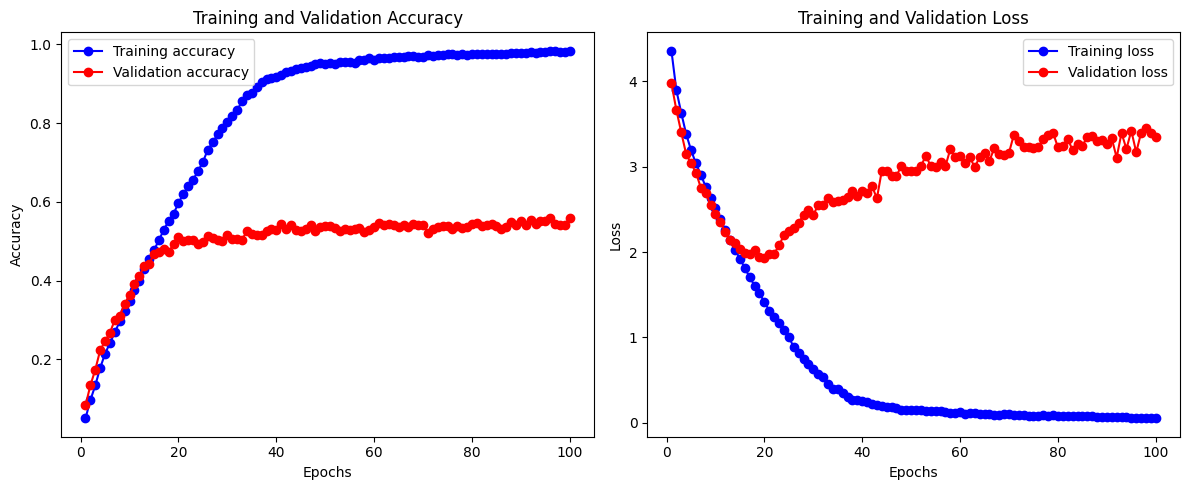

In [19]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
accuracy = history.history['accuracy']
loss = history.history['loss']

# Check if validation data was used during training
if 'val_accuracy' in history.history:
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    has_validation = True
else:
    has_validation = False

# Create epochs range
epochs = range(1, len(accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
if has_validation:
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
if has_validation:
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()